#### Model evaluation
Code to generate the metrics used for the evaluation of the models.
We begin by importing the libraries and setting the colour palette.

In [11]:
import numpy as np
import ctaplot
import pandas as pd
from ctapipe.io import read_table, write_table
from matplotlib import pyplot as plt
import astropy.units as u
from astropy.table import join, vstack, hstack
from sklearn import metrics
from collections import OrderedDict
import ctapipe
import matplotlib
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

ctaplot.set_style('notebook')
import IPython.display as display


#Plot style
## https://ctaplot.readthedocs.io/en/latest/notebooks/style.html

In [12]:
CUSTOM_COLORS = [
    "#3685be",  # blue
    "#ff7f0e",  # orange
    "#2ca02c",  # green
    "#d62728",  # red
    "#870afb",  # purple
    "#8c564b",  # brown
    "#d14ca9",  # pink
    "#6e6868",  # gray
    "#660033",  # dark red
    "#2b08a9",  # dark blue
    "#9ebd22",  # olive
    "#17becf",  # Cyan / Teal
    "#d7b610",  # Dark yellow
    "#c6757b",  # light pink

    "#4F2576",  # light purple
    ]
plt.rcParams["axes.prop_cycle"] = plt.cycler(color=CUSTOM_COLORS)




We load the baseline predictions

In [13]:
#Baseline:
orig_baseline_path_origin = "/lhome/ext/ucm147/ucm1478/Model_compression_yes/experiment_1/prediction_Keras/"
orig_baseline_gamma = "Kpredict_gamma_theta_32.059_az_248.099_runs1-500.dl2.h5"
orig_baseline_proton = "Kpredict_proton_theta_32.059_az_248.099_runs1-500.dl2.h5"
orig_baseline_electron = "Kpredict_electron_theta_32.059_az_248.099_runs1-500.dl2.h5"


orig_gamma_path = orig_baseline_path_origin + orig_baseline_gamma
orig_proton_path = orig_baseline_path_origin + orig_baseline_proton
orig_electron_path = orig_baseline_path_origin + orig_baseline_electron

# Define arrays for gamma and proton paths, and their labels
orig_gamma_paths = [orig_gamma_path]
orig_proton_paths = [orig_proton_path]
orig_labels = ["Baseline"]


And load the pruned model predictions

In [14]:
#percentages = [40,  60, 70, 80, 90, 95]  
#percentages = [30, 70, 90, 95]
percent = [30, 40, 50, 60, 70, 90, 95, 99]
schedule = 'polynomial'
pruned_gamma_paths = []
pruned_proton_paths = []
pruned_titles = []
pruned_labels = []
percentages = []

# Filenames of the prediction files
gamma_file = 'gamma_theta_32.059_az_248.099_runs1-500.dl2.h5'
proton_file = 'proton_theta_32.059_az_248.099_runs1-500.dl2.h5'
#electron_file = 'electron_theta_32.059_az_248.099_runs1-500.dl2.h5'  # if needed

for percentage in percent:
    # Build origin path dynamically
    path_origin = f"/lhome/ext/ucm147/ucm1478/pruning_experiment/{schedule}_sparsity/{percentage}_sparsity/predictions/"
    # Build full paths dynamically
    gamma_path = path_origin + gamma_file
    proton_path = path_origin + proton_file
    #electron_path = path_origin + electron_file  # optional

    # Save in arrays
    pruned_gamma_paths.append(gamma_path)
    pruned_proton_paths.append(proton_path)
    pruned_titles.append(f"{percentage}% sparse")
    pruned_labels.append(f"{percentage}%")
    percentages.append(percentage)  

# Check results
print(pruned_gamma_paths)
print(pruned_proton_paths)
print(pruned_labels)



['/lhome/ext/ucm147/ucm1478/pruning_experiment/polynomial_sparsity/30_sparsity/predictions/gamma_theta_32.059_az_248.099_runs1-500.dl2.h5', '/lhome/ext/ucm147/ucm1478/pruning_experiment/polynomial_sparsity/40_sparsity/predictions/gamma_theta_32.059_az_248.099_runs1-500.dl2.h5', '/lhome/ext/ucm147/ucm1478/pruning_experiment/polynomial_sparsity/50_sparsity/predictions/gamma_theta_32.059_az_248.099_runs1-500.dl2.h5', '/lhome/ext/ucm147/ucm1478/pruning_experiment/polynomial_sparsity/60_sparsity/predictions/gamma_theta_32.059_az_248.099_runs1-500.dl2.h5', '/lhome/ext/ucm147/ucm1478/pruning_experiment/polynomial_sparsity/70_sparsity/predictions/gamma_theta_32.059_az_248.099_runs1-500.dl2.h5', '/lhome/ext/ucm147/ucm1478/pruning_experiment/polynomial_sparsity/90_sparsity/predictions/gamma_theta_32.059_az_248.099_runs1-500.dl2.h5', '/lhome/ext/ucm147/ucm1478/pruning_experiment/polynomial_sparsity/95_sparsity/predictions/gamma_theta_32.059_az_248.099_runs1-500.dl2.h5', '/lhome/ext/ucm147/ucm1478

We now combine the paths and labels of the pruned models with the baseline model

In [15]:
# Combine baseline and pruning arrays
all_percentages = [0] + percentages 
all_gamma_paths = orig_gamma_paths + pruned_gamma_paths
all_proton_paths = orig_proton_paths + pruned_proton_paths
all_labels = orig_labels + pruned_labels
all_titles = orig_labels + pruned_titles

print("All gamma paths:", all_gamma_paths)
print("All proton paths:", all_proton_paths)
print("All labels:", all_labels)
print("All titles:", all_titles)

All gamma paths: ['/lhome/ext/ucm147/ucm1478/Model_compression_yes/experiment_1/prediction_Keras/Kpredict_gamma_theta_32.059_az_248.099_runs1-500.dl2.h5', '/lhome/ext/ucm147/ucm1478/pruning_experiment/polynomial_sparsity/30_sparsity/predictions/gamma_theta_32.059_az_248.099_runs1-500.dl2.h5', '/lhome/ext/ucm147/ucm1478/pruning_experiment/polynomial_sparsity/40_sparsity/predictions/gamma_theta_32.059_az_248.099_runs1-500.dl2.h5', '/lhome/ext/ucm147/ucm1478/pruning_experiment/polynomial_sparsity/50_sparsity/predictions/gamma_theta_32.059_az_248.099_runs1-500.dl2.h5', '/lhome/ext/ucm147/ucm1478/pruning_experiment/polynomial_sparsity/60_sparsity/predictions/gamma_theta_32.059_az_248.099_runs1-500.dl2.h5', '/lhome/ext/ucm147/ucm1478/pruning_experiment/polynomial_sparsity/70_sparsity/predictions/gamma_theta_32.059_az_248.099_runs1-500.dl2.h5', '/lhome/ext/ucm147/ucm1478/pruning_experiment/polynomial_sparsity/90_sparsity/predictions/gamma_theta_32.059_az_248.099_runs1-500.dl2.h5', '/lhome/ext

Load simulated parameters to a table

In [16]:
# Use only when the simulation table is in DL2
# Load simulated parameters (DL1) to a table

def load_true_shower_parameters(input_file):
    """    
    Load true, simulated shower parameters from a given MC input file.

    Parameters:
    mc_input_file (str): Path to the MC input file containing the shower parameters.
    
    Returns:
    true_shower_parameters (astropy.table.Table): Table containing the true shower parameters.
    """
    true_shower_parameters = read_table(input_file, "simulation/event/subarray/shower")
    return true_shower_parameters

# Sanity checks
#pruned_gamma = load_true_shower_parameters(gamma_path)
#print(pruned_gamma[0:3])

In [17]:
# Predicted DL2 data in one single table with pointing info 

def load_DL2_data_MC(input_file, tel_id=None):

    """
    Load DL2 data from a given input file to obtain the predicted classification, energy, and geometry full tables.
    
    Parameters:
    input_file (str): Path to the input file containing DL2 data.
    tel_id (int, optional): Telescope ID to select telescope. If None, data for all telescopes is loaded.

    Returns:
    dl2 (astropy.table.Table): Combined table containing predicted classification, energy, and geometry data with pointing information.
    """

    subarray_string = "subarray" if tel_id==None else "telescope"
    tel_id_string = "" if tel_id==None else f"tel_{tel_id:03d}"
    pointing = read_table(input_file, f"dl1/monitoring/{subarray_string}/pointing/{tel_id_string}")
    #key_tel = "tel_" if tel_id==None else "tel_" 
    key_tel = "" if tel_id==None else "tel_" 

    dl2_tables = []
    
    try:
        # Try to read the predicted classification table and join it with the pointing table
        # Then it is appended to dl2_tables
        dl2_predicted_classification = read_table(input_file, f"dl2/event/{subarray_string}/classification/CTLearn/{tel_id_string}")
        dl2_classification = hstack([dl2_predicted_classification, pointing])
        dl2_classification = dl2_classification[~np.isnan(dl2_classification[f"CTLearn_{key_tel}prediction"])]
        dl2_tables.append(dl2_classification)
    except:
        print(f"Classification table for {input_file} not found for dl2/event/{subarray_string}/classification/CTLearn/{tel_id_string}")

    try:
        # Try to read the predicted energy table and join it with the pointing table
        # Then it is appended to dl2_tables
        dl2_predicted_energy = read_table(input_file, f"dl2/event/{subarray_string}/energy/CTLearn/{tel_id_string}")
        if len(dl2_tables) == 0:
            dl2_predicted_energy = hstack([dl2_predicted_energy, pointing])
        dl2_energy = dl2_predicted_energy[~np.isnan(dl2_predicted_energy[f"CTLearn_{key_tel}energy"])]
        dl2_tables.append(dl2_energy)
    except:
        print(f"Energy table for {input_file} not found for dl2/event/{subarray_string}/energy/CTLearn/{tel_id_string}")

    try:
        # Try to read the predicted geometry table and join it with the pointing table
        # Then it is appended to dl2_tables
        dl2_predicted_geometry = read_table(input_file, f"dl2/event/{subarray_string}/geometry/CTLearn/{tel_id_string}")
        if len(dl2_tables) == 0:
            dl2_predicted_geometry = hstack([dl2_predicted_geometry, pointing])
        dl2_geometry = dl2_predicted_geometry[~np.isnan(dl2_predicted_geometry[f"CTLearn_{key_tel}alt"])]
        dl2_tables.append(dl2_geometry)
    except:
        print(f"Geometry table for {input_file} not found for dl2/event/{subarray_string}/geometry/CTLearn/{tel_id_string}")

    # Now we have a list of tables (dl2_tables). Each table is the predicted tasks' (classification, energy, and geometry) table with the pointing column information    
    
    if len(dl2_tables) > 0:
        dl2 = dl2_tables[0]
        for table in dl2_tables[1:]:
            dl2 = join(dl2, table, keys=["obs_id", "event_id"])
    else:
        raise ValueError("No DL2 tables found")

    
    # Join the tables into one by matching on 'obs_id' and 'event_id'
    return dl2, key_tel

# Sanity checks    
#my_gamma_table, key_tel = load_DL2_data_MC(baseline_gamma_path, tel_id=1)  
#my_pruned_gamma_table, key_tel = load_DL2_data_MC(pruned_gamma_path, tel_id=1)  
#my_pruned_gamma_table, key_tel = load_DL2_data_MC(gamma_pruning_path, tel_id=1)  
#orig_gamma_table, key_tel = load_DL2_data_MC(orig_gamma_path, tel_id=1)

#print(my_pruned_gamma_table[0:4])
#print(my_pruned_gamma_table["CTLearn_tel_prediction"][0:10])
#print(my_gamma_table["CTLearn_tel_prediction"][0:10])
#print(orig_gamma_table["CTLearn_tel_prediction"][0:4])

Join the tables with the predicted and the simulated parameters

In [18]:
# Get a table with simulated and predicted data for gamma and proton
key_tel = "tel_id"

def prepare_for_metrics(testing_DL2_gamma_files, testing_DL2_proton_files, key_tel, tel_id = 1):
    
    gammaness_key = str(f'CTLearn_{key_tel}prediction')
    true_energy_key = 'true_energy'
    
    if len(testing_DL2_gamma_files) > 0:
        predicted_gamma_parameters = []
        simulated_gamma_parameters = []
        gamma_shower = []
        configuration_gamma = []

        for file in testing_DL2_gamma_files:
            print(file)
            predicted_gamma_parameters.append(load_DL2_data_MC(file, tel_id=tel_id)[0])
            simulated_gamma_parameters.append(load_true_shower_parameters(file))
            #configuration_gamma.append(load_shower_parameters(file, tel_id=tel_id))
        predicted_gamma_parameters = vstack(predicted_gamma_parameters)
        simulated_gamma_parameters = vstack(simulated_gamma_parameters)
        gamma_shower = join(predicted_gamma_parameters, simulated_gamma_parameters, keys=["obs_id", "event_id"])
        #shower_config = vstack(configuration_gamma)
        #gamma_config = join(gamma_shower, shower_config, keys=["obs_id"])
        #gamma_config = []
    if len(testing_DL2_proton_files) > 0:
        predicted_proton_parameters = []
        simulated_proton_parameters = []
        for file in testing_DL2_proton_files:
            print(file)
            predicted_proton_parameters.append(load_DL2_data_MC(file, tel_id=tel_id)[0])
            simulated_proton_parameters.append(load_true_shower_parameters(file))
        predicted_proton_parameters = vstack(predicted_proton_parameters)
        simulated_proton_parameters = vstack(simulated_proton_parameters)
        proton_shower = join(predicted_proton_parameters, simulated_proton_parameters, keys=["obs_id", "event_id"])
        
    true_gamma = np.ones(len(gamma_shower))
    true_proton = np.zeros(len(proton_shower))
    print("Proton shower length", len(proton_shower), "Gamma shower length", len(gamma_shower))
    true_type = np.concatenate((true_gamma, true_proton))

    gammaness = np.concatenate((gamma_shower[gammaness_key], proton_shower[gammaness_key]))
    true_energies = np.concatenate((gamma_shower[true_energy_key], proton_shower[true_energy_key])) * u.TeV

    return gamma_shower, proton_shower, true_type, gammaness, true_energies


In [19]:
# Store results for each set
results = OrderedDict()
key_tel = "tel_"

for percentage, gamma_path, proton_path, label, title in zip(all_percentages, all_gamma_paths, all_proton_paths, all_labels, all_titles):
    gamma_shower, proton_shower, true_type, gammaness, true_energies = prepare_for_metrics(
        [gamma_path], [proton_path], key_tel, 1
    )


    results[label] = {
        "percentage": percentage,
        "gamma_shower": gamma_shower,
        "proton_shower": proton_shower,
        "true_type": true_type,
        "gammaness": gammaness,
        "true_energies": true_energies,
        "titles": title
    }

/lhome/ext/ucm147/ucm1478/Model_compression_yes/experiment_1/prediction_Keras/Kpredict_gamma_theta_32.059_az_248.099_runs1-500.dl2.h5
/lhome/ext/ucm147/ucm1478/Model_compression_yes/experiment_1/prediction_Keras/Kpredict_proton_theta_32.059_az_248.099_runs1-500.dl2.h5
Energy table for /lhome/ext/ucm147/ucm1478/Model_compression_yes/experiment_1/prediction_Keras/Kpredict_proton_theta_32.059_az_248.099_runs1-500.dl2.h5 not found for dl2/event/telescope/energy/CTLearn/tel_001
Geometry table for /lhome/ext/ucm147/ucm1478/Model_compression_yes/experiment_1/prediction_Keras/Kpredict_proton_theta_32.059_az_248.099_runs1-500.dl2.h5 not found for dl2/event/telescope/geometry/CTLearn/tel_001
Proton shower length 32647 Gamma shower length 2041124
/lhome/ext/ucm147/ucm1478/pruning_experiment/polynomial_sparsity/30_sparsity/predictions/gamma_theta_32.059_az_248.099_runs1-500.dl2.h5


/lhome/ext/ucm147/ucm1478/pruning_experiment/polynomial_sparsity/30_sparsity/predictions/proton_theta_32.059_az_248.099_runs1-500.dl2.h5
Energy table for /lhome/ext/ucm147/ucm1478/pruning_experiment/polynomial_sparsity/30_sparsity/predictions/proton_theta_32.059_az_248.099_runs1-500.dl2.h5 not found for dl2/event/telescope/energy/CTLearn/tel_001
Geometry table for /lhome/ext/ucm147/ucm1478/pruning_experiment/polynomial_sparsity/30_sparsity/predictions/proton_theta_32.059_az_248.099_runs1-500.dl2.h5 not found for dl2/event/telescope/geometry/CTLearn/tel_001
Proton shower length 32647 Gamma shower length 2041124
/lhome/ext/ucm147/ucm1478/pruning_experiment/polynomial_sparsity/40_sparsity/predictions/gamma_theta_32.059_az_248.099_runs1-500.dl2.h5
/lhome/ext/ucm147/ucm1478/pruning_experiment/polynomial_sparsity/40_sparsity/predictions/proton_theta_32.059_az_248.099_runs1-500.dl2.h5
Energy table for /lhome/ext/ucm147/ucm1478/pruning_experiment/polynomial_sparsity/40_sparsity/predictions/pro

Store some useful variables in arrays

In [20]:
true_energies_list = []
gammaness_list = []
true_type_list = []
gamma_shower_list = []


for label in all_labels:
    true_energies_list.append(results[label]["true_energies"])
    gammaness_list.append(results[label]["gammaness"])
    true_type_list.append(results[label]["true_type"])
    gamma_shower_list.append(results[label]["gamma_shower"])


In [21]:
# Define binning
bins = ctaplot.ana.ana.logspace_decades_nbin(0.01, 5, 5)

bin = []
for b in bins:
    bi = b*u.TeV
    bin.append(bi)
print(bin)

[<Quantity 0.01 TeV>, <Quantity 0.01584893 TeV>, <Quantity 0.02511886 TeV>, <Quantity 0.03981072 TeV>, <Quantity 0.06309573 TeV>, <Quantity 0.1 TeV>, <Quantity 0.15848932 TeV>, <Quantity 0.25118864 TeV>, <Quantity 0.39810717 TeV>, <Quantity 0.63095734 TeV>, <Quantity 1. TeV>, <Quantity 1.58489319 TeV>, <Quantity 2.51188643 TeV>, <Quantity 3.98107171 TeV>]


Plot ROC curve. Each plot corresponds to a different pruning percentage. Each plot contains the ROC curves for different energy bins

In [22]:
def plot_roc_gammaness_per_energy(true_energies_list, gammaness_list, true_type_list, titles_list, nbins = 5):
    """
    Using ctaplot function: Plot ROC curve of gammaness per energy.
    Parameters:
    true_energies (astropy.units.Quantity): True energies of the showers.
    gammaness (np.ndarray): Gammaness values for the showers.
    true_type (np.ndarray): True type of the showers (1 for gamma, 0 for proton).
    """ 
    total_subplots = len(true_energies_list)
    fig, axes = plt.subplots(int(np.ceil(total_subplots / 2)), 3, figsize=(20 , 6*total_subplots/2))
    #plt.suptitle("ROC Curves", fontsize=16)

    
    axes = axes.flatten()

    for i, (true_energies, gammaness, true_type) in enumerate(zip(true_energies_list, gammaness_list, true_type_list)):
        
        ctaplot.plot_roc_curve_gammaness_per_energy(true_type, gammaness, true_energies,
                                                    energy_bins=bin, #u.Quantity([0.01,0.1,1,3,10], u.TeV),
                                                    linestyle='--', gamma_label=1,
                                                     alpha=1,
                                                    linewidth=2,
                                                    ax = axes[i]
                                                            )
        
        #axes[i].legend()
        # Get the current legend and modify the labels
        legend = axes[i].legend()
        legend_labels = [t.get_text() for t in legend.get_texts()]
        
        # Modify labels to show energy ranges with AUC
        new_labels = []
        for j, old_label in enumerate(legend_labels):
            if j < len(bins) - 1:
                bin_low = bins[j]
                bin_high = bins[j+1]
                # Extract AUC from the existing label (format: "AUC = 0.xxx")
                if "auc score =" in old_label.lower():
                    auc_value = old_label.split("=")[-1].strip()
                    new_labels.append(f"[{bin_low:.2f} - {bin_high:.2f}] AUC = {auc_value}")
                else:
                    new_labels.append(f"[{bin_low:.2f} - {bin_high:.2f}] AUC = N/A")

        
        axes[i].legend(legend.get_lines(), new_labels, loc='lower right')
        # Update legend with new labels
        #axes[i].legend(legend.get_lines(), new_labels, loc='lower right')
        axes[i].set_xlabel("Gamma False Positive Rate", fontsize= 16)
        axes[i].set_ylabel("Gamma True Positive Rate", fontsize= 16)
        #axes[i].set_xlim(-0.05, 1.3)
        #axes[i].set_ylim(-0.05, 1.05)
        axes[i].set_title(titles_list[i], fontsize=20)
    plt.suptitle("ROC Curves", fontsize=24, y=0.99)
    for j in range(len(true_energies_list), len(axes)):
        axes[j].axis('off')
    
    plt.tight_layout(h_pad=2, w_pad=3)
    plt.show()


[(0.9913725490196079, 0.7913725490196079, 0.7082352941176471, 1.0), (0.9882352941176471, 0.7118954248366013, 0.606797385620915, 1.0), (0.9882352941176471, 0.6261437908496732, 0.5084967320261438, 1.0), (0.9874509803921568, 0.5411764705882353, 0.41568627450980394, 1.0), (0.9853594771241829, 0.4575163398692811, 0.3320261437908497, 1.0), (0.9717647058823529, 0.3665359477124183, 0.25882352941176473, 1.0), (0.9466666666666667, 0.26823529411764707, 0.19607843137254902, 1.0), (0.8901960784313725, 0.18562091503267975, 0.15294117647058825, 1.0), (0.8149019607843137, 0.11241830065359477, 0.12156862745098039, 1.0), (0.7364705882352941, 0.08, 0.10117647058823528, 1.0), (0.6569934640522876, 0.06117647058823529, 0.08444444444444443, 1.0), (0.5335947712418301, 0.03137254901960784, 0.06771241830065358, 1.0), (0.403921568627451, 0.0, 0.05098039215686274, 1.0)]


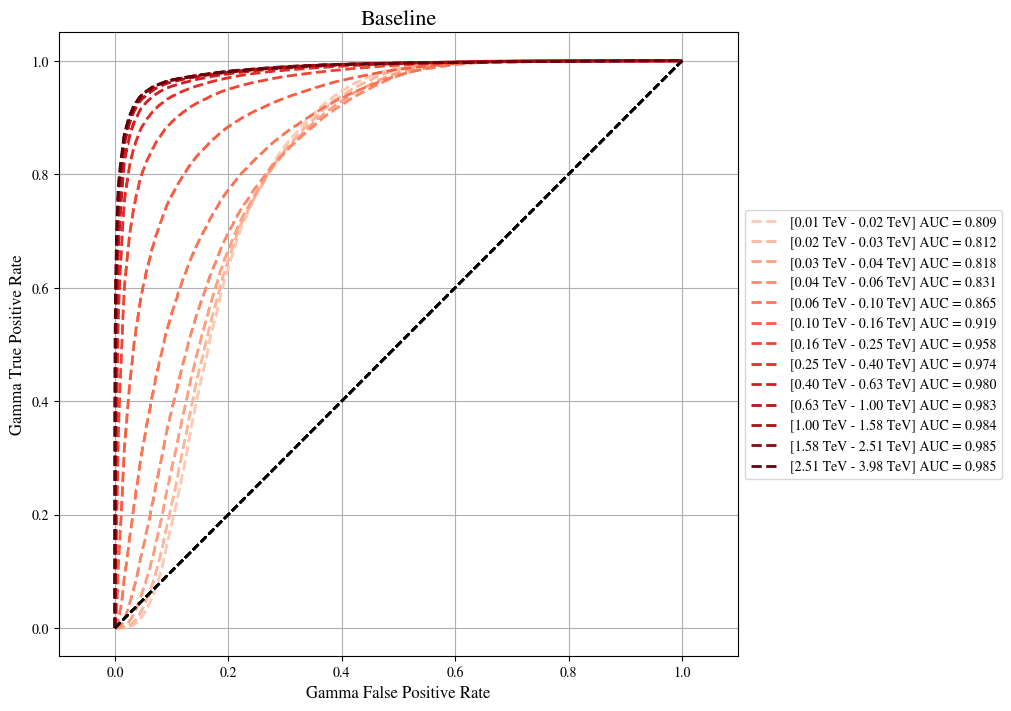

[(0.9913725490196079, 0.7913725490196079, 0.7082352941176471, 1.0), (0.9882352941176471, 0.7118954248366013, 0.606797385620915, 1.0), (0.9882352941176471, 0.6261437908496732, 0.5084967320261438, 1.0), (0.9874509803921568, 0.5411764705882353, 0.41568627450980394, 1.0), (0.9853594771241829, 0.4575163398692811, 0.3320261437908497, 1.0), (0.9717647058823529, 0.3665359477124183, 0.25882352941176473, 1.0), (0.9466666666666667, 0.26823529411764707, 0.19607843137254902, 1.0), (0.8901960784313725, 0.18562091503267975, 0.15294117647058825, 1.0), (0.8149019607843137, 0.11241830065359477, 0.12156862745098039, 1.0), (0.7364705882352941, 0.08, 0.10117647058823528, 1.0), (0.6569934640522876, 0.06117647058823529, 0.08444444444444443, 1.0), (0.5335947712418301, 0.03137254901960784, 0.06771241830065358, 1.0), (0.403921568627451, 0.0, 0.05098039215686274, 1.0)]


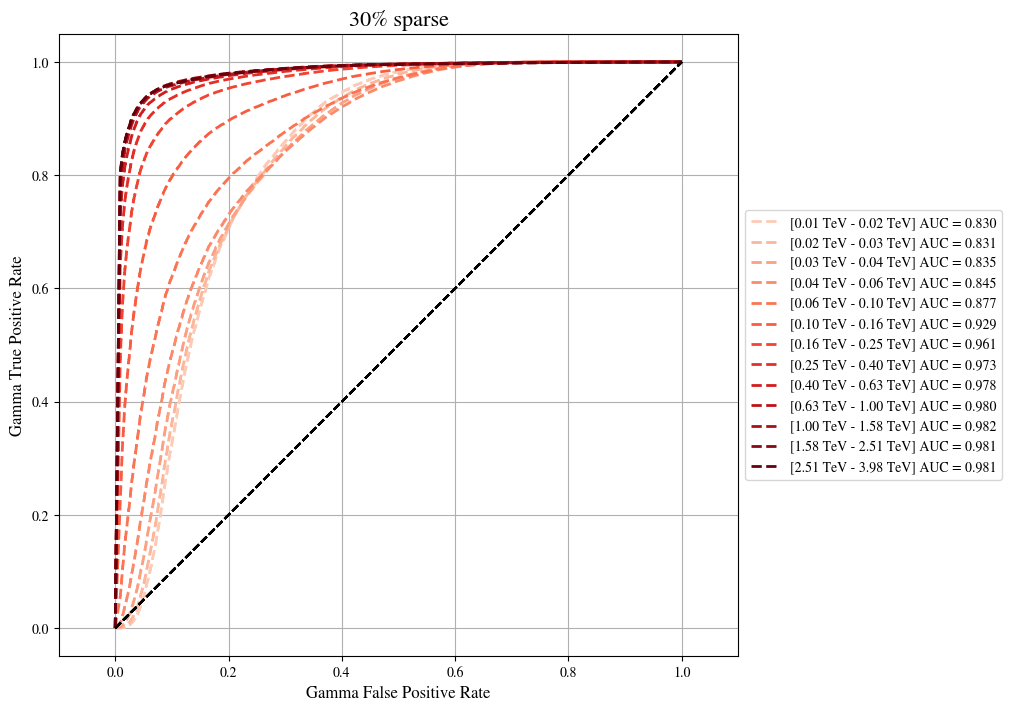

[(0.9913725490196079, 0.7913725490196079, 0.7082352941176471, 1.0), (0.9882352941176471, 0.7118954248366013, 0.606797385620915, 1.0), (0.9882352941176471, 0.6261437908496732, 0.5084967320261438, 1.0), (0.9874509803921568, 0.5411764705882353, 0.41568627450980394, 1.0), (0.9853594771241829, 0.4575163398692811, 0.3320261437908497, 1.0), (0.9717647058823529, 0.3665359477124183, 0.25882352941176473, 1.0), (0.9466666666666667, 0.26823529411764707, 0.19607843137254902, 1.0), (0.8901960784313725, 0.18562091503267975, 0.15294117647058825, 1.0), (0.8149019607843137, 0.11241830065359477, 0.12156862745098039, 1.0), (0.7364705882352941, 0.08, 0.10117647058823528, 1.0), (0.6569934640522876, 0.06117647058823529, 0.08444444444444443, 1.0), (0.5335947712418301, 0.03137254901960784, 0.06771241830065358, 1.0), (0.403921568627451, 0.0, 0.05098039215686274, 1.0)]


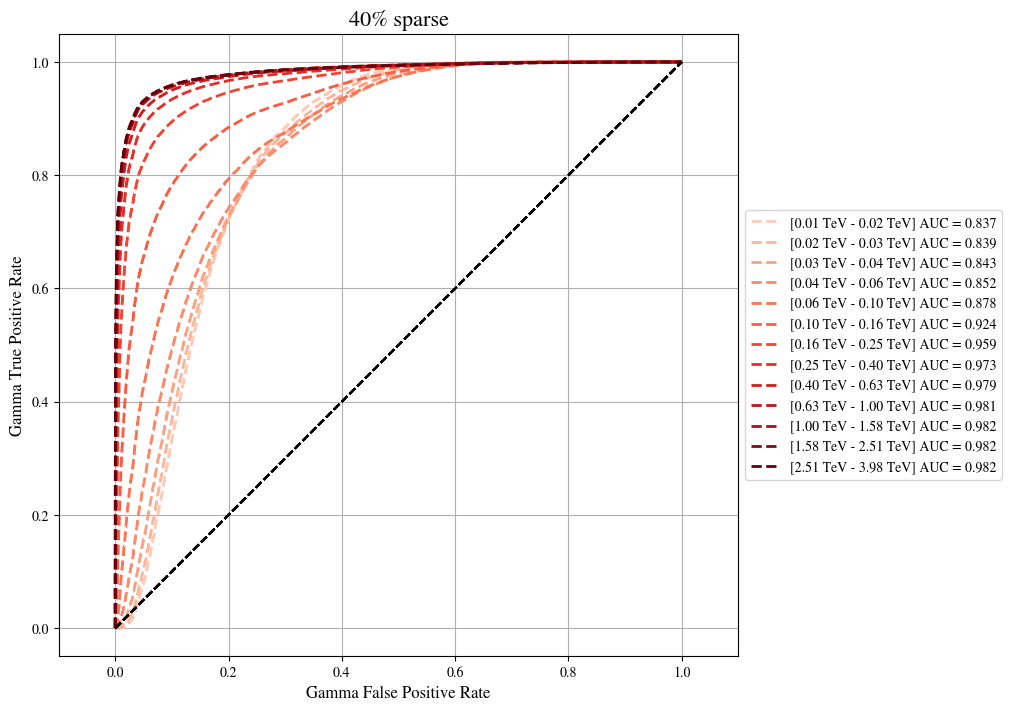

[(0.9913725490196079, 0.7913725490196079, 0.7082352941176471, 1.0), (0.9882352941176471, 0.7118954248366013, 0.606797385620915, 1.0), (0.9882352941176471, 0.6261437908496732, 0.5084967320261438, 1.0), (0.9874509803921568, 0.5411764705882353, 0.41568627450980394, 1.0), (0.9853594771241829, 0.4575163398692811, 0.3320261437908497, 1.0), (0.9717647058823529, 0.3665359477124183, 0.25882352941176473, 1.0), (0.9466666666666667, 0.26823529411764707, 0.19607843137254902, 1.0), (0.8901960784313725, 0.18562091503267975, 0.15294117647058825, 1.0), (0.8149019607843137, 0.11241830065359477, 0.12156862745098039, 1.0), (0.7364705882352941, 0.08, 0.10117647058823528, 1.0), (0.6569934640522876, 0.06117647058823529, 0.08444444444444443, 1.0), (0.5335947712418301, 0.03137254901960784, 0.06771241830065358, 1.0), (0.403921568627451, 0.0, 0.05098039215686274, 1.0)]


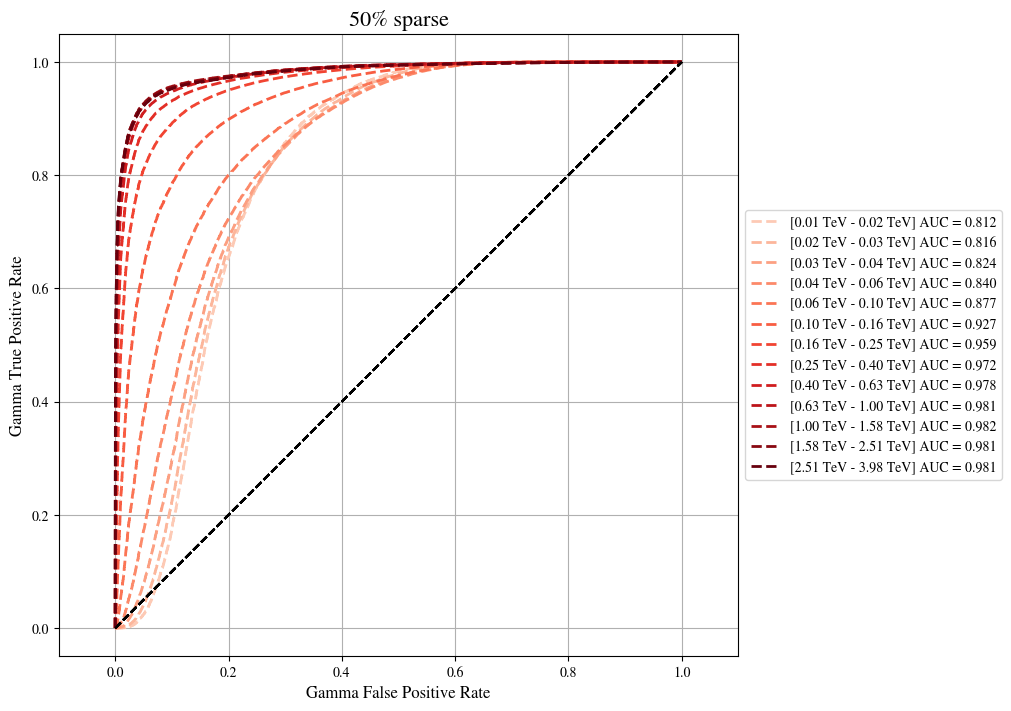

[(0.9913725490196079, 0.7913725490196079, 0.7082352941176471, 1.0), (0.9882352941176471, 0.7118954248366013, 0.606797385620915, 1.0), (0.9882352941176471, 0.6261437908496732, 0.5084967320261438, 1.0), (0.9874509803921568, 0.5411764705882353, 0.41568627450980394, 1.0), (0.9853594771241829, 0.4575163398692811, 0.3320261437908497, 1.0), (0.9717647058823529, 0.3665359477124183, 0.25882352941176473, 1.0), (0.9466666666666667, 0.26823529411764707, 0.19607843137254902, 1.0), (0.8901960784313725, 0.18562091503267975, 0.15294117647058825, 1.0), (0.8149019607843137, 0.11241830065359477, 0.12156862745098039, 1.0), (0.7364705882352941, 0.08, 0.10117647058823528, 1.0), (0.6569934640522876, 0.06117647058823529, 0.08444444444444443, 1.0), (0.5335947712418301, 0.03137254901960784, 0.06771241830065358, 1.0), (0.403921568627451, 0.0, 0.05098039215686274, 1.0)]


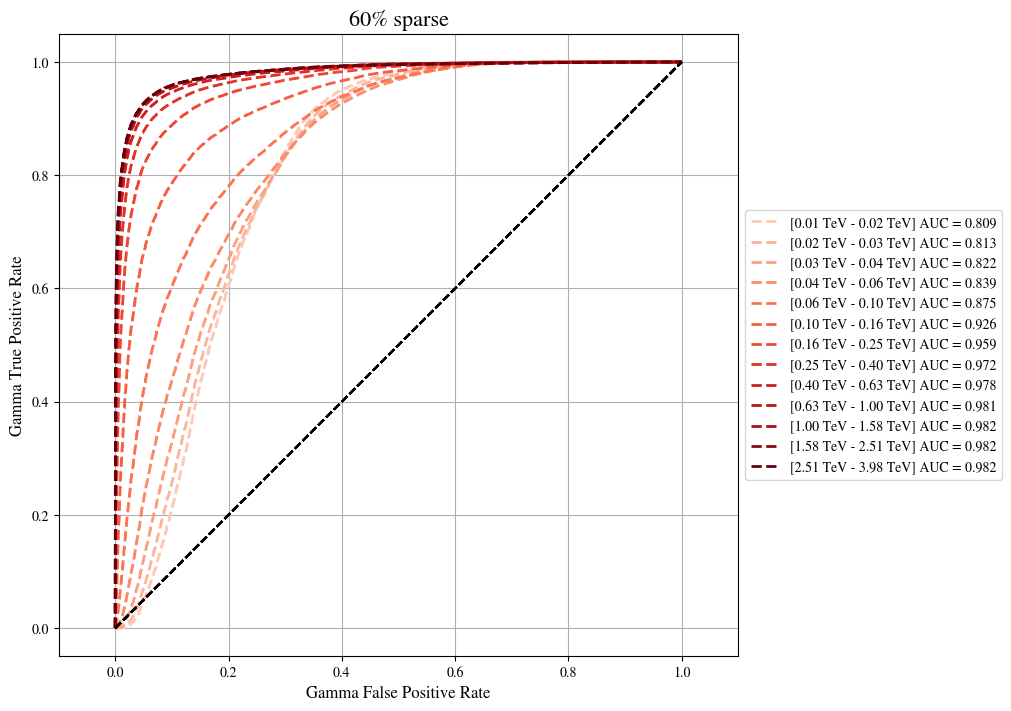

[(0.9913725490196079, 0.7913725490196079, 0.7082352941176471, 1.0), (0.9882352941176471, 0.7118954248366013, 0.606797385620915, 1.0), (0.9882352941176471, 0.6261437908496732, 0.5084967320261438, 1.0), (0.9874509803921568, 0.5411764705882353, 0.41568627450980394, 1.0), (0.9853594771241829, 0.4575163398692811, 0.3320261437908497, 1.0), (0.9717647058823529, 0.3665359477124183, 0.25882352941176473, 1.0), (0.9466666666666667, 0.26823529411764707, 0.19607843137254902, 1.0), (0.8901960784313725, 0.18562091503267975, 0.15294117647058825, 1.0), (0.8149019607843137, 0.11241830065359477, 0.12156862745098039, 1.0), (0.7364705882352941, 0.08, 0.10117647058823528, 1.0), (0.6569934640522876, 0.06117647058823529, 0.08444444444444443, 1.0), (0.5335947712418301, 0.03137254901960784, 0.06771241830065358, 1.0), (0.403921568627451, 0.0, 0.05098039215686274, 1.0)]


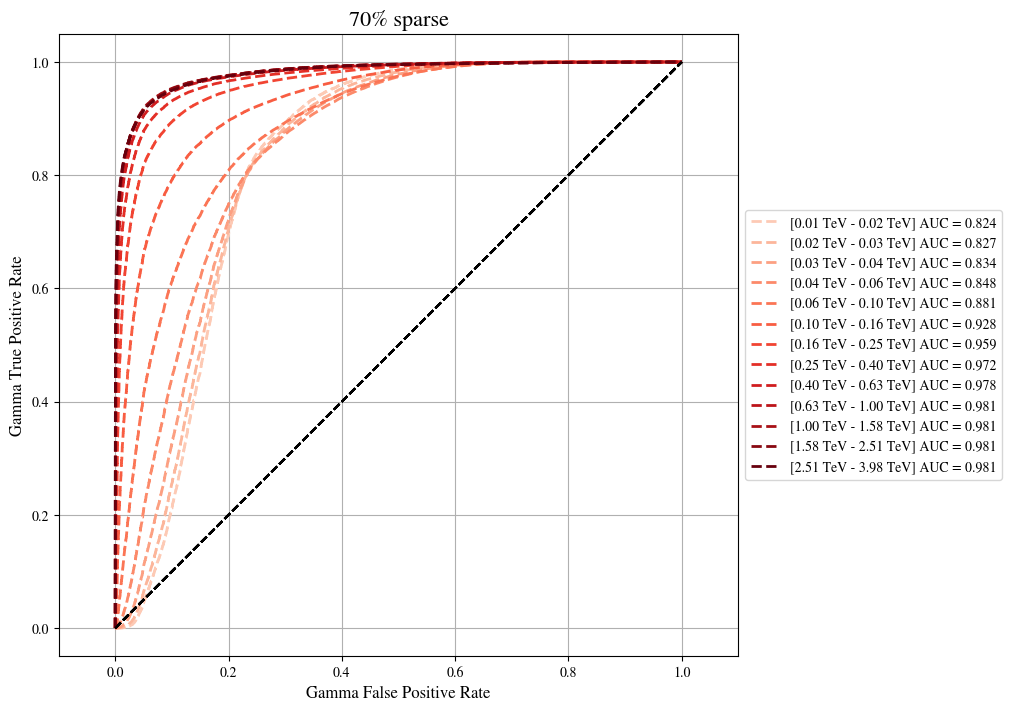

[(0.9913725490196079, 0.7913725490196079, 0.7082352941176471, 1.0), (0.9882352941176471, 0.7118954248366013, 0.606797385620915, 1.0), (0.9882352941176471, 0.6261437908496732, 0.5084967320261438, 1.0), (0.9874509803921568, 0.5411764705882353, 0.41568627450980394, 1.0), (0.9853594771241829, 0.4575163398692811, 0.3320261437908497, 1.0), (0.9717647058823529, 0.3665359477124183, 0.25882352941176473, 1.0), (0.9466666666666667, 0.26823529411764707, 0.19607843137254902, 1.0), (0.8901960784313725, 0.18562091503267975, 0.15294117647058825, 1.0), (0.8149019607843137, 0.11241830065359477, 0.12156862745098039, 1.0), (0.7364705882352941, 0.08, 0.10117647058823528, 1.0), (0.6569934640522876, 0.06117647058823529, 0.08444444444444443, 1.0), (0.5335947712418301, 0.03137254901960784, 0.06771241830065358, 1.0), (0.403921568627451, 0.0, 0.05098039215686274, 1.0)]


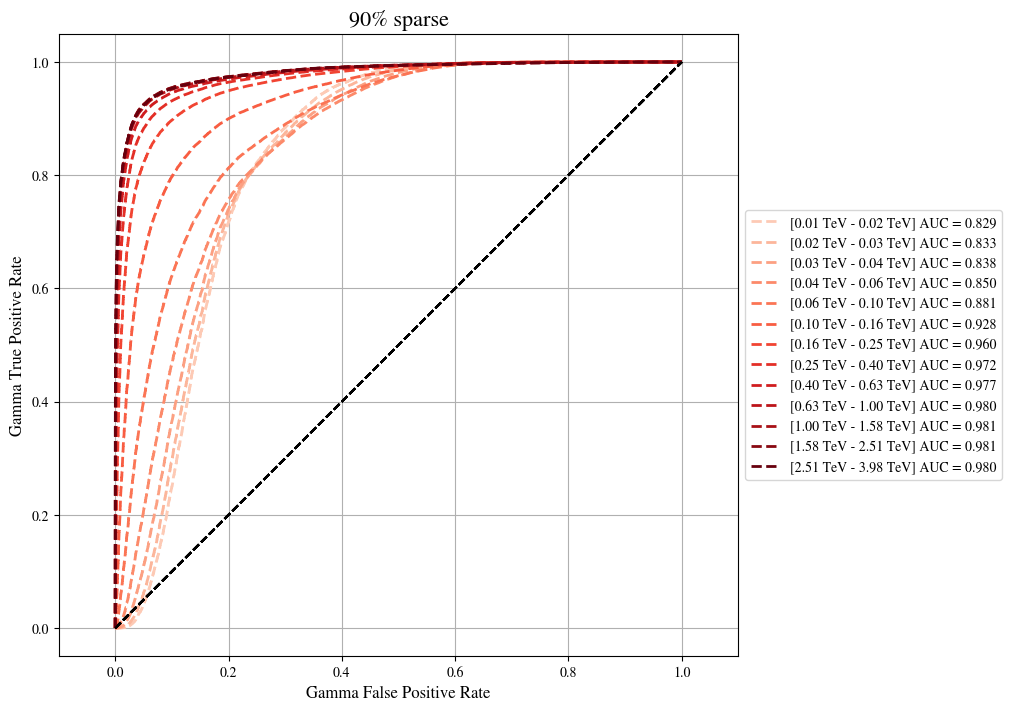

[(0.9913725490196079, 0.7913725490196079, 0.7082352941176471, 1.0), (0.9882352941176471, 0.7118954248366013, 0.606797385620915, 1.0), (0.9882352941176471, 0.6261437908496732, 0.5084967320261438, 1.0), (0.9874509803921568, 0.5411764705882353, 0.41568627450980394, 1.0), (0.9853594771241829, 0.4575163398692811, 0.3320261437908497, 1.0), (0.9717647058823529, 0.3665359477124183, 0.25882352941176473, 1.0), (0.9466666666666667, 0.26823529411764707, 0.19607843137254902, 1.0), (0.8901960784313725, 0.18562091503267975, 0.15294117647058825, 1.0), (0.8149019607843137, 0.11241830065359477, 0.12156862745098039, 1.0), (0.7364705882352941, 0.08, 0.10117647058823528, 1.0), (0.6569934640522876, 0.06117647058823529, 0.08444444444444443, 1.0), (0.5335947712418301, 0.03137254901960784, 0.06771241830065358, 1.0), (0.403921568627451, 0.0, 0.05098039215686274, 1.0)]


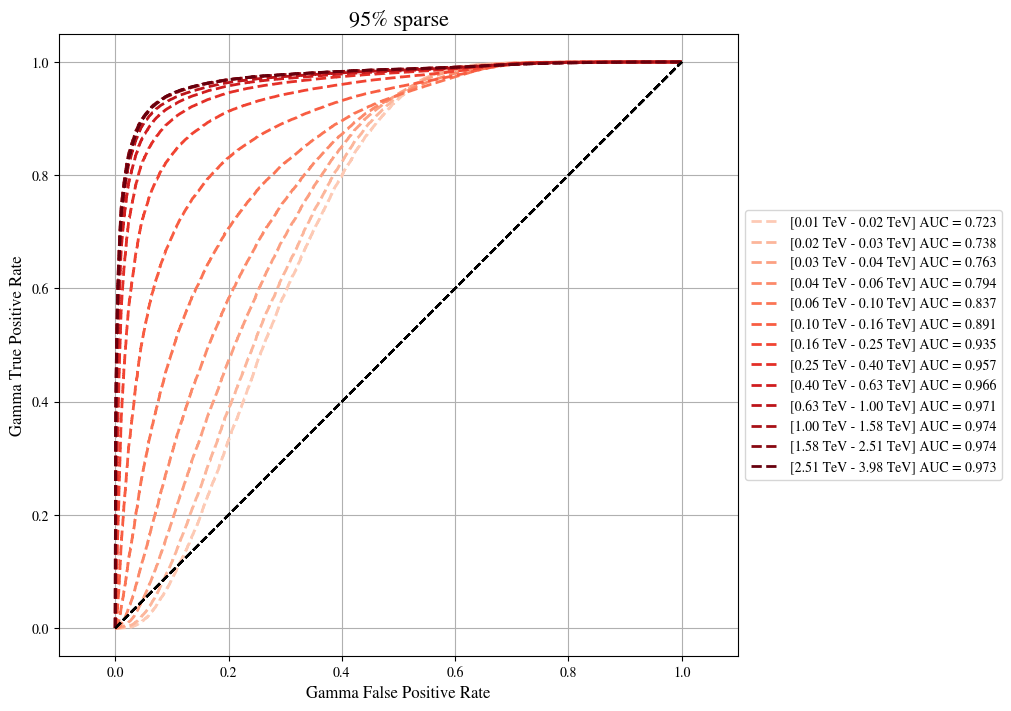

[(0.9913725490196079, 0.7913725490196079, 0.7082352941176471, 1.0), (0.9882352941176471, 0.7118954248366013, 0.606797385620915, 1.0), (0.9882352941176471, 0.6261437908496732, 0.5084967320261438, 1.0), (0.9874509803921568, 0.5411764705882353, 0.41568627450980394, 1.0), (0.9853594771241829, 0.4575163398692811, 0.3320261437908497, 1.0), (0.9717647058823529, 0.3665359477124183, 0.25882352941176473, 1.0), (0.9466666666666667, 0.26823529411764707, 0.19607843137254902, 1.0), (0.8901960784313725, 0.18562091503267975, 0.15294117647058825, 1.0), (0.8149019607843137, 0.11241830065359477, 0.12156862745098039, 1.0), (0.7364705882352941, 0.08, 0.10117647058823528, 1.0), (0.6569934640522876, 0.06117647058823529, 0.08444444444444443, 1.0), (0.5335947712418301, 0.03137254901960784, 0.06771241830065358, 1.0), (0.403921568627451, 0.0, 0.05098039215686274, 1.0)]


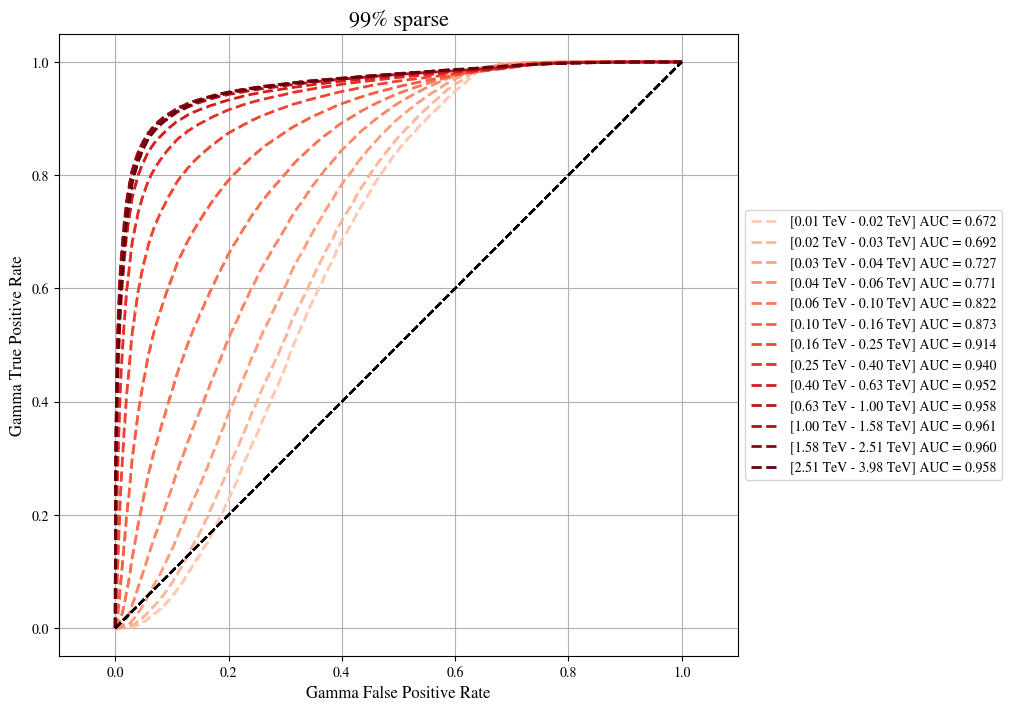

In [23]:
def plot_roc_gammaness_per_energy_perplot(true_energies_list, gammaness_list, true_type_list, titles_list, nbins=5):
    """
    Plot ROC curve of gammaness per energy for each model in a separate figure.
    Each figure contains ROC curves for different energy bins.
    Uses constrained layout and legend outside the plot.
    """
    bin = ctaplot.ana.ana.logspace_decades_nbin(0.01, 5, 5)
    bins = []
    for b in bin:
        bi = b*u.TeV
        bins.append(bi)

    nbins = len(bins) -1 
    # Get N distinct colors
    reds = plt.cm.Reds
    colors = [reds(0.2 + 0.8 * j / max(nbins-1, 1)) for j in range(nbins)]
  
    for i, (true_energies, gammaness, true_type) in enumerate(zip(true_energies_list, gammaness_list, true_type_list)):
        
        #colors = reds(0.5 + 1 * i / max(nbins-1, 1)) 
        print(colors)
        fig, ax = plt.subplots(figsize=(10, 7), layout='constrained')
                
        for j in range(nbins):
            ctaplot.plot_roc_curve_gammaness_per_energy(
                true_type, gammaness, true_energies,
                energy_bins=[bins[j], bins[j+1]],
                linestyle='--',
                gamma_label=1,
                alpha=1,
                linewidth=2,
                ax=ax,
                color=colors[j]
            )
        
      
        legend = ax.legend()
        legend_labels = [t.get_text() for t in legend.get_texts()]
        new_labels = []
        for j, old_label in enumerate(legend_labels):
            if j < len(bins) - 1:
                bin_low = bins[j]
                bin_high = bins[j+1]
                if "auc score =" in old_label.lower():
                    auc_value = old_label.split("=")[-1].strip()
                    new_labels.append(f"[{bin_low:.2f} - {bin_high:.2f}] AUC = {auc_value}")
                else:
                    new_labels.append(f"[{bin_low:.2f} - {bin_high:.2f}] AUC = N/A")
        # Place legend outside using constrained layout
        plt.legend(legend.get_lines(), new_labels, loc='center left', bbox_to_anchor=(1, 0.5), fontsize=10)
        plt.xlabel("Gamma False Positive Rate", fontsize=12)
        plt.ylabel("Gamma True Positive Rate", fontsize=12)
        plt.title(titles_list[i], fontsize=16)
        #fig.suptitle("ROC Curves", fontsize=24, y=0.99)
        plt.savefig(f"./Results/ROC_per_energy/roc_{titles_list[i].replace(' ', '_')}.png", dpi=300, bbox_inches='tight')
        plt.show()


plot_roc_gammaness_per_energy_perplot(true_energies_list, gammaness_list, true_type_list, all_titles, nbins=5)



ROC curves per sparsity for the full energy range

In [24]:
def plot_roc_gammaness(gammaness_list, true_type_list, all_labels):
    """
    Using ctaplot function: Plot ROC curve of gammaness.
    Parameters:
    labels (list): List of labels for each gammaness curve.
    gammaness_list (list): List of gammaness arrays to plot.
    true_type (np.ndarray): True type of the showers (1 for gamma, 0 for proton).
    """ 
    # Get N colors from Reds colormap
    n_models = len(all_labels)
    reds = plt.cm.Reds
    colors = [reds(0.3 + 0.7 * i / max(n_models-1, 1)) for i in range(n_models)]
    colors[0] = 'blue'
    plt.figure(figsize=(6, 6))
    for i, (gammaness, true_type, label) in enumerate(zip(gammaness_list, true_type_list, all_labels)):
        if 'Baseline' in label:
            width = 3
        else:
            width = 2
        ctaplot.plot_roc_curve_gammaness(true_type, gammaness,
                                        linestyle='--', 
                                        gamma_label=1,
                                        alpha=1,
                                        linewidth=width,
                                        color=colors[i])
    
          
        if label == "Baseline":
            line = plt.gca().lines[-1]
            line.set_linestyle('-')

    # Get the current legend and modify it
    legend = plt.legend()
    legend_labels = [t.get_text() for t in legend.get_texts()]
    
    # Create new labels combining model name with AUC score
    new_labels = []
    for title, old_label in zip(all_labels, legend_labels):
        new_labels.append(f"{title}: {old_label}")
    
    # Update the legend with new labels
    plt.legend(legend.get_lines(), new_labels, loc='lower right')
    
    #plt.xlim(-0.01, 1.2)
    #plt.ylim(-0.01, 1.05)
    plt.xlabel("Gamma False Positive Rate", fontsize= 14)
    plt.ylabel("Gamma True Positive Rate", fontsize= 14)

    plt.title("ROC Curves Comparison", fontsize = 18, y =1.01)
    #plt.tight_layout()
    plt.savefig(f"./Results/roc_integral.pdf", dpi=300, bbox_inches='tight')
    plt.show()

#plot_roc_gammaness([gammaness_orig, gammaness_pruning], [true_orig_type, true_pruning_type], ["Original", "Pruning"])   

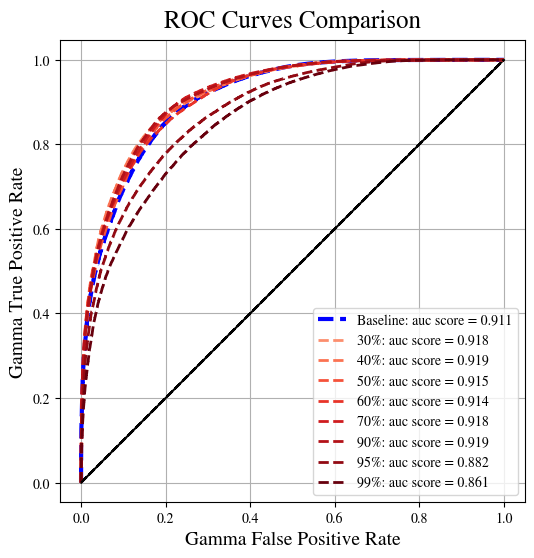

In [25]:
plot_roc_gammaness(gammaness_list, true_type_list, all_labels)

Compare the ROC curves for different sparsity levels for each energy bin

In [52]:
def plot_roc_per_energy_comparison(true_energies_list, gammaness_list, true_type_list, titles_list, all_labels):
    """
    Creates one plot per energy bin. Plots for all pruning percentages.
    """
    bins = ctaplot.ana.ana.logspace_decades_nbin(0.01, 5, 5)

    n_bins = len(bins) - 1 
    n_cols = 3
    n_rows = int(np.ceil(n_bins / n_cols))
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(19, 6 * n_rows))
    
    if n_rows == 1:
        axes = np.array([axes])
    axes = axes.flatten()
    
    # Get N colors from Reds colormap
    n_models = len(all_labels)
    reds = plt.cm.Reds
    colors = [reds(0.3 + 0.8 * i / max(n_models-1, 1)) for i in range(n_models)]

    
    for i, (bin_low, bin_high) in enumerate(zip(bins[:-1], bins[1:])):
        ax = axes[i]
        
        for j, (true_energies, gammaness, true_type, title) in enumerate(zip(true_energies_list, gammaness_list, true_type_list, titles_list)):
            # Filter events in this energy bin
            energy_mask = (true_energies >= bin_low*u.TeV) & (true_energies < bin_high*u.TeV)
            
            if np.sum(energy_mask) > 0:  # Only plot if there are events in this bin
                bin_true_type = true_type[energy_mask]
                bin_gammaness = gammaness[energy_mask]
                
                ctaplot.plot_roc_curve_gammaness(bin_true_type, bin_gammaness,
                                        linestyle='--',
                                        gamma_label=1,
                                        alpha=1,
                                        color = colors[j],
                                        linewidth=2,
                                        ax = ax)
    
                if label == "Baseline":
                    line = plt.gca().lines[-1]
                    line.set_linestyle('-')

                
        legend = ax.legend()
        legend_labels = [t.get_text() for t in legend.get_texts()]
    
        # New legend
        new_labels = []
        for title, old_label in zip(all_labels, legend_labels):
            new_labels.append(f"{title}: {old_label}")
        ax.legend(legend.get_lines(), new_labels)
        
        ax.set_title(f"Energy bin {bin_low:.2f}TeV- {bin_high:.2f}TeV", fontsize= 20)
        ax.set_xlabel('False Positive Rate', fontsize=16)
        ax.set_ylabel('True Positive Rate', fontsize=16)
        #ax.set_xlim(-0.05, 1.2)
        #ax.set_ylim(-0.05, 1.05)
    # Hide unused subplots
    for j in range(n_bins, len(axes)):
        axes[j].axis('off')
    plt.suptitle("ROC curves sparsity comparison per energy bin", fontsize = 24, y =1)
    plt.tight_layout(h_pad=2, w_pad=3)
    plt.show()



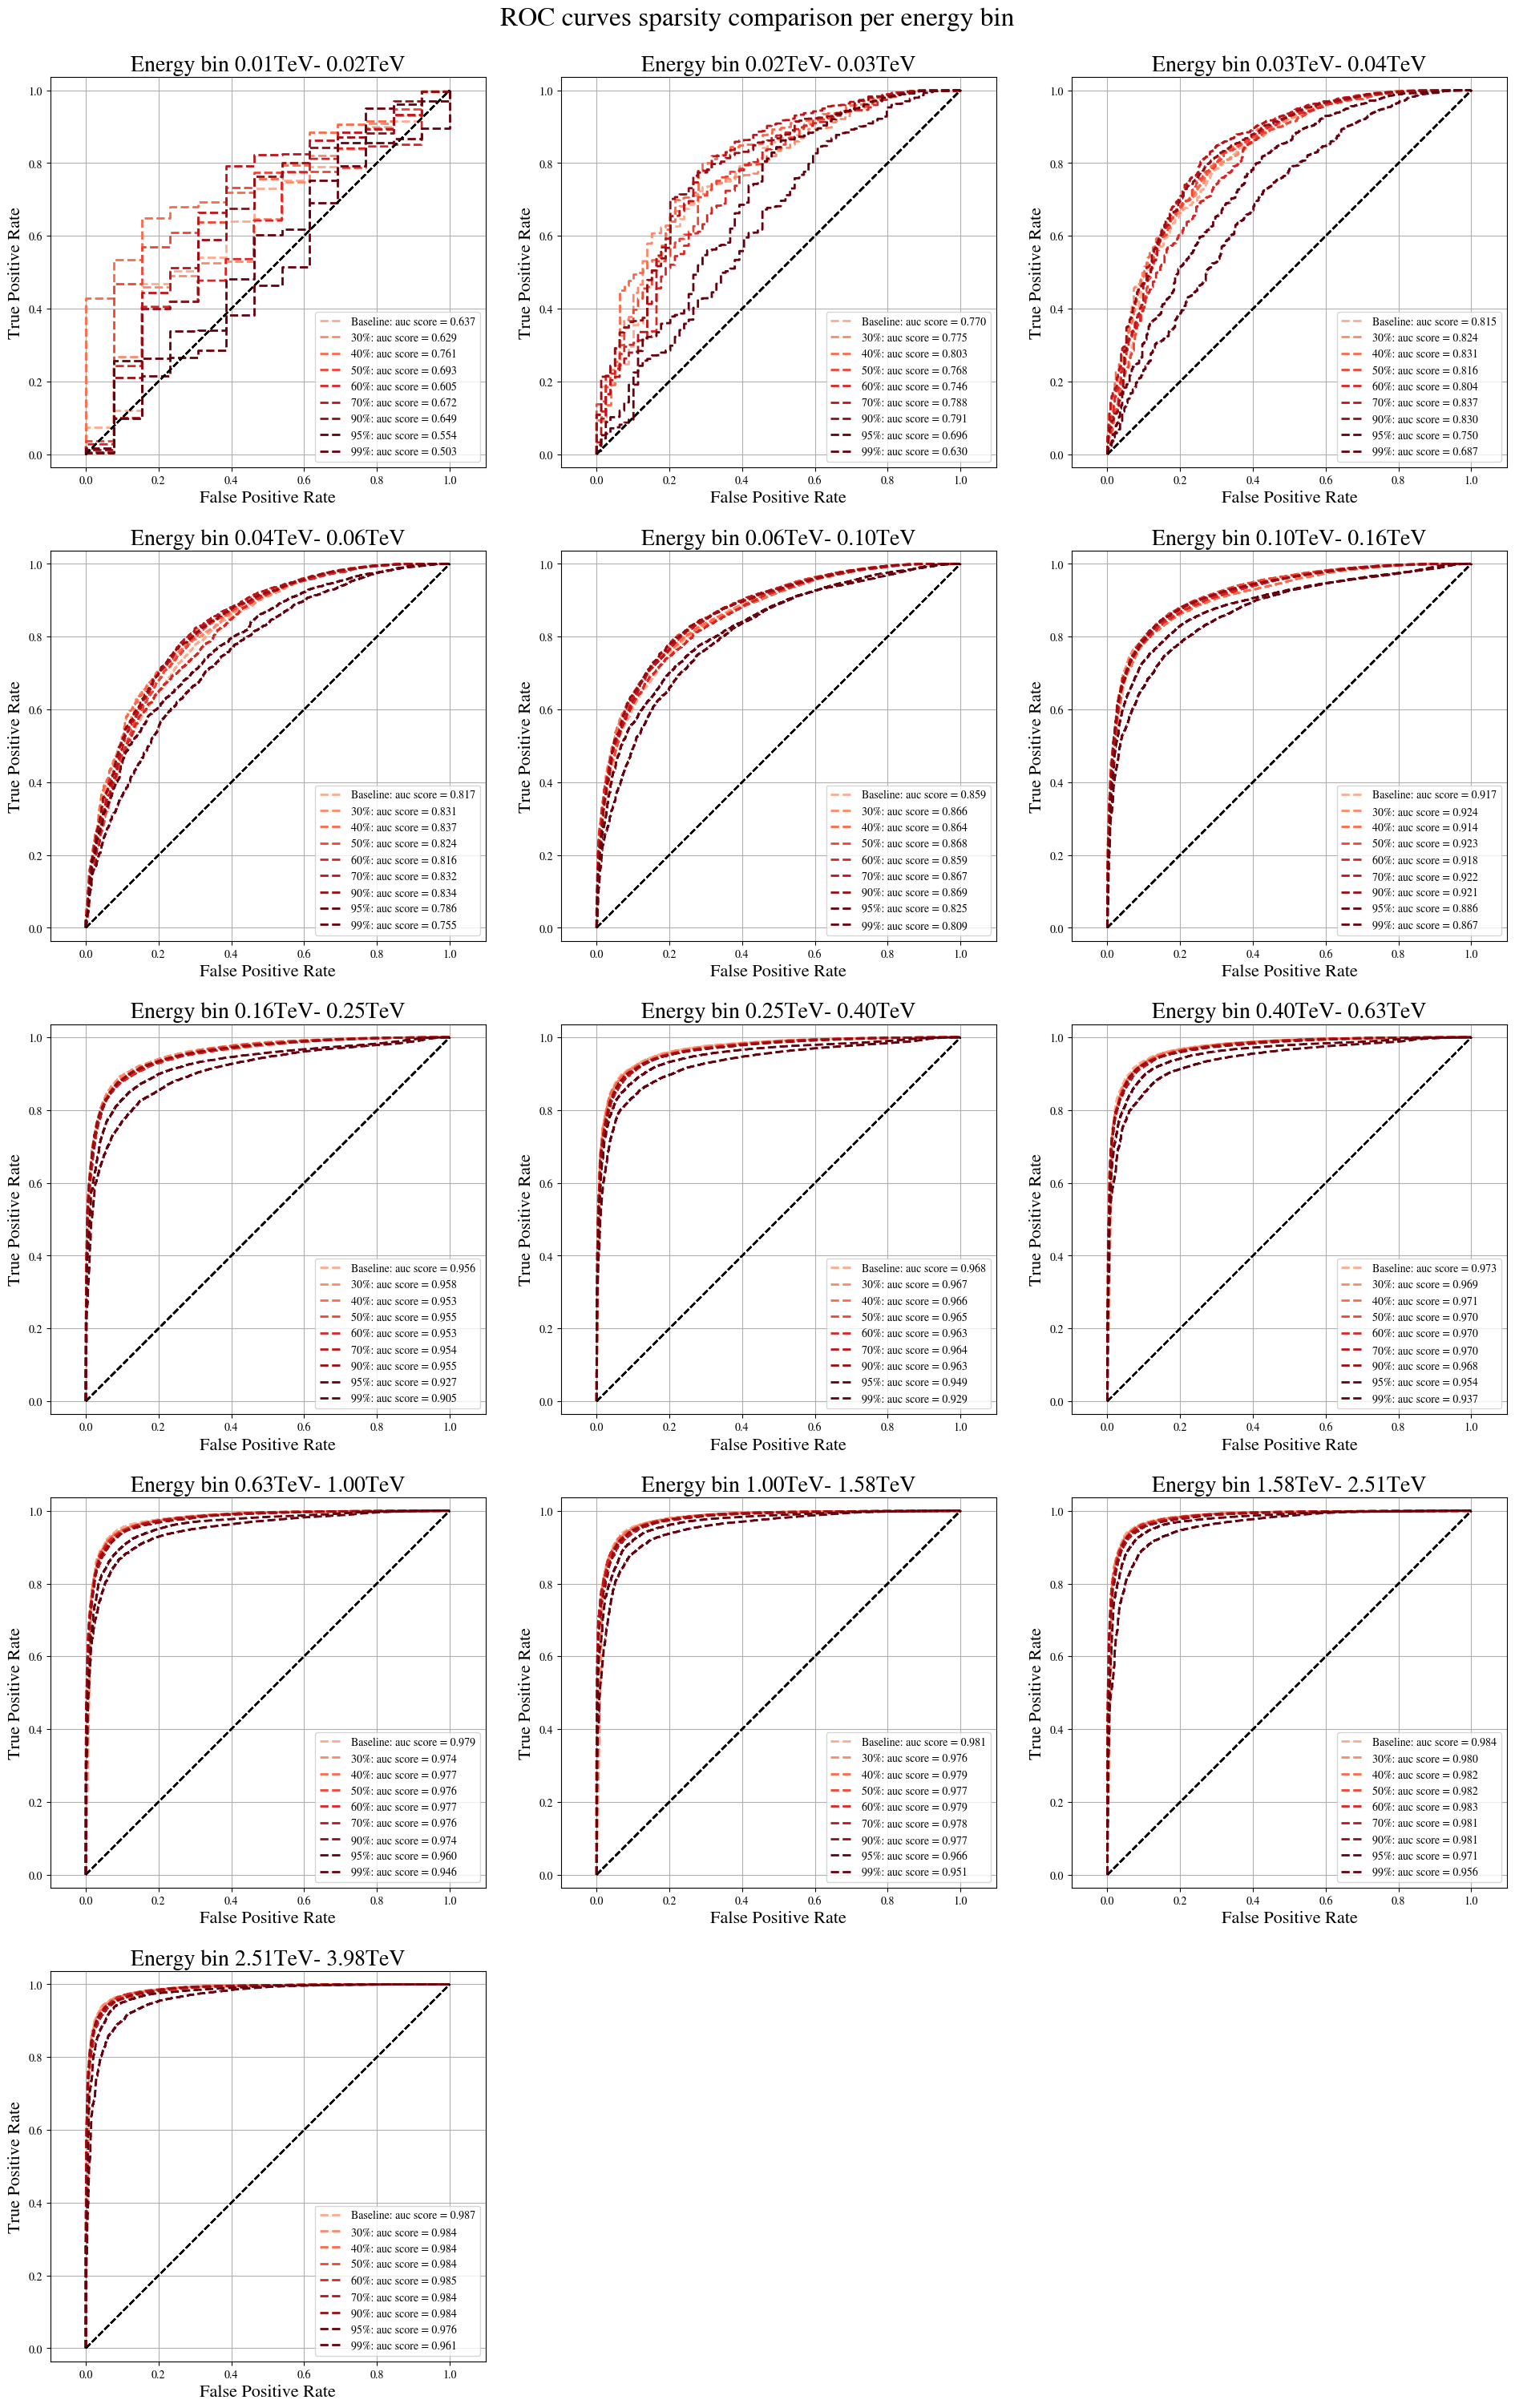

In [53]:
plot_roc_per_energy_comparison(true_energies_list, gammaness_list, true_type_list, all_titles, all_labels)

In [28]:
def plot_roc_per_energy_comparison_perplot(true_energies_list, gammaness_list, true_type_list, titles_list, all_labels):
    """
    Creates one plot per energy bin. Plots for all pruning percentages.
    """
    bins = ctaplot.ana.ana.logspace_decades_nbin(0.01, 5, 5)

    n_bins = len(bins) - 1 
    n_cols = 1
    n_rows = 1
    
    # Get N colors from Reds colormap
    n_models = len(all_labels)
    reds = plt.cm.Reds
    colors = [reds(0.2 + 0.7 * i / max(n_models-1, 1)) for i in range(n_models)]


    for i, (bin_low, bin_high) in enumerate(zip(bins[:-1], bins[1:])):
        fig, ax = plt.subplots(n_rows, n_cols, figsize=(6, 6 ), layout='constrained')

        
        for j, (true_energies, gammaness, true_type, title) in enumerate(zip(true_energies_list, gammaness_list, true_type_list, titles_list)):
            if "Baseline" in title:
                width = 3
                style = '-'
                colors[0] = 'blue'
            else:
                width = 2
                style = '--'
            # Filter events in this energy bin
            energy_mask = (true_energies >= bin_low*u.TeV) & (true_energies < bin_high*u.TeV)
            
            if np.sum(energy_mask) > 0:  # Only plot if there are events in this bin
                bin_true_type = true_type[energy_mask]
                bin_gammaness = gammaness[energy_mask]
                
                ctaplot.plot_roc_curve_gammaness(bin_true_type, bin_gammaness,
                                        linestyle=style,
                                        gamma_label=1,
                                        alpha=1,
                                        linewidth=width,
                                        color = colors[j],
                                        ax = ax)
                if title == "Baseline":
                    line = plt.gca().lines[-1]
                    line.set_linestyle('-')
                    #line.set_label(label)

        for line in ax.lines:
            x, y = line.get_data()
            if np.allclose(x, y):
                line.set_linestyle('--')
                line.set_color('gray')
                line.set_linewidth(1)

        legend = plt.legend()
        legend_labels = [t.get_text() for t in legend.get_texts()]
    
        # New legend
        new_labels = []
        for title, old_label in zip(all_labels, legend_labels):
            new_labels.append(f"{title}: {old_label}")
        #plt.legend(legend.get_lines(), new_labels, loc='center right', bbox_to_anchor=(-0.1, 0.5), fontsize=14)
        plt.legend(legend.get_lines(), new_labels, loc='center right', bbox_to_anchor=(1, 0.15), fontsize=14)
        plt.title(f"Energy bin {bin_low:.2f}TeV- {bin_high:.2f}TeV", fontsize= 20)
        plt.xlabel('False Positive Rate', fontsize=16)
        plt.ylabel('True Positive Rate', fontsize=16)
        #ax.set_xlim(-0.05, 1.2)
        #ax.set_ylim(-0.05, 1.05)
    # Hide unused subplots
        
        plt.savefig(f"./Results/Roc_sparsity/Roc_{bin_low:.2f}TeV_{bin_high:.2f}TeV.png", dpi=300, bbox_inches='tight')
    
    plt.suptitle("ROC curves sparsity comparison per energy bin", fontsize = 24, y =1)
    #plt.tight_layout(h_pad=2, w_pad=3)
    #lt.savefig(f"./Results/Roc.pdf", dpi=300, bbox_inches='tight')
    plt.show()



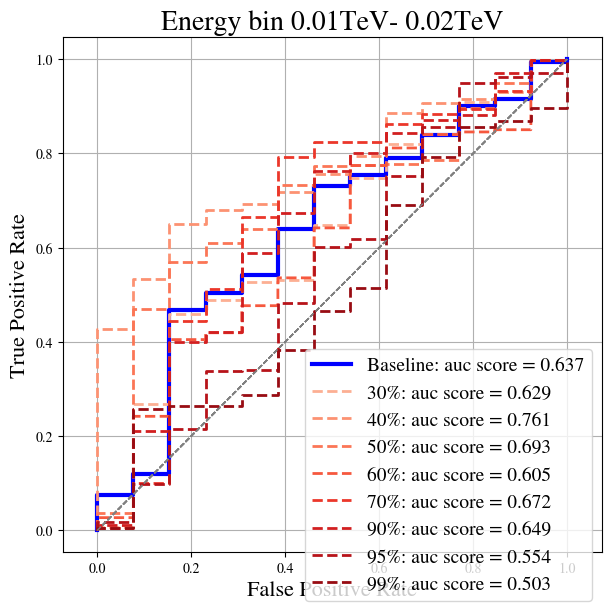

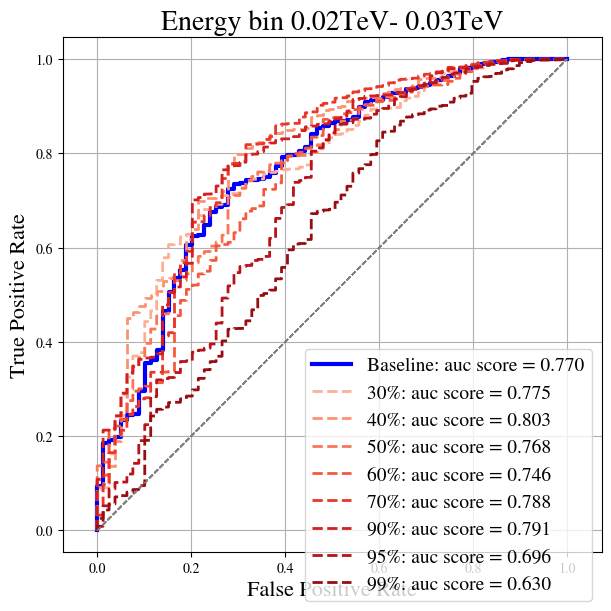

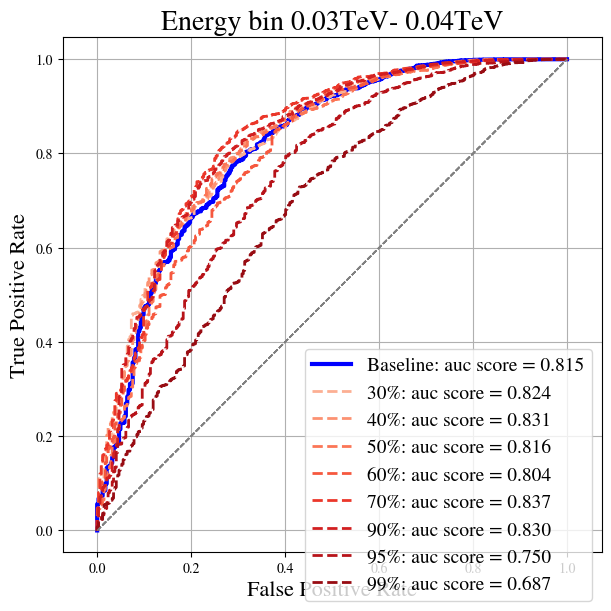

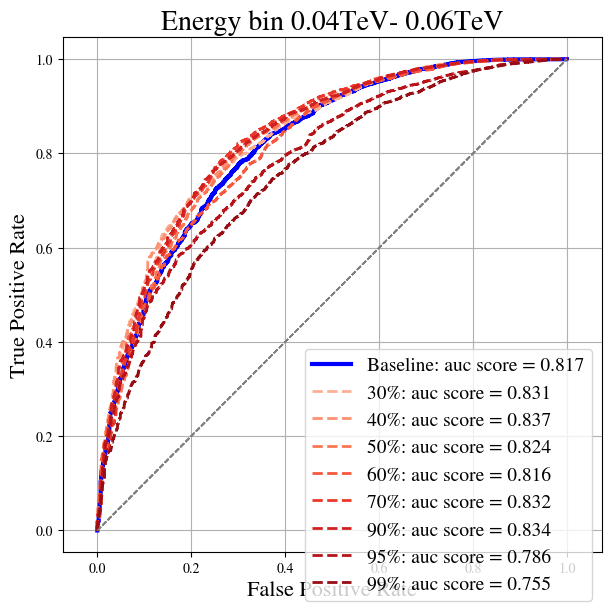

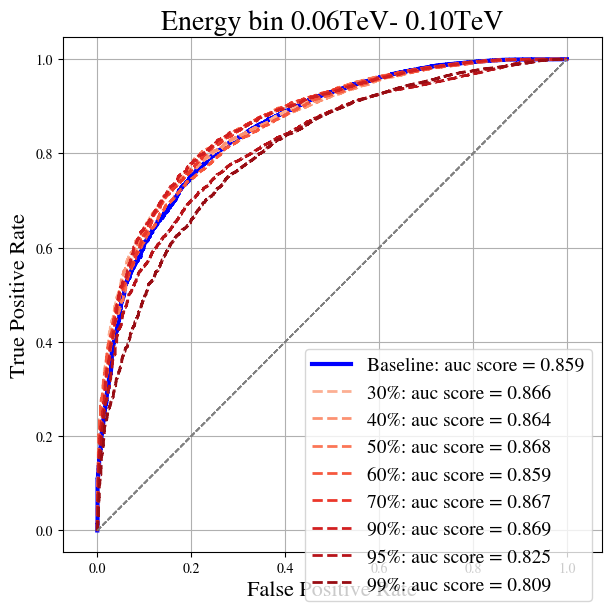

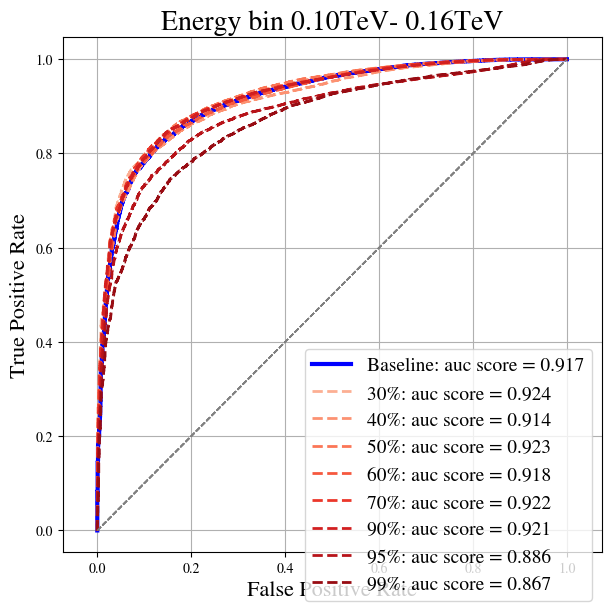

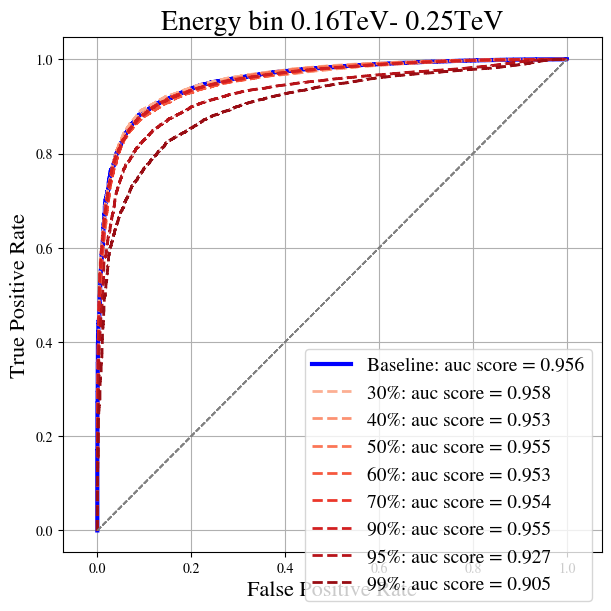

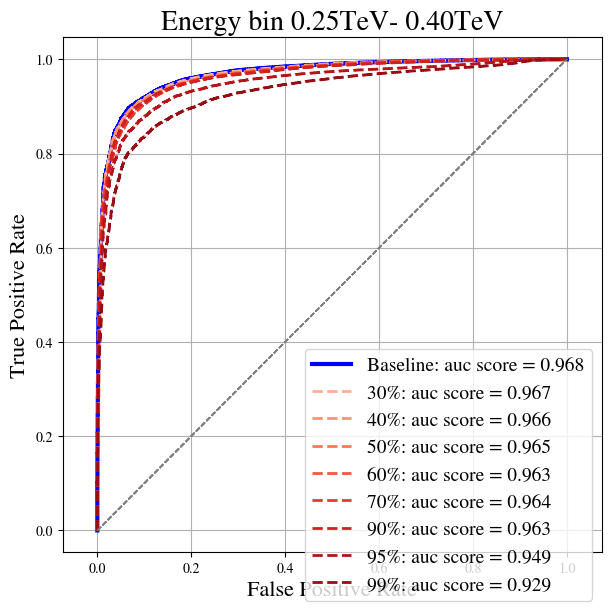

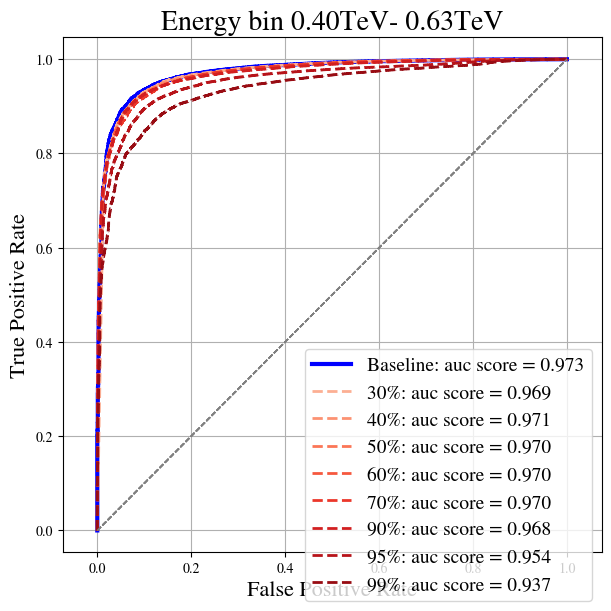

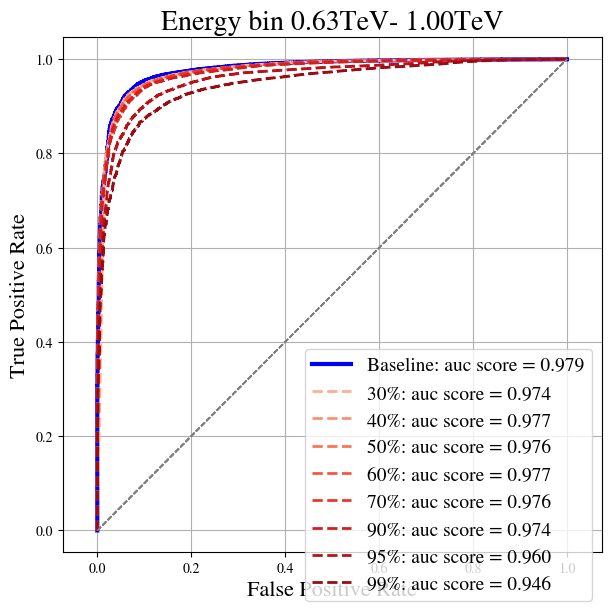

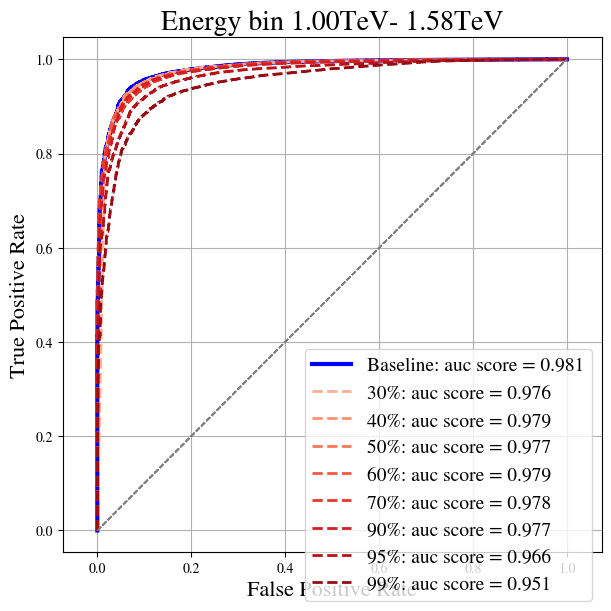

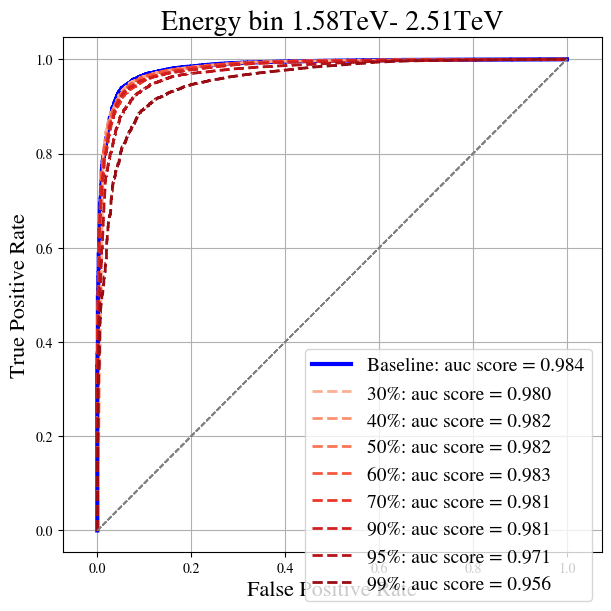

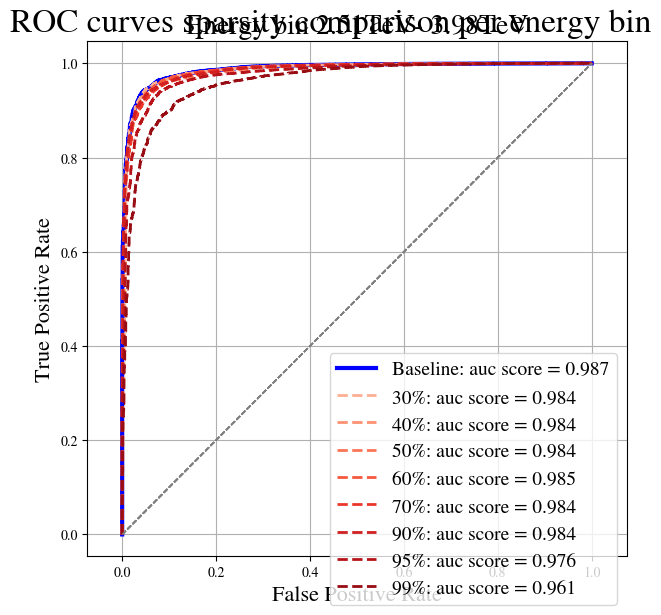

In [29]:
plot_roc_per_energy_comparison_perplot(true_energies_list, gammaness_list, true_type_list, all_titles, all_labels)

Class separation for different sparsity objectives

In [30]:

def gammaness_distribution_per_energy_comparison(true_energies_list, gammaness_list, true_type_list, titles_list, all_labels, n_energy_bin_edges=5):
    """
    Plot gammaness distributions per energy bin for several experiments.
    Gamma -> solid line, Proton -> dashed line.
    One color per experiment (CUSTOM_COLORS).
    Single legend per subplot:
      - Line styles (Gamma vs Proton)
      - Experiment colors (all_labels)
    """

    # Energy bins
    bins = ctaplot.ana.ana.logspace_decades_nbin(0.01, 5, n_energy_bin_edges)
    n_bins = len(bins) - 1
    n_cols = 3
    n_rows = int(np.ceil(n_bins / n_cols))

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 6 * n_rows))
    axes = np.array(axes).flatten()

    # Get N colors from Reds colormap
    n_models = len(all_labels)
    reds = plt.cm.Reds
    colors = [reds(0.3 + 0.7 * i / max(n_models-1, 1)) for i in range(n_models)]


    for i, (bin_low, bin_high) in enumerate(zip(bins[:-1], bins[1:])):
        ax = axes[i]

        for j, (true_energies, gammaness, true_type, label) in enumerate(
            zip(true_energies_list, gammaness_list, true_type_list, all_labels)
        ):
            # Select events in current bin
            mask = (true_energies >= bin_low * u.TeV) & (true_energies < bin_high * u.TeV)
            if np.sum(mask) == 0:
                continue

            bin_true_type = true_type[mask]
            bin_gammaness = gammaness[mask]

            # Gamma (solid)
            gamma_mask = bin_true_type == 1
            if np.any(gamma_mask):
                ctaplot.plot_gammaness_distribution(
                    bin_true_type[gamma_mask],
                    bin_gammaness[gamma_mask],
                    bins=20,
                    density=True,
                    histtype="step",
                    linewidth=2,
                    ax=ax,
                    color=colors[j],
                    linestyle="-",
                )

            # Proton (dashed)
            proton_mask = bin_true_type == 0
            if np.any(proton_mask):
                ctaplot.plot_gammaness_distribution(
                    bin_true_type[proton_mask],
                    bin_gammaness[proton_mask],
                    bins=20,
                    density=True,
                    histtype="step",
                    linewidth=2,
                    ax=ax,
                    color=colors[j],
                    linestyle=":",
                )

        ax.set_title(f"{bin_low:.2f}-{bin_high:.2f} TeV", fontsize=16)
        ax.set_xlim(0, 1)
        ax.set_xlabel("Gammaness", fontsize=14)
        ax.set_ylabel("Density (a.u.)", fontsize=14)
        ax.grid(True, alpha=0.3)

        # Build legend 
        style_handles = [
            Line2D([0], [0], color="k", linestyle="-", lw=2, label="Gamma"),
            Line2D([0], [0], color="k", linestyle=":", lw=2, label="Proton"),
        ]
        experiment_handles = [
            Patch(facecolor=colors[j], edgecolor="k", label=all_labels[j])
            for j in range(len(all_labels))
        ]
        handles = style_handles + experiment_handles
        ax.legend(handles=handles, fontsize=12, loc='best')
    fig.suptitle("Gammaness Distribution Comparison per Energy Bin", fontsize=24, y=1)
    
    # Hide unused subplots
    for j in range(n_bins, len(axes)):
        axes[j].axis("off")

    plt.tight_layout(h_pad=2, w_pad=3)
    plt.show()


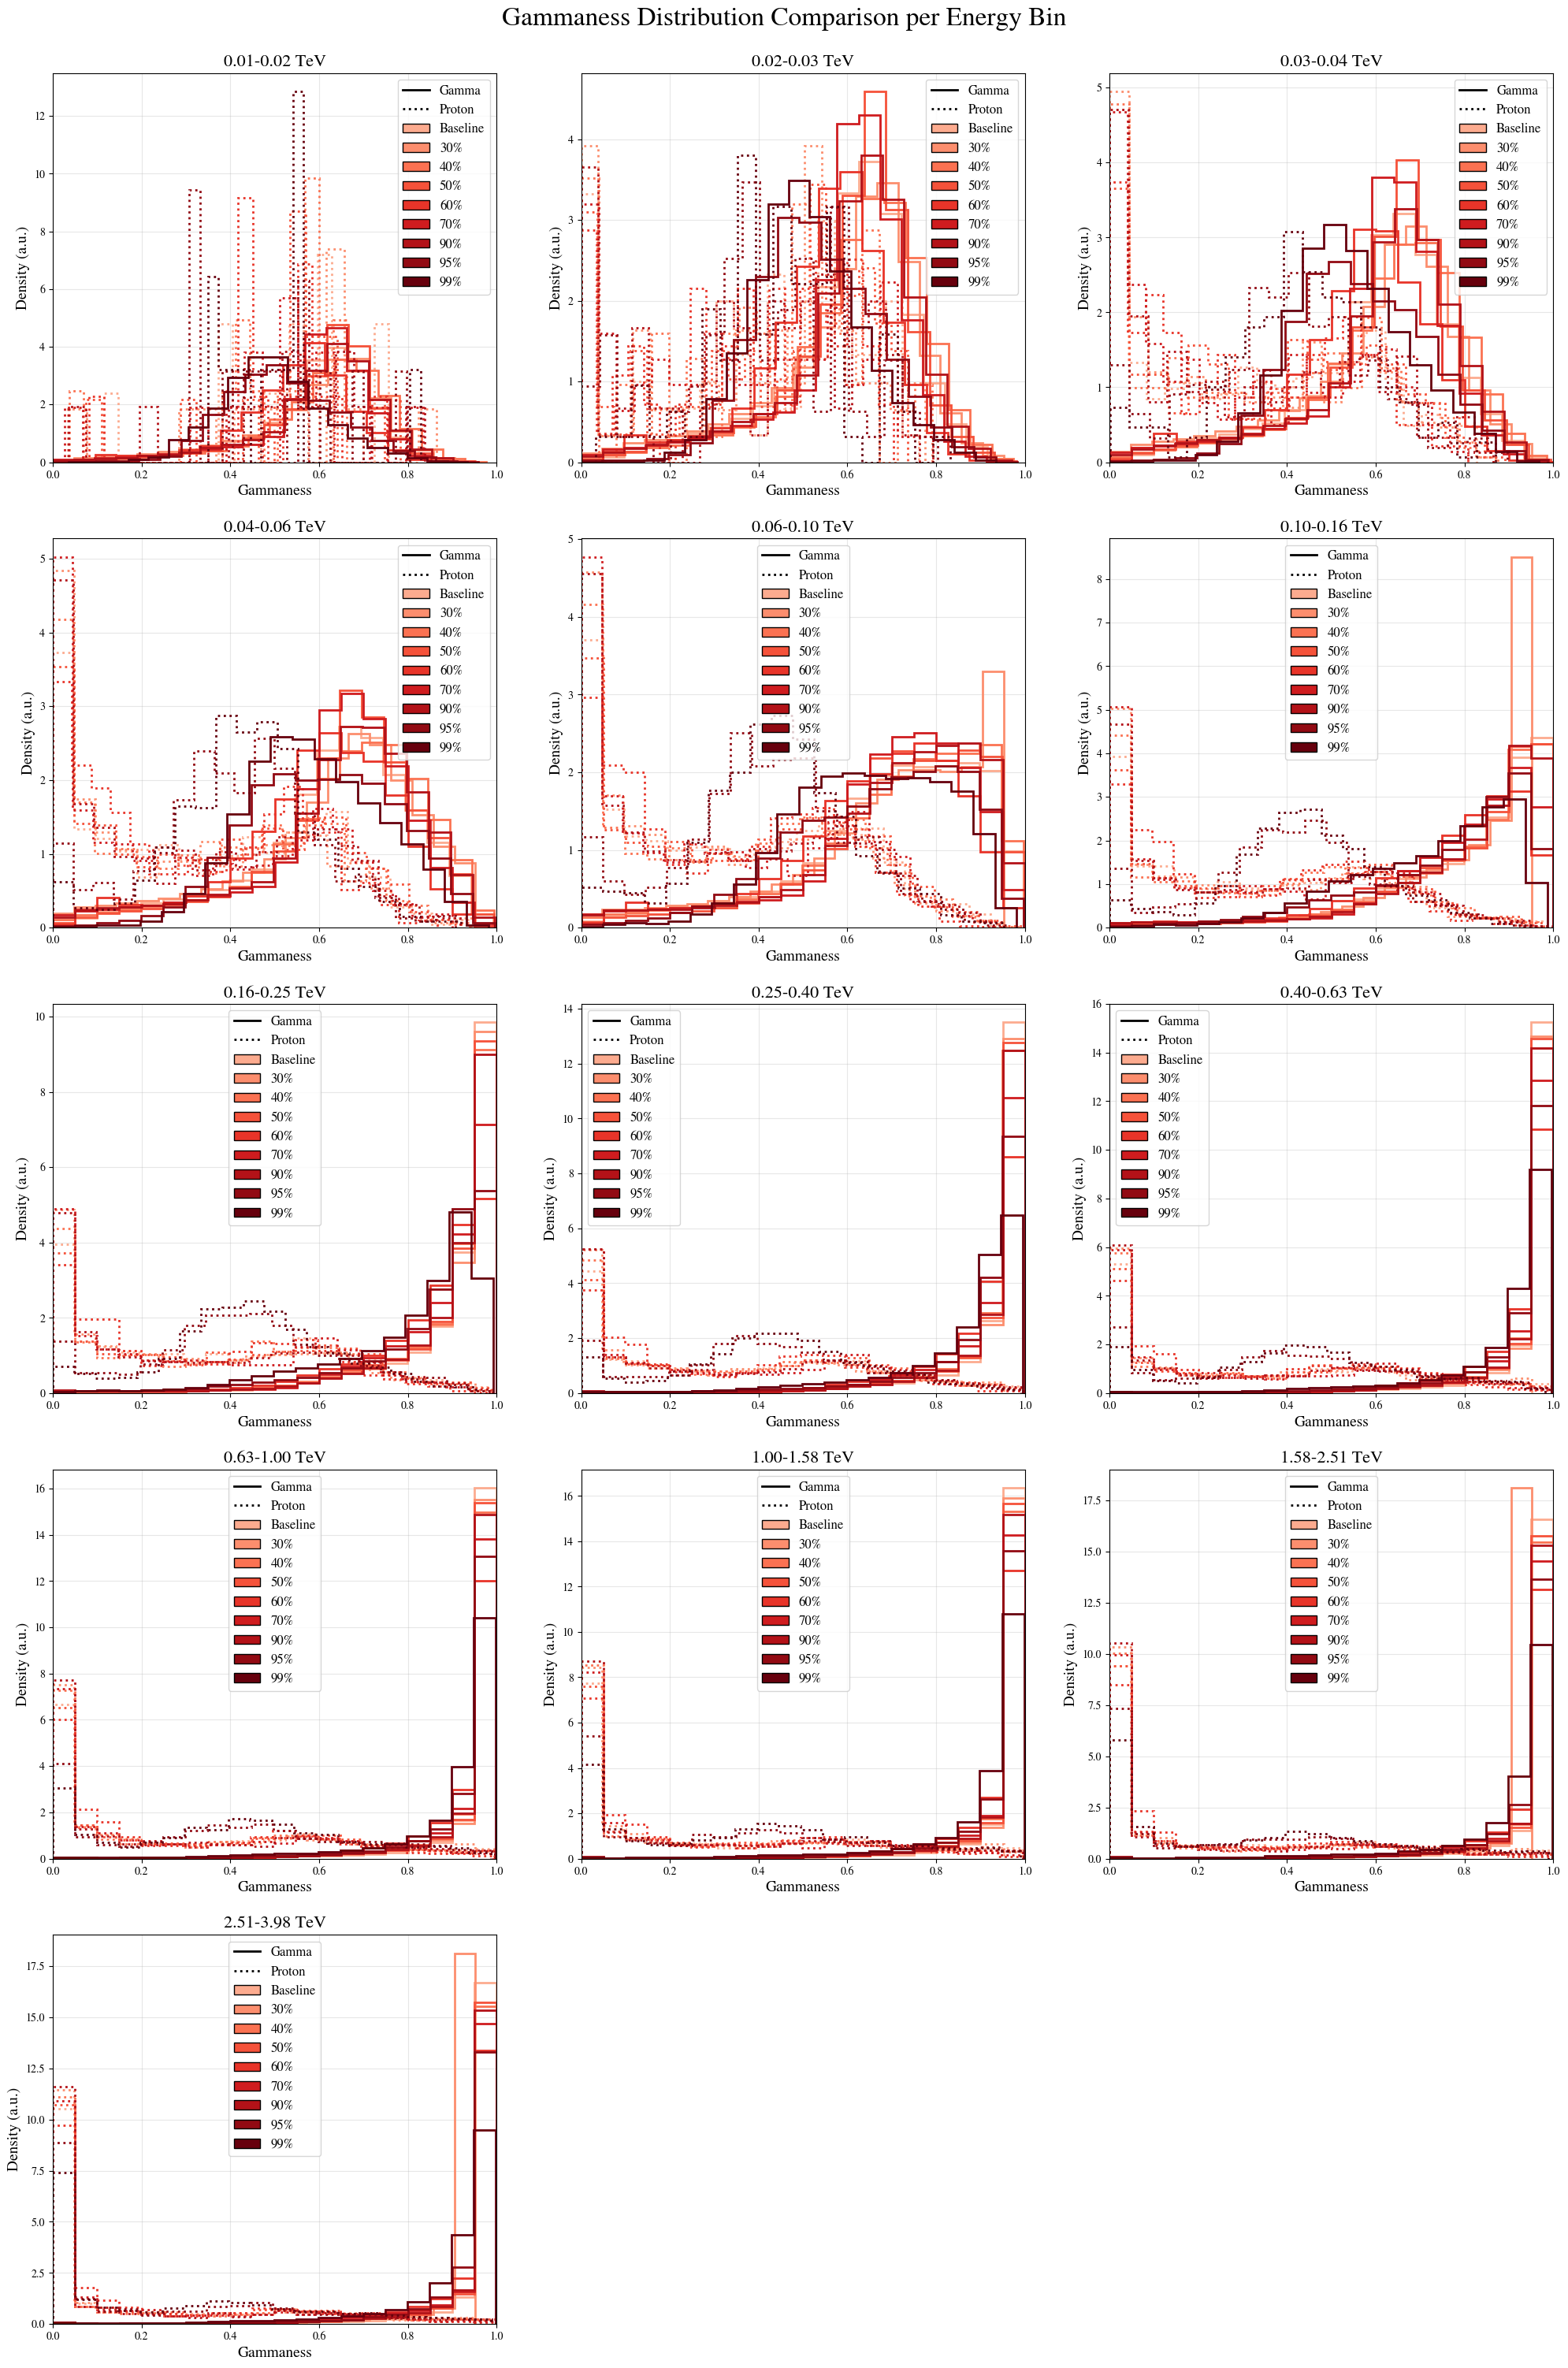

In [31]:
gammaness_distribution_per_energy_comparison(true_energies_list, gammaness_list, true_type_list, all_titles, all_labels)

In [32]:

def gammaness_distribution_comparison(true_energies_list, gammaness_list, true_type_list, titles_list, all_labels, n_energy_bin_edges=5):
    """
    Plot gammaness distributions per energy bin for several experiments.
    Gamma -> solid line, Proton -> dashed line.
    One color per experiment (CUSTOM_COLORS).
    Single legend per subplot:
      - Line styles (Gamma vs Proton)
      - Experiment colors (all_labels)
    """

    # Energy bins
    bins = ctaplot.ana.ana.logspace_decades_nbin(0.01, 5, n_energy_bin_edges)
    n_bins = len(bins) - 1
    n_cols = 1
    n_rows = 1

    # Get N colors from Reds colormap
    n_models = len(all_labels)
    reds = plt.cm.Reds
    colors = [reds(0.3 + 0.7 * i / max(n_models-1, 1)) for i in range(n_models)]

    

    fig, ax = plt.subplots(n_rows, n_cols, figsize=(8, 6 ), layout='constrained')
    
    for j, (true_energies, gammaness, true_type, label) in enumerate(
            zip(true_energies_list, gammaness_list, true_type_list, all_labels)
        ):
        # Select events in current bin
            
        if label == "Baseline":
                width = 2
                colors[0] = 'blue'
        else:
                width = 2
        bin_true_type = true_type
        bin_gammaness = gammaness

        # Gamma (solid)
        gamma_mask = bin_true_type == 1
        if np.any(gamma_mask):
            ctaplot.plot_gammaness_distribution(
                    bin_true_type[gamma_mask],
                    bin_gammaness[gamma_mask],
                    bins=20,
                    density=True,
                    histtype="step",
                    linewidth=width,
                    ax=ax,
                    color=colors[j],
                    #color=CUSTOM_COLORS[j],
                    linestyle="-",
                )

        # Proton (dashed)
        proton_mask = bin_true_type == 0
        if np.any(proton_mask):
            ctaplot.plot_gammaness_distribution(
                    bin_true_type[proton_mask],
                    bin_gammaness[proton_mask],
                    bins=20,
                    density=True,
                    histtype="step",
                    linewidth=2,
                    ax=ax,
                    color=colors[j],
                    linestyle=":",
                )

        plt.xlim(0, 1)
        plt.xlabel("Gammaness", fontsize=14)
        plt.ylabel("Density (a.u.)", fontsize=14)
        plt.grid(True, alpha=0.3)

        # Build legend 
        style_handles = [
            Line2D([0], [0], color="k", linestyle="-", lw=2, label="Gamma"),
            Line2D([0], [0], color="k", linestyle=":", lw=2, label="Proton"),
        ]
        experiment_handles = [
            Patch(facecolor=colors[j], edgecolor="k", label=all_labels[j])
            for j in range(len(all_labels))
        ]
        handles = style_handles + experiment_handles
        plt.legend(handles=handles, fontsize=12,loc='center right', bbox_to_anchor=(-0.1, 0.5))
        plt.title("Gammaness Distribution per particle type", fontsize=24, y=1)


    #plt.tight_layout(h_pad=2, w_pad=3)
    plt.savefig(f"./Results/roc_gammaness_integral.pdf", dpi=300, bbox_inches='tight')
    plt.show()


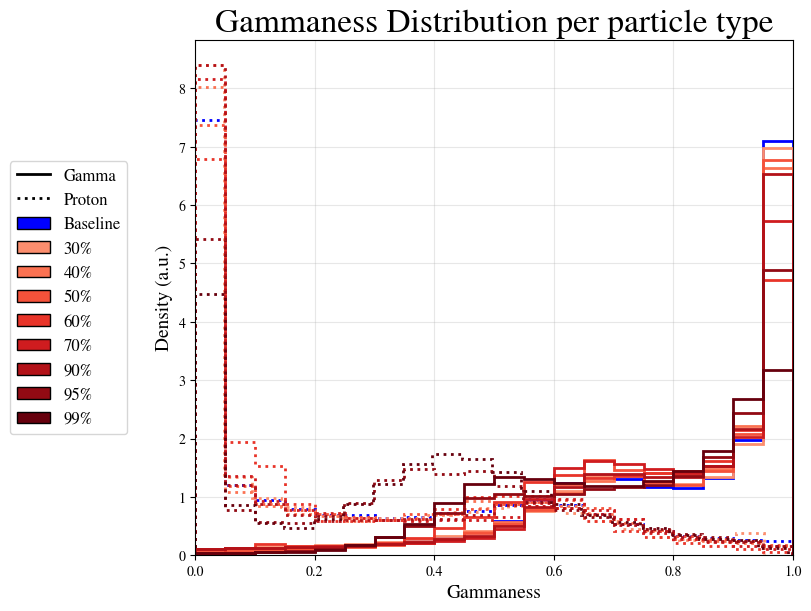

In [33]:
gammaness_distribution_comparison(true_energies_list, gammaness_list, true_type_list, all_titles, all_labels)

In [34]:

def gammaness_distribution_per_energy_comparison_perplot(true_energies_list, gammaness_list, true_type_list, titles_list, all_labels, n_energy_bin_edges=5):
    """
    Plot gammaness distributions per energy bin for several experiments.
    Gamma -> solid line, Proton -> dashed line.
    One color per experiment (CUSTOM_COLORS).
    Single legend per subplot:
      - Line styles (Gamma vs Proton)
      - Experiment colors (all_labels)
    """

    # Energy bins
    bins = ctaplot.ana.ana.logspace_decades_nbin(0.01, 5, n_energy_bin_edges)
    n_bins = len(bins) - 1
    n_cols = 1
    n_rows = 1

    # Get N colors from Reds colormap
    n_models = len(all_labels)
    reds = plt.cm.Reds
    colors = [reds(0.3 + 0.7 * i / max(n_models-1, 1)) for i in range(n_models)]

   
    
    for i, (bin_low, bin_high) in enumerate(zip(bins[:-1], bins[1:])):
       
        fig, ax = plt.subplots(n_rows, n_cols, figsize=(8, 6 ), layout='constrained')
    
        for j, (true_energies, gammaness, true_type, label) in enumerate(
            zip(true_energies_list, gammaness_list, true_type_list, all_labels)
        ):
            # Select events in current bin
            mask = (true_energies >= bin_low * u.TeV) & (true_energies < bin_high * u.TeV)
            if np.sum(mask) == 0:
                continue

            bin_true_type = true_type[mask]
            bin_gammaness = gammaness[mask]
            if label == "Baseline":
                    width = 2.5
                    colors[0] = 'blue'
            else:
                    width = 2
            # Gamma (solid)
            gamma_mask = bin_true_type == 1
            if np.any(gamma_mask):
                ctaplot.plot_gammaness_distribution(
                    bin_true_type[gamma_mask],
                    bin_gammaness[gamma_mask],
                    bins=20,
                    density=True,
                    histtype="step",
                    linewidth=width,
                    ax=ax,
                    color=colors[j],
                    linestyle="-",
                )

            # Proton (dashed)
            proton_mask = bin_true_type == 0
            if np.any(proton_mask):
                ctaplot.plot_gammaness_distribution(
                    bin_true_type[proton_mask],
                    bin_gammaness[proton_mask],
                    bins=20,
                    density=True,
                    histtype="step",
                    linewidth=width,
                    ax=ax,
                    color=colors[j],
                    linestyle=":",
                )


        plt.title(f"{bin_low:.2f}-{bin_high:.2f} TeV", fontsize=16)
        plt.xlim(0, 1)
        plt.xlabel("Gammaness", fontsize=14)
        plt.ylabel("Density (a.u.)", fontsize=14)
        plt.grid(True, alpha=0.3)

       
        # Build legend 
        style_handles = [
            Line2D([0], [0], color="k", linestyle="-", lw=2, label="Gamma"),
            Line2D([0], [0], color="k", linestyle=":", lw=2, label="Proton"),
            ]
        experiment_handles = [
            Patch(facecolor=colors[j], edgecolor="k", label=all_labels[j])
            for j in range(len(all_labels))
        ]
        handles = style_handles + experiment_handles
        plt.legend(handles=handles, fontsize=12,loc='center right', bbox_to_anchor=(-0.1, 0.5))
        fig.suptitle("Gammaness Distribution Comparison per Energy Bin", fontsize=24, y=1)
    
   
        plt.tight_layout(h_pad=2, w_pad=3)
        plt.savefig(f"./Results/gammaness_energy/roc_gammaness_{bin_low:.2f}-{bin_high:.2f}.png", dpi=300, bbox_inches='tight')
        plt.show()


/tmp/ucm1478/ipykernel_3335962/2053882532.py:95: UserWarning: The figure layout has changed to tight
  plt.tight_layout(h_pad=2, w_pad=3)


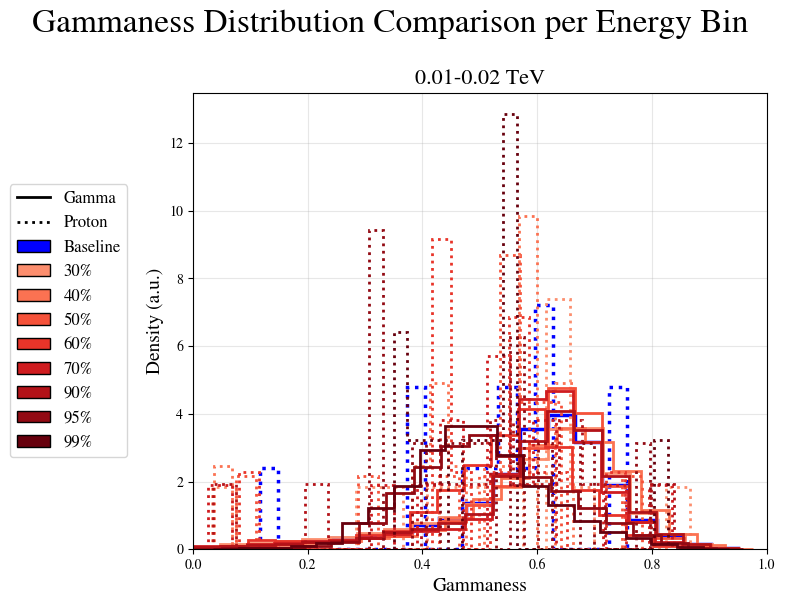

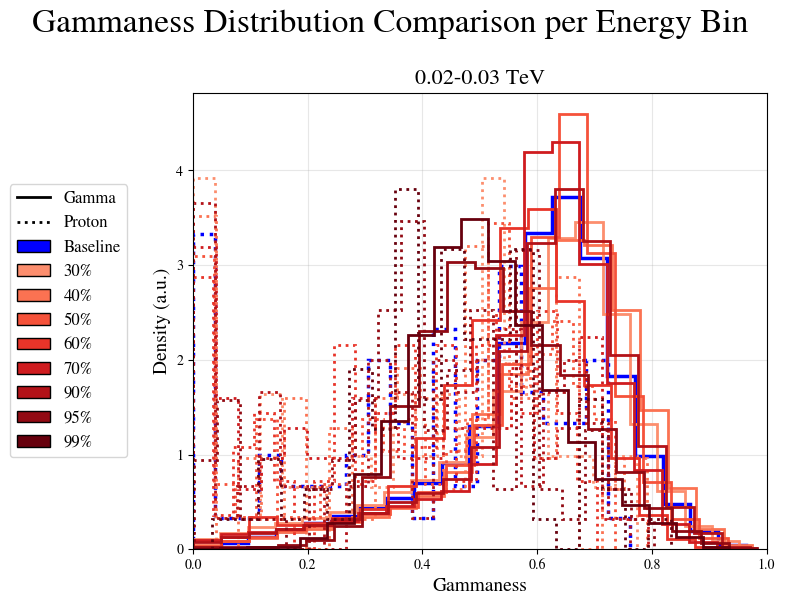

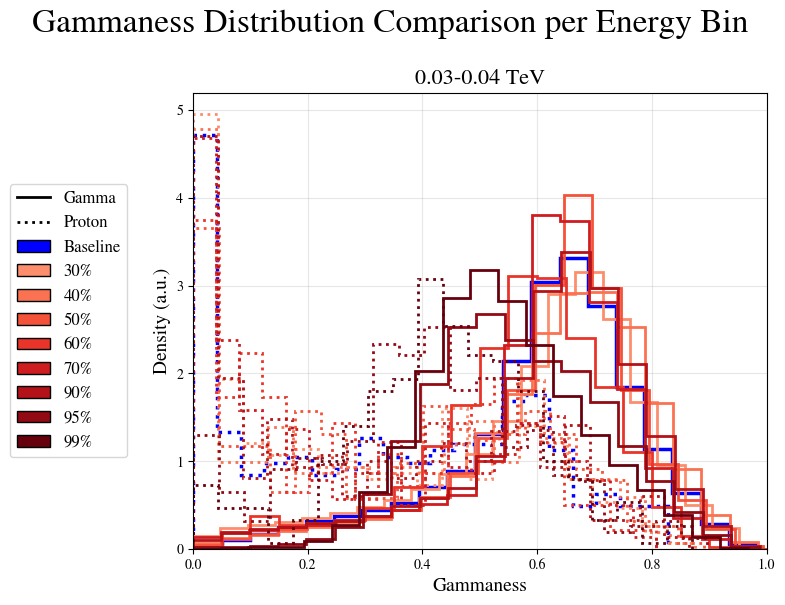

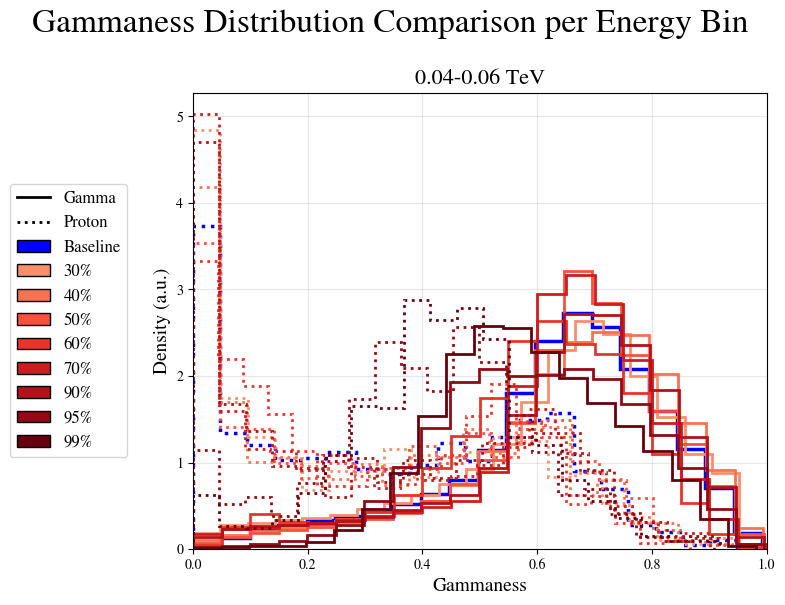

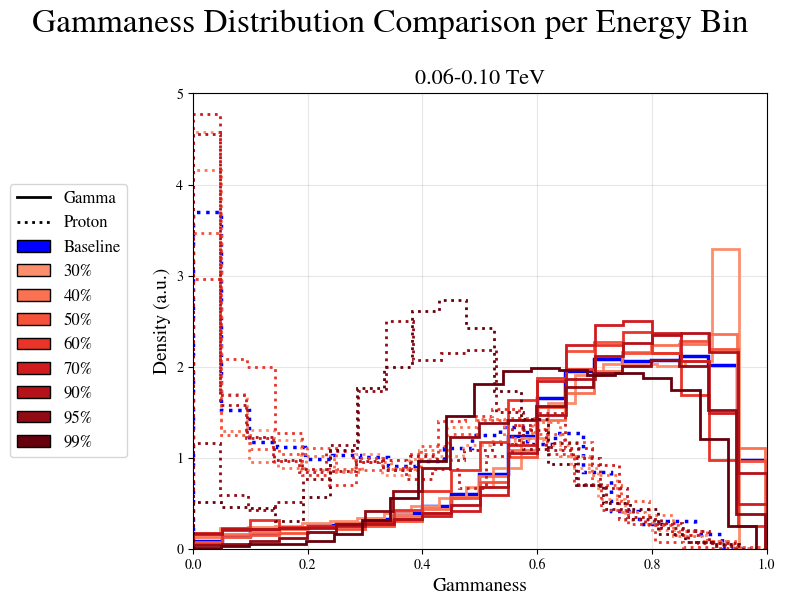

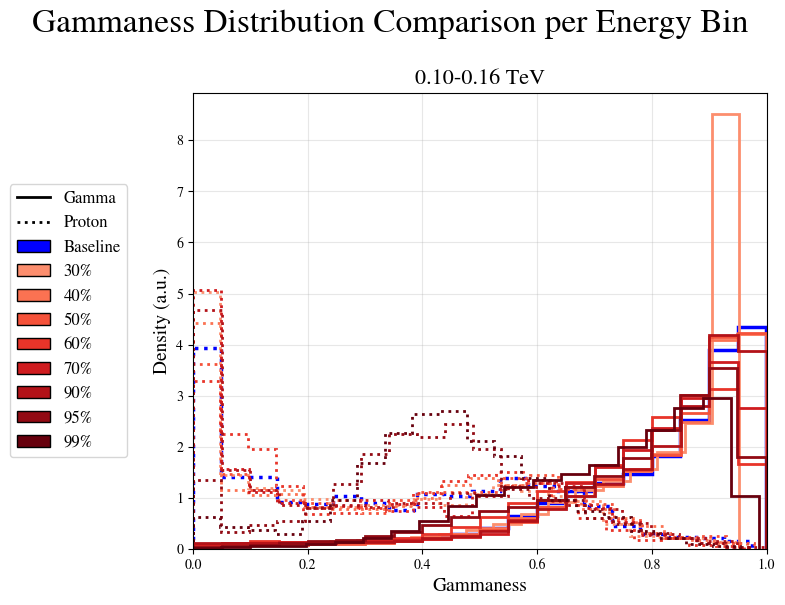

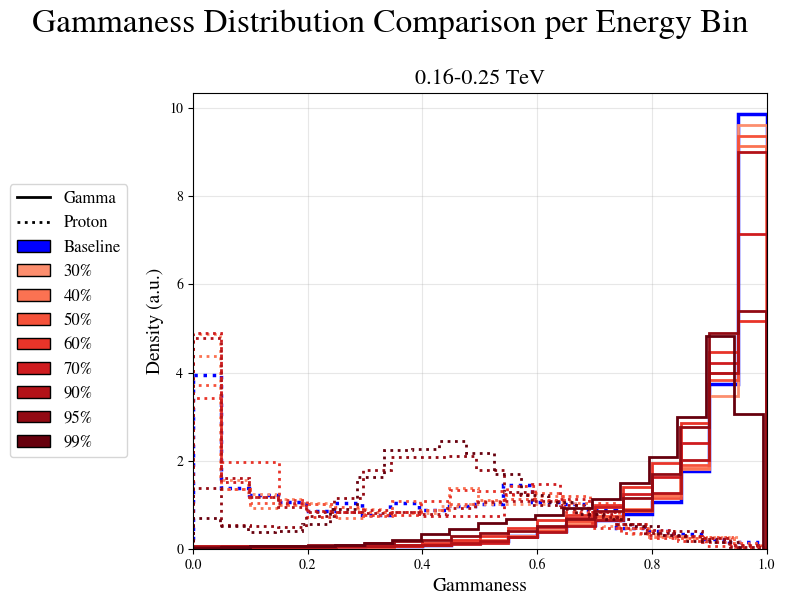

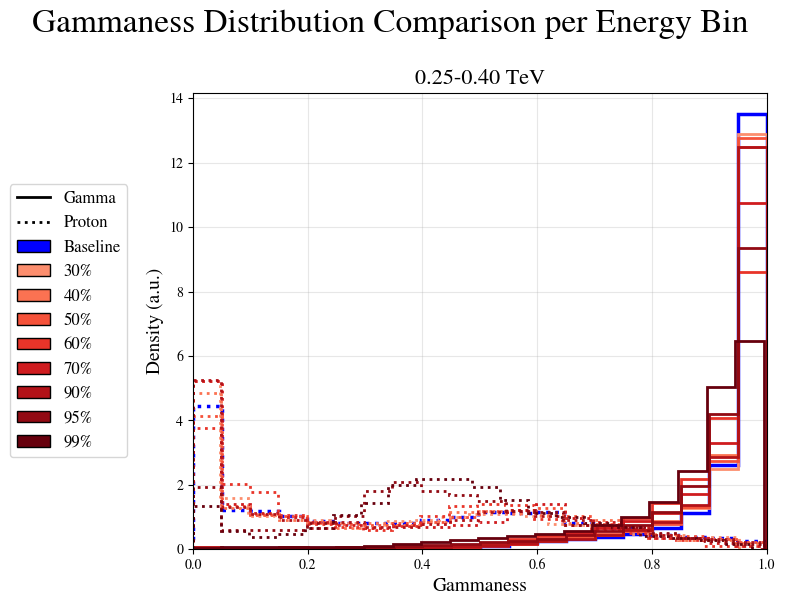

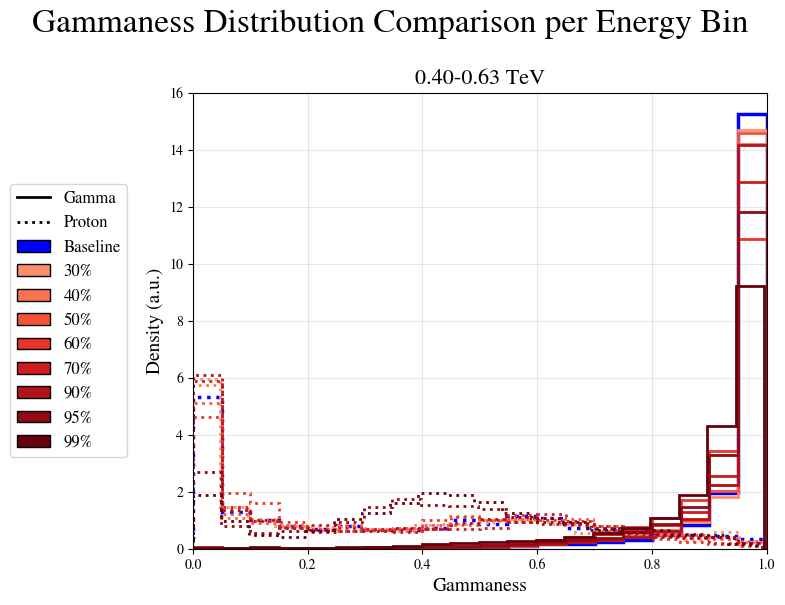

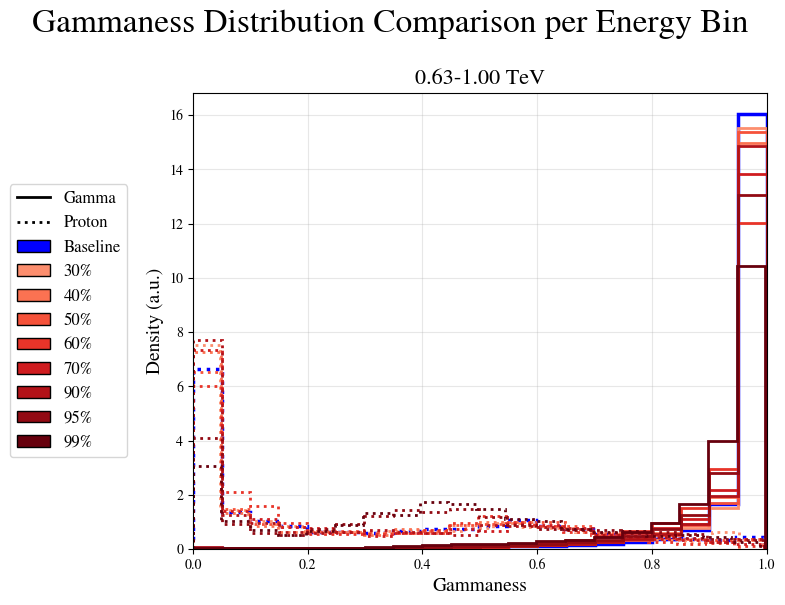

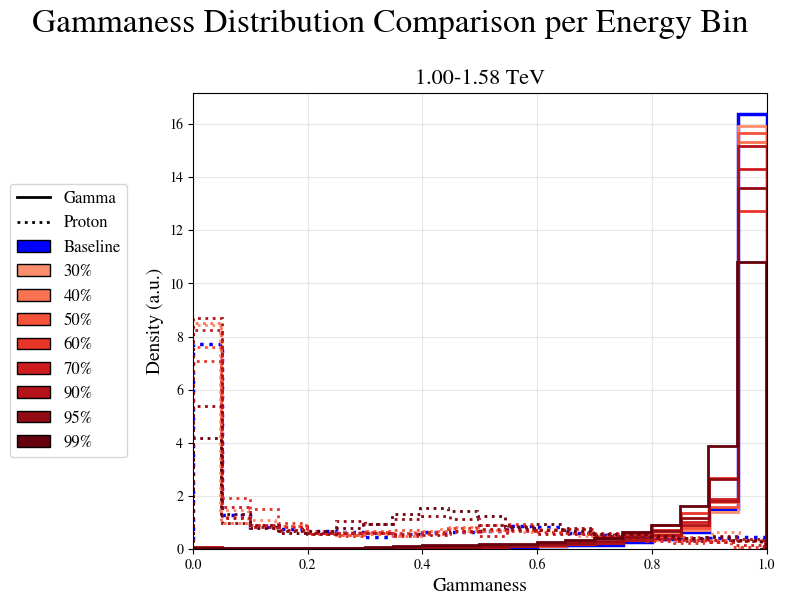

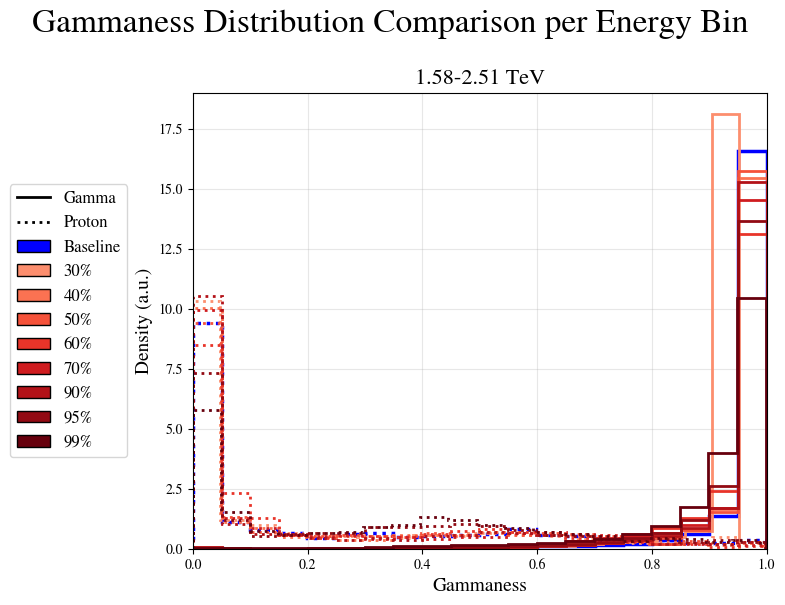

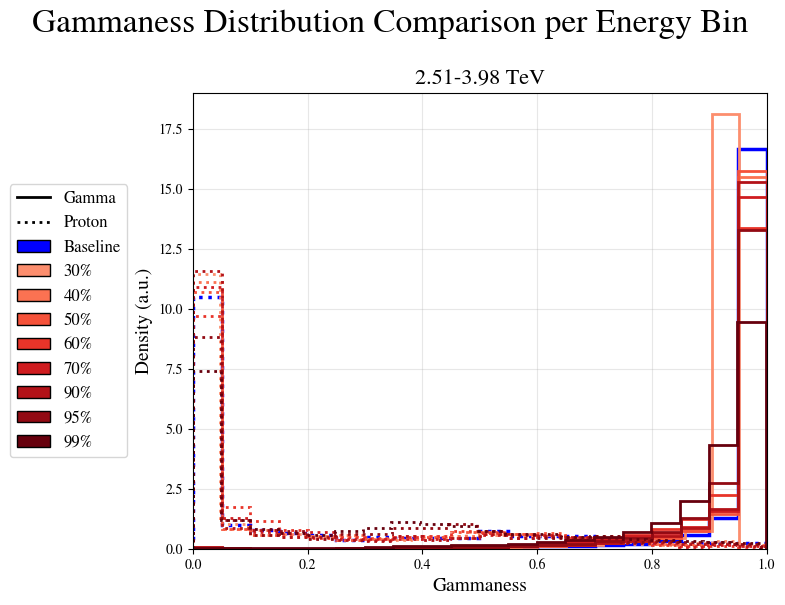

In [35]:
gammaness_distribution_per_energy_comparison_perplot(true_energies_list, gammaness_list, true_type_list, all_titles, all_labels)

In [36]:
def count_events_in_files(file_list):
    """
    Count the total number of events in a list of files.
    Parameters:
    file_list (list): List of file paths to count events from.
    Returns:
    total_events (int): Total number of events across all files.
    """
    total_events = 0
    for file in file_list:
        events_per_file = 0
        try:
            #table = read_table(file, "/dl2/event/subarray/shower")
            table = read_table(file, "dl2/event/subarray/classification/CTLearn")
            events_per_file += len(table)
            total_events += events_per_file
        except Exception as e:
            print(f"Error reading {file}: {e}")
        print(f"Events in {file}:", events_per_file)
    print(f"Total events in all files:", total_events)

    return total_events



In [37]:
count_events_in_files(all_gamma_paths + all_proton_paths) 

Events in /lhome/ext/ucm147/ucm1478/Model_compression_yes/experiment_1/prediction_Keras/Kpredict_gamma_theta_32.059_az_248.099_runs1-500.dl2.h5: 3277225
Events in /lhome/ext/ucm147/ucm1478/pruning_experiment/polynomial_sparsity/30_sparsity/predictions/gamma_theta_32.059_az_248.099_runs1-500.dl2.h5: 3277225
Events in /lhome/ext/ucm147/ucm1478/pruning_experiment/polynomial_sparsity/40_sparsity/predictions/gamma_theta_32.059_az_248.099_runs1-500.dl2.h5: 3277225
Events in /lhome/ext/ucm147/ucm1478/pruning_experiment/polynomial_sparsity/50_sparsity/predictions/gamma_theta_32.059_az_248.099_runs1-500.dl2.h5: 3277225
Events in /lhome/ext/ucm147/ucm1478/pruning_experiment/polynomial_sparsity/60_sparsity/predictions/gamma_theta_32.059_az_248.099_runs1-500.dl2.h5: 3277225
Events in /lhome/ext/ucm147/ucm1478/pruning_experiment/polynomial_sparsity/70_sparsity/predictions/gamma_theta_32.059_az_248.099_runs1-500.dl2.h5: 3277225
Events in /lhome/ext/ucm147/ucm1478/pruning_experiment/polynomial_sparsi

29938743

In [38]:
def plot_cumulative_gamanness_dist(gammaness_list, true_type_list, all_labels, efficiency = 0.7):
    """
    Plot the cumulative gammaness distribution for a given efficiency.
    
    Parameters:
    efficiency (float): The efficiency threshold to plot the gammaness distribution.
    gammaness (np.ndarray): Gammaness values for the showers.
    """
    pred_type = []
    
    # Calculate number of subplots needed
    n_models = len(gammaness_list)
    n_cols = 2
    n_rows = int(np.ceil(n_models / n_cols))
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 6 * n_rows))
    fig.suptitle(f"Cumulative Gammaness Distribution (Efficiency = {efficiency})", fontsize=20, y=0.98)
    
    # Handle case where there's only one row
    if n_rows == 1:
        axes = np.array([axes])
    axes = axes.flatten()

    for i, (gammaness, true_type, label) in enumerate(zip(gammaness_list, true_type_list, all_labels)):
        ax = axes[i]
       
        gamma = []
        for j, g in enumerate(gammaness):
            if true_type[j] == 1:
                gamma.append(g)
                continue
        _, threshold = ctaplot.plots.plots.plot_gammaness_threshold_efficiency(gamma, efficiency, ax=ax)
        
        ax.set_title(f"{label}", fontsize=16)
        ax.set_xlabel("Gammaness", fontsize=14)
        ax.set_ylabel("Cumulative Distribution", fontsize=14)
        ax.grid(True, alpha=0.3)
        
        print(f"Model {label} - Threshold: {threshold}")
        pred_type.append(gammaness > threshold)
    
    # Hide unused subplots
    for j in range(n_models, len(axes)):
        axes[j].axis('off')
        
    plt.tight_layout()
    plt.show()

    return pred_type


Model Baseline - Threshold: 0.6900000000000001
Model 30% - Threshold: 0.7000000000000001
Model 40% - Threshold: 0.71
Model 50% - Threshold: 0.7000000000000001
Model 60% - Threshold: 0.65
Model 70% - Threshold: 0.6900000000000001
Model 90% - Threshold: 0.71
Model 95% - Threshold: 0.64
Model 99% - Threshold: 0.59


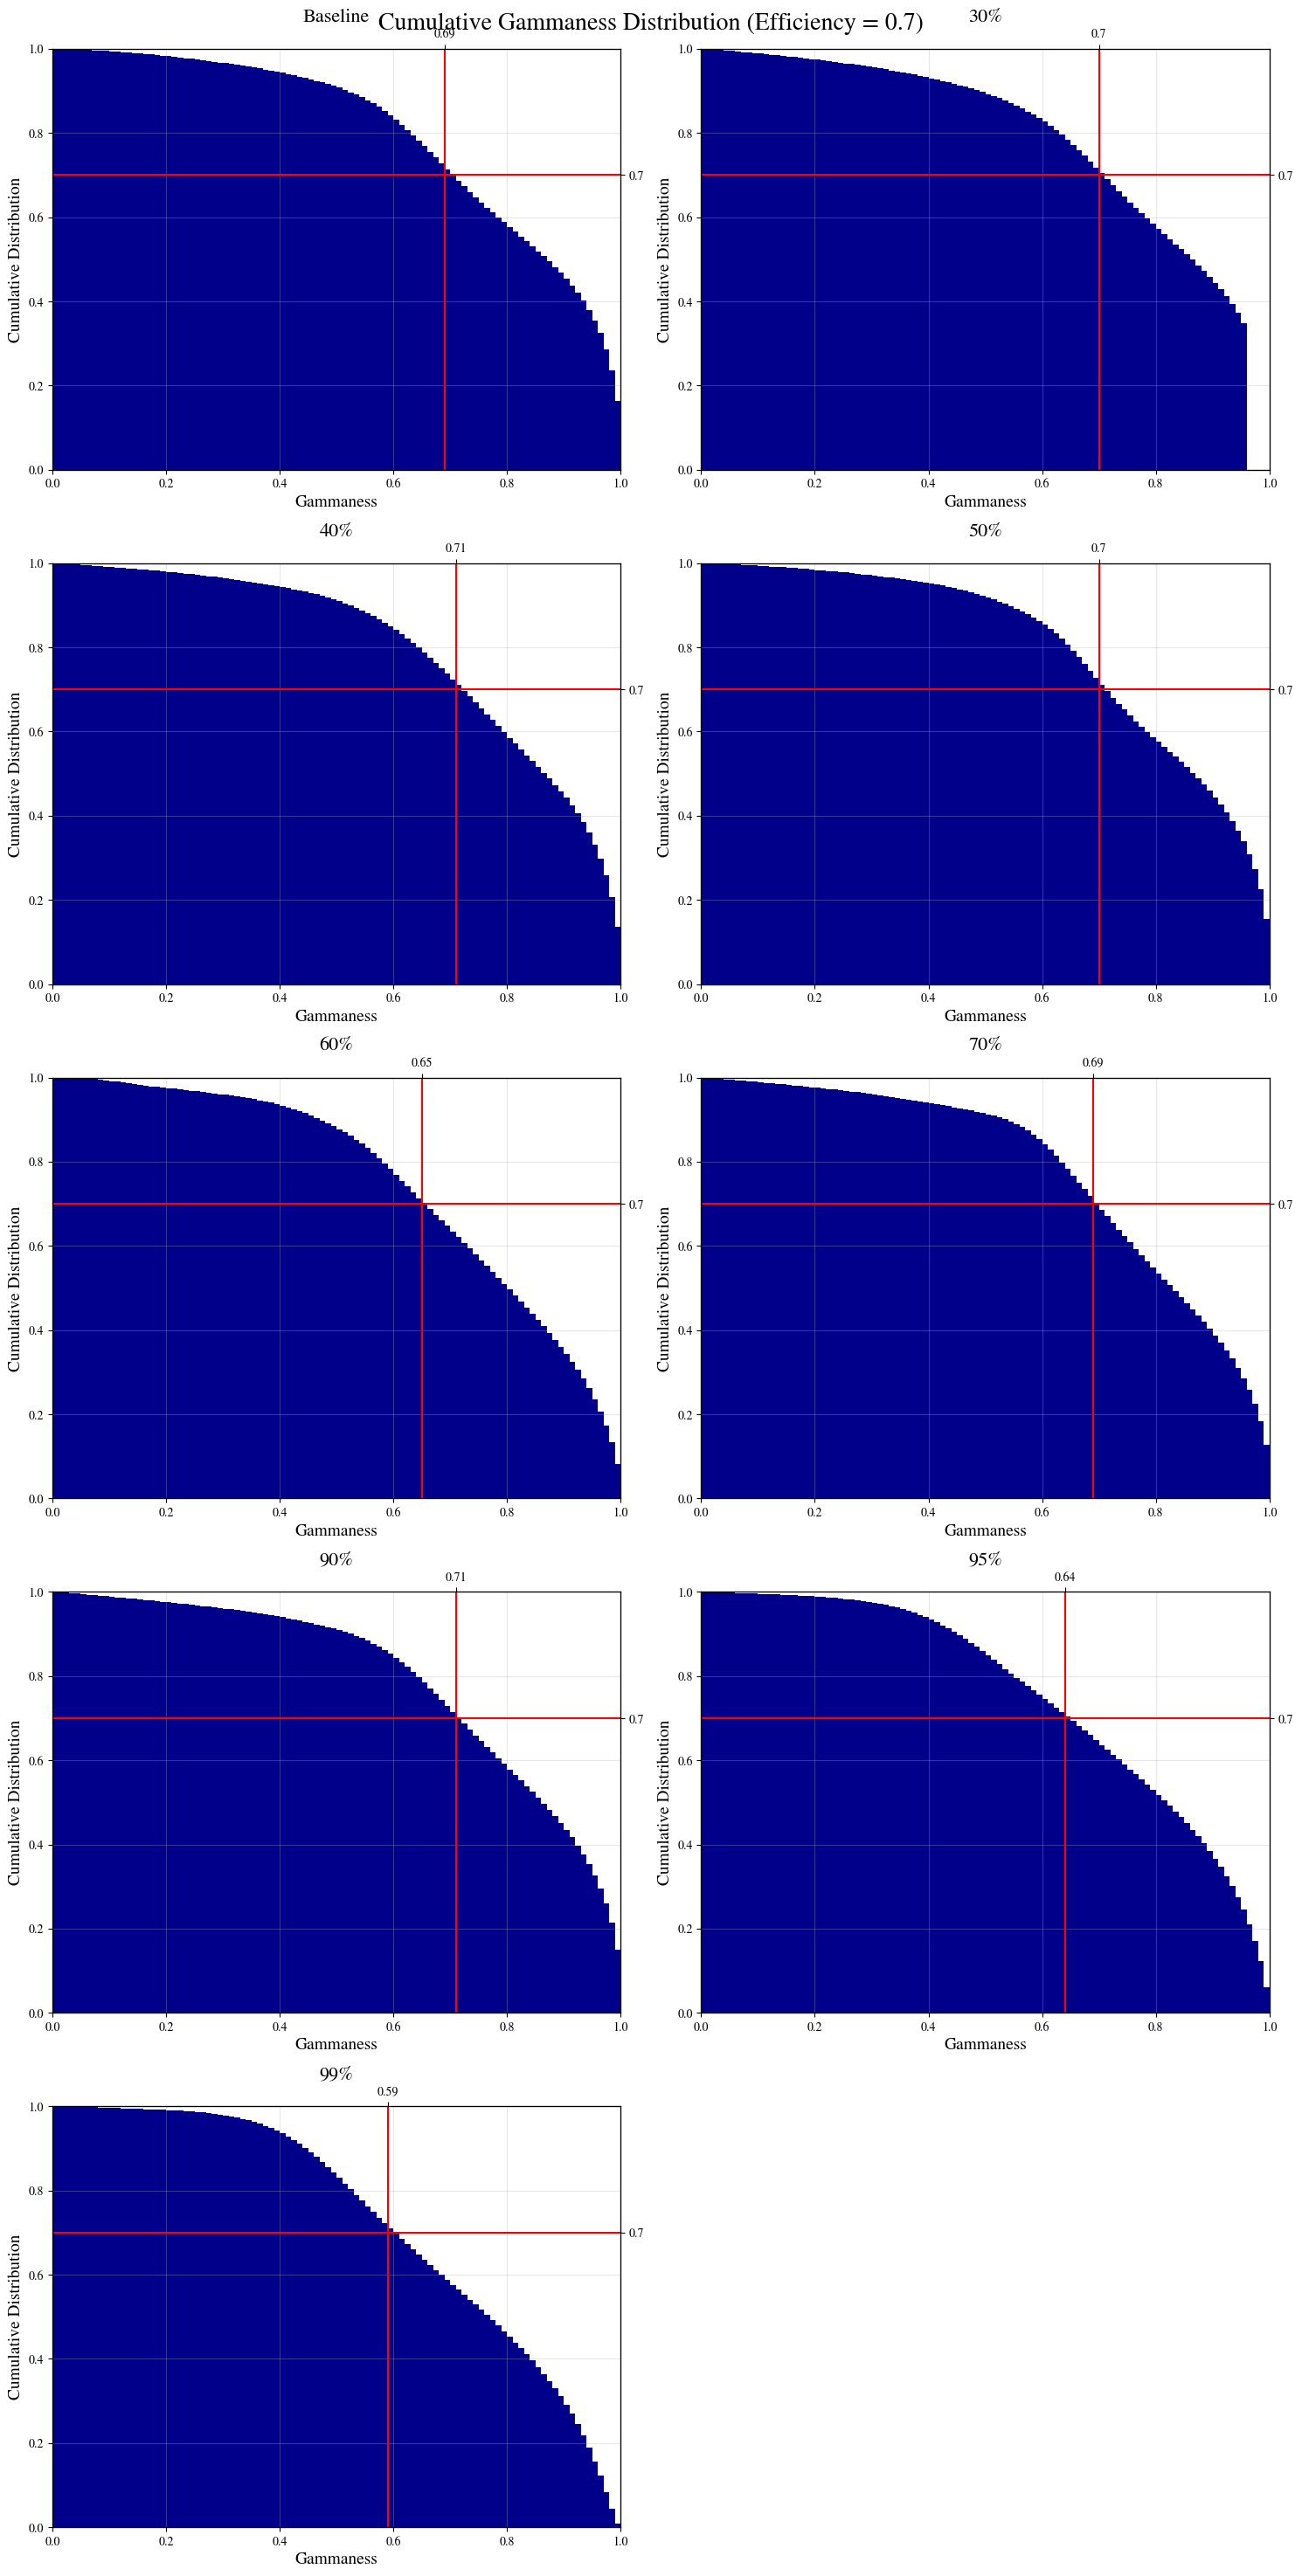

In [39]:
pred_type_list = plot_cumulative_gamanness_dist(gammaness_list, true_type_list, all_labels, efficiency=0.7)

In [40]:
def plot_confusion_matrices(list_true_type, list_pred_type, list_titles):
    """
    Plot confusion matrices for different models.
    
    Parameters:
    list_true_type (list): List of true types for each gammaness array.
    list_pred_type (list): List of predicted types for each gammaness array.
    list_labels (list): List of labels for each gammaness curve.
    """
    n_rows = len(list_true_type) 
    
    col_titles = ["Confusion Matrix", "Normalized Confusion Matrix"]
    normalize = [None, "true"]

    fig, axes = plt.subplots(n_rows, 4, figsize=(19 , 2*n_rows))
    if n_rows == 1:
        axes = np.array([axes]) 
    
    for col, title in enumerate(col_titles):
        fig.text(
            x=0.28 + 0.475 * col, y=0.982, s=title,
            ha='center', va='center', fontsize=15
        )

    for row in range(n_rows):
        true_type = list_true_type[row]
        pred_type = list_pred_type[row]

        fig.text(
            x=0.54, y=0.99 - (row * (1.0 / n_rows)), 
            s=list_titles[row],
            ha='center', va='center', fontsize=20, 
        )

        for ax, norm, title in zip(axes[row], normalize, list_titles):
            metrics.ConfusionMatrixDisplay.from_predictions(true_type, pred_type, 
                        normalize=norm, display_labels=["Proton", "Gamma"],
                        ax=ax, cmap=plt.cm.Blues)
            
            #ax.set_title(title, fontsize=14, pad=10)  
            ax.set_xlabel("Predicted label", fontsize=14)  
            ax.set_ylabel("True label", fontsize=14)  
            ax.tick_params(axis='both', labelsize=11)  
    
    fig.suptitle("Confusion Matrices", fontsize=24, y=1.01, x=0.56)
    plt.tight_layout(h_pad=4)  
    plt.show()


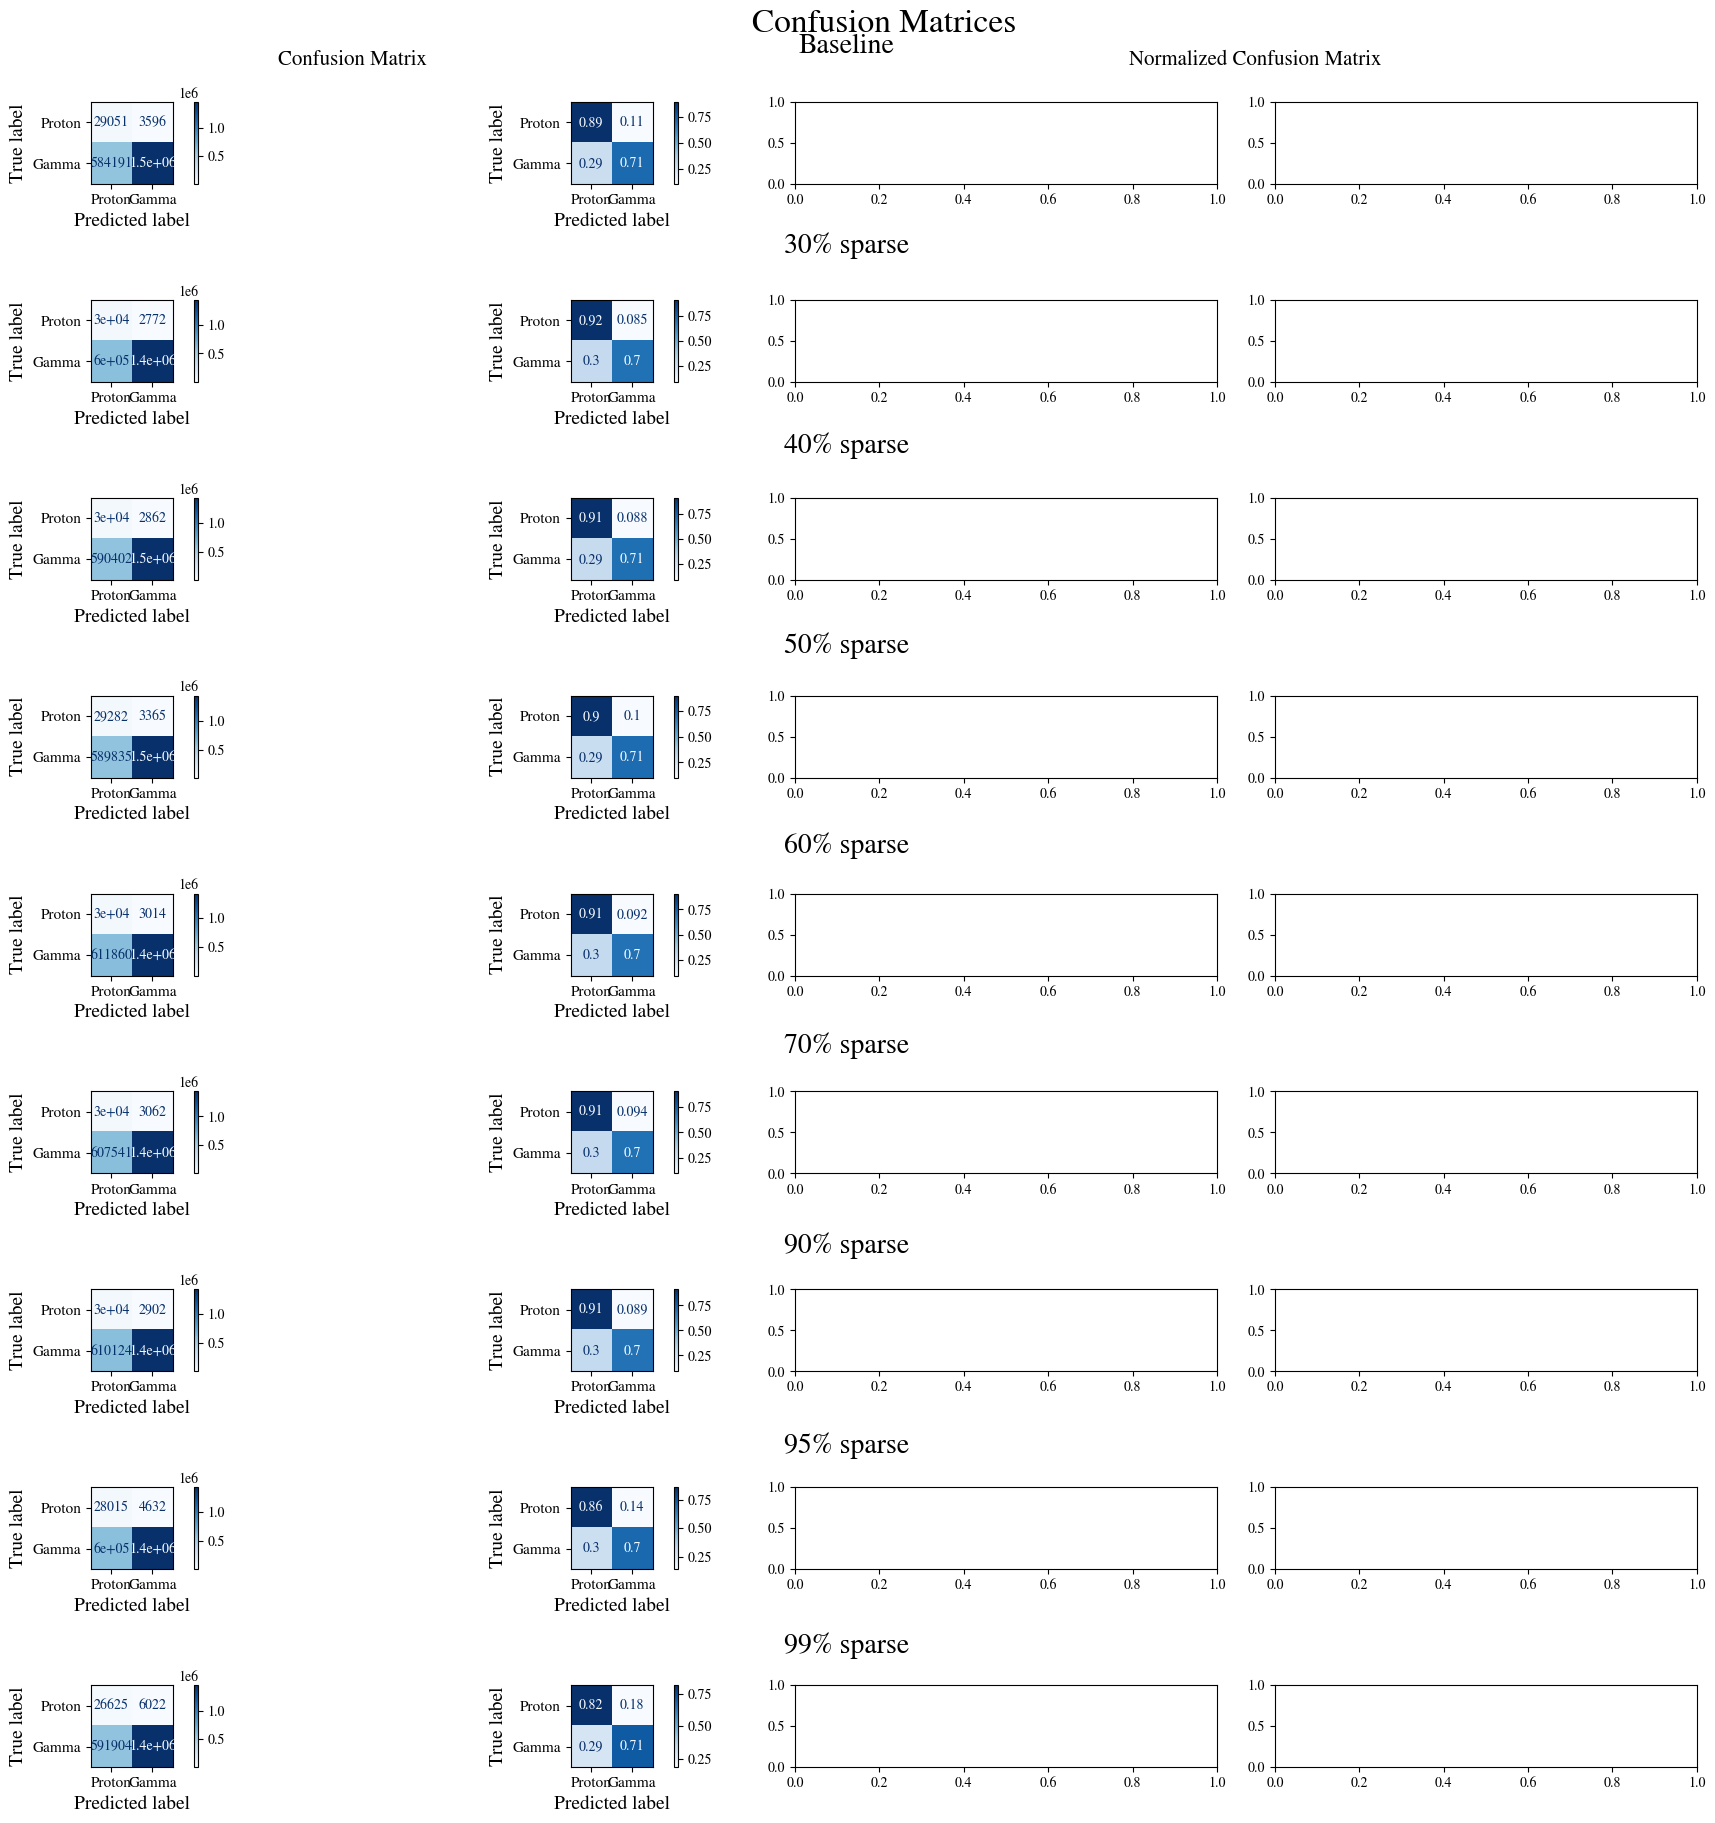

In [41]:
plot_confusion_matrices(true_type_list, pred_type_list, all_titles) 

In [42]:
def plot_confusion_matrices_perplot(list_true_type, list_pred_type, list_titles):
    """
    Plot confusion matrices for different models.
    
    Parameters:
    list_true_type (list): List of true types for each gammaness array.
    list_pred_type (list): List of predicted types for each gammaness array.
    list_labels (list): List of labels for each gammaness curve.
    """
    n_rows = len(list_true_type) 
    
    col_titles = ["Confusion Matrix", "Normalized Confusion Matrix"]
    normalize = [None, "true"]

    
    

    for row in range(n_rows):
        fig, axes = plt.subplots(1, 2, figsize=(15,5))
        if n_rows == 1:
            axes = np.array([axes]) 
        true_type = list_true_type[row]
        pred_type = list_pred_type[row]
        for col, title in enumerate(col_titles):
            fig.text(
                x=0.25 + 0.475 * col, y=0.95, s=title,
                ha='center', va='center', fontsize=15
            )
        fig.text(
            x=0.54, y=0.99 , 
            s=list_titles[row],
            ha='center', va='center', fontsize=20, 
        )#- (row * (1.0 / n_rows))

        for ax, norm, title in zip(axes, normalize, list_titles):
            metrics.ConfusionMatrixDisplay.from_predictions(true_type, pred_type, 
                        normalize=norm, display_labels=["Proton", "Gamma"],
                        ax=ax, cmap=plt.cm.Blues)

            #ax.set_title(title, fontsize=14, pad=10)  
            ax.set_xlabel("Predicted label", fontsize=14)  
            ax.set_ylabel("True label", fontsize=14)  
            ax.tick_params(axis='both', labelsize=11)  
        plt.savefig(f"./Results/confusion_matrices/cm_{list_titles[row]}.png", dpi=300, bbox_inches='tight')
    
    #fig.suptitle("Confusion Matrices", fontsize=24, y=1.01, x=0.56)
    plt.tight_layout(h_pad=4)  
    plt.show()


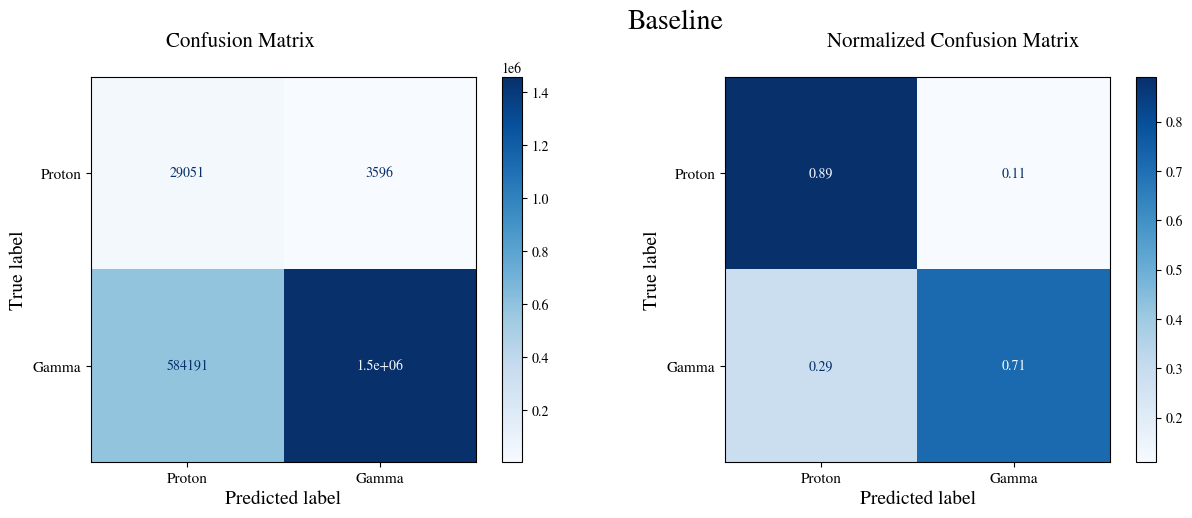

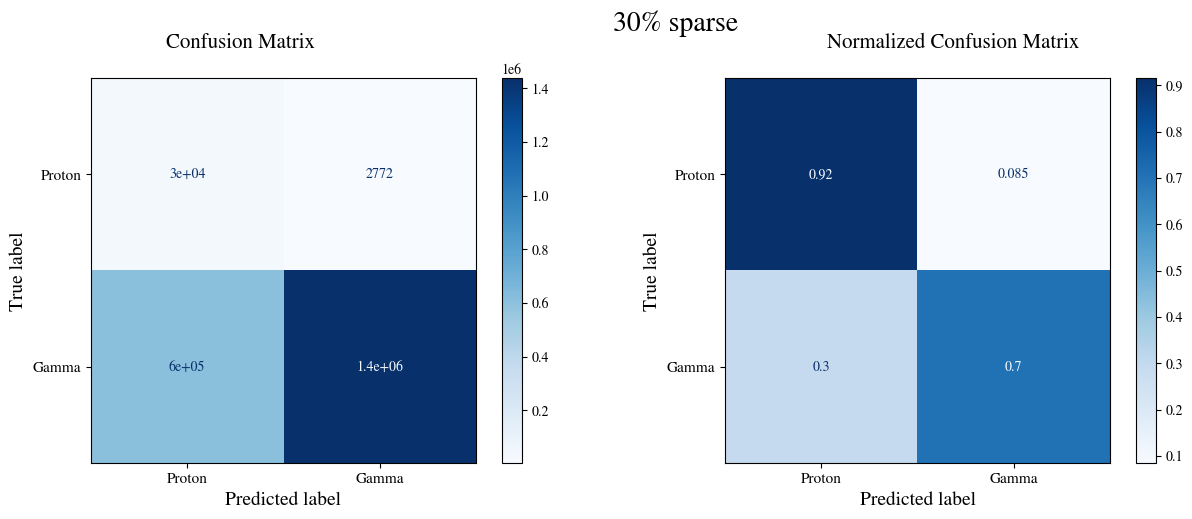

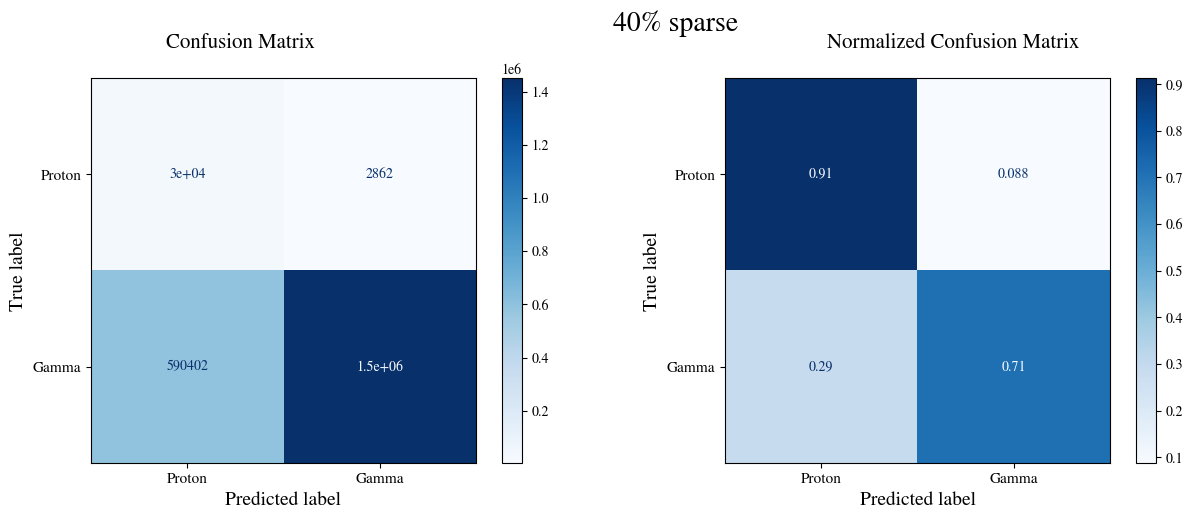

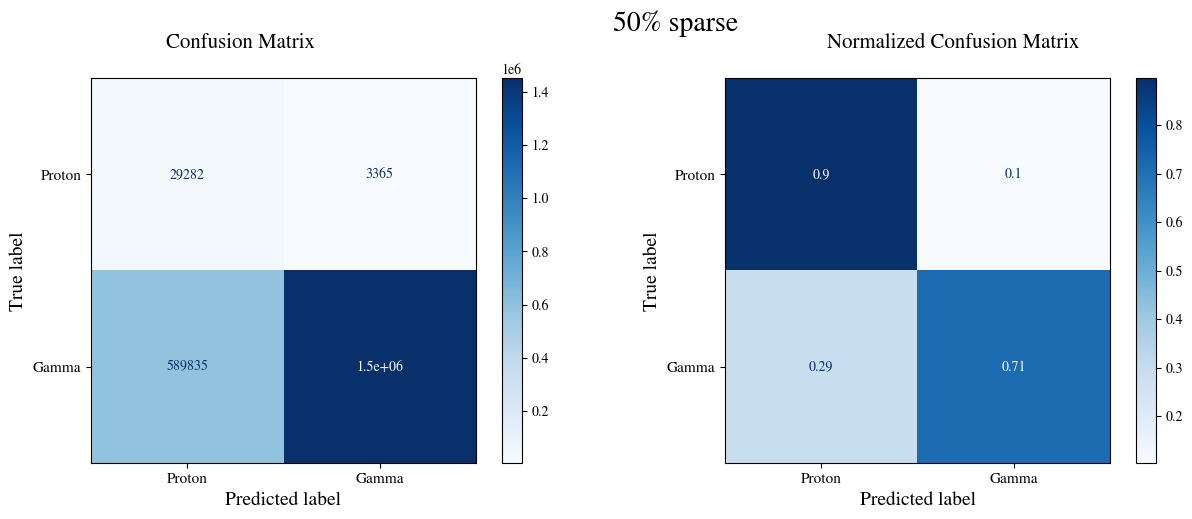

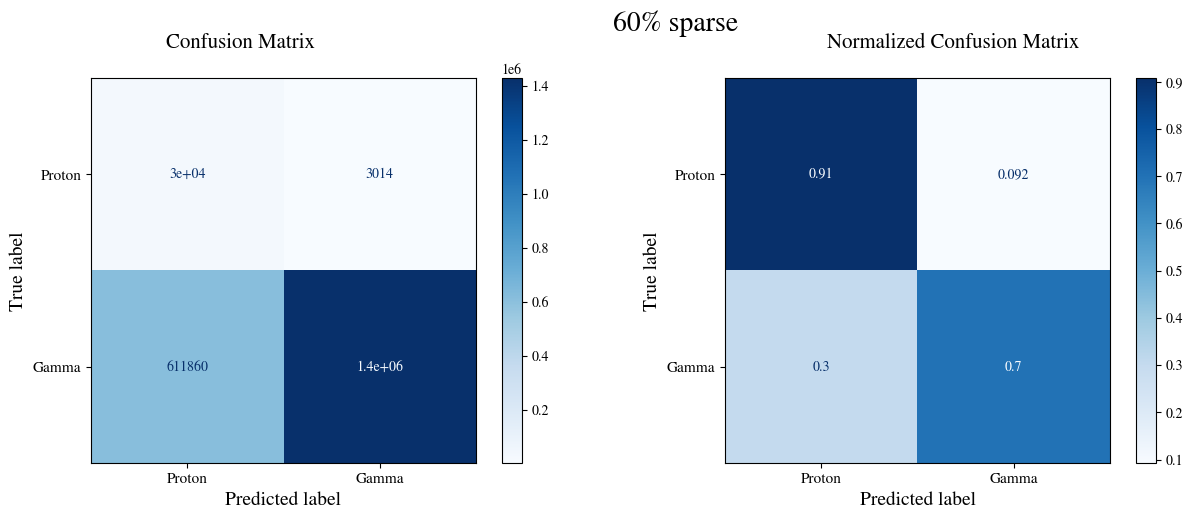

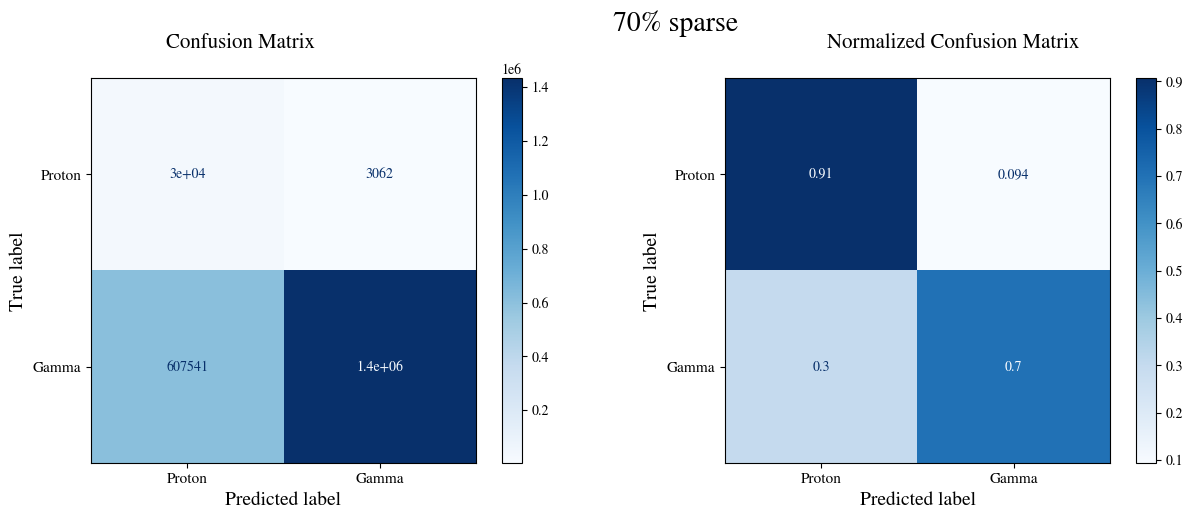

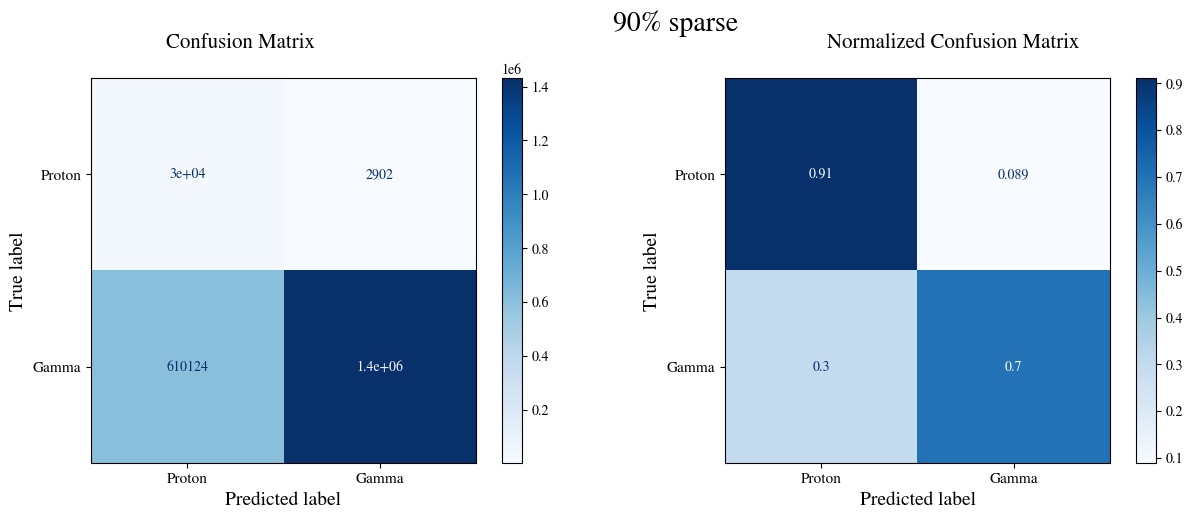

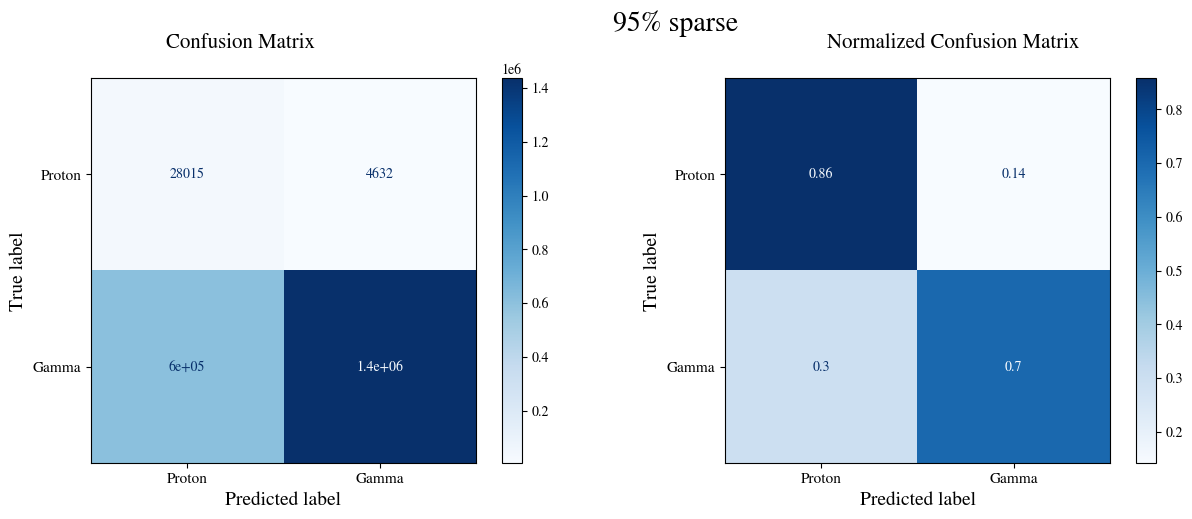

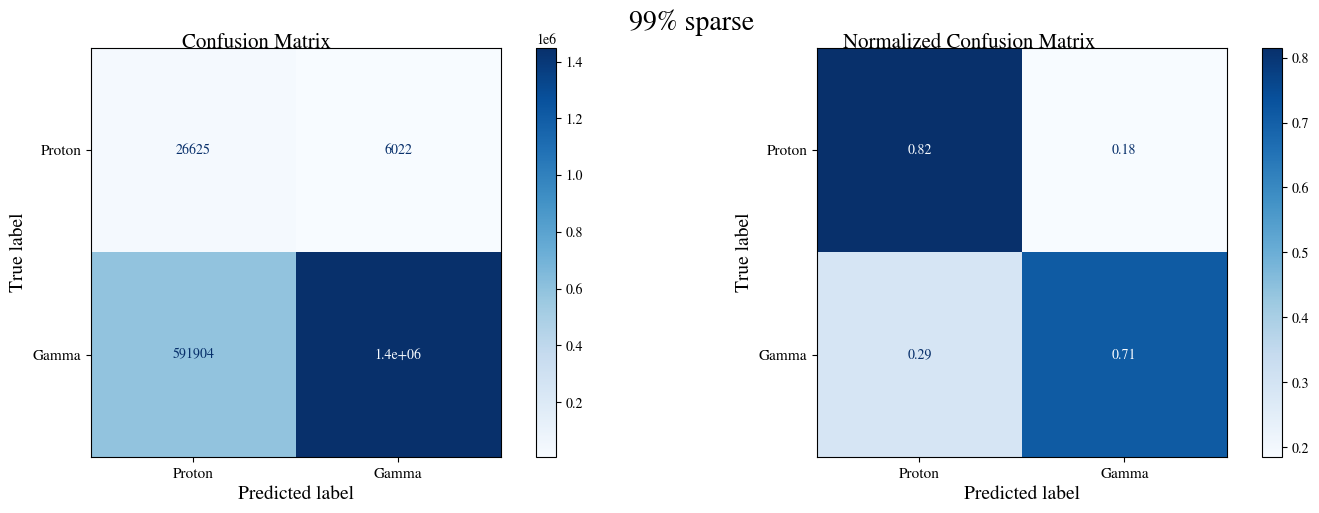

In [43]:
plot_confusion_matrices_perplot(true_type_list, pred_type_list, all_titles)

In [44]:
def print_metrics(true_type_list, pred_type_list, title_list, gammaness_list, efficiency = 0.7):
    """
    Print classification metrics for the given true and predicted types.
    
    Parameters:
    true_type (np.ndarray): True type of the showers (1 for gamma, 0 for proton).
    pred_type (np.ndarray): Predicted type of the showers .
    """
    
    metrics_data = {
    "Metric": ["Accuracy", "Precision (Class 0)", "Precision (Class 1)", 
               "Recall (Class 0)", "Recall (Class 1)", "F1 Score", 
               "Support (Class 0)", "Support (Class 1)", "AUC"]}
  

    for true_type, pred_type, gammaness, title in zip(true_type_list, pred_type_list, gammaness_list, title_list):
        accuracy = metrics.accuracy_score(true_type, pred_type)
        precision = metrics.precision_score(true_type, pred_type) # Chechk weighting
        recall = metrics.recall_score(true_type, pred_type)
        auc = metrics.roc_auc_score(true_type, gammaness) 
        f1 = metrics.f1_score(true_type, pred_type) 
        report = metrics.classification_report(true_type, pred_type)
        print(report)
        print(f"For an efficiency of eff = {efficiency}, the accuracy is {accuracy:.2f}, precision is {precision:.2f}, recall is {recall:.2f}, AUC is {auc:.2f}, F1 score is {f1:.2f}.")
        # Save previous metrics in table in a txt. Metric name are on a row basis. Columns are baseline and pruning.
        # Create a table with metrics for baseline and pruning, including class-specific precision, recall, and support

        # Extract classification reports for baseline and pruning
        report = metrics.classification_report(true_type, pred_type, output_dict=True)
    
        metrics_data[title] = [
            f"{accuracy*100:.2f}%",
            f"{report['0.0']['precision']:.2f}",
            f"{report['1.0']['precision']:.2f}",
            f"{report['0.0']['recall']:.2f}",
            f"{report['1.0']['recall']:.2f}",
            f"{f1:.2f}",
            f"{report['0.0']['support']}",
            f"{report['1.0']['support']}",
            f"{auc:.2f}"
        ]

        metrics_table = pd.DataFrame(metrics_data)

        # Save the table to a CSV file
        metrics_table.to_csv("metrics_comparison_detailed.csv", index=False)
    display.display(metrics_table)
    
    print(metrics_table)
    return metrics_table


In [45]:
metrics_table = print_metrics(true_type_list, pred_type_list, all_titles, gammaness_list, efficiency = 0.7)

              precision    recall  f1-score   support

         0.0       0.05      0.89      0.09     32647
         1.0       1.00      0.71      0.83   2041124

    accuracy                           0.72   2073771
   macro avg       0.52      0.80      0.46   2073771
weighted avg       0.98      0.72      0.82   2073771

For an efficiency of eff = 0.7, the accuracy is 0.72, precision is 1.00, recall is 0.71, AUC is 0.91, F1 score is 0.83.
              precision    recall  f1-score   support

         0.0       0.05      0.92      0.09     32647
         1.0       1.00      0.70      0.83   2041124

    accuracy                           0.71   2073771
   macro avg       0.52      0.81      0.46   2073771
weighted avg       0.98      0.71      0.81   2073771

For an efficiency of eff = 0.7, the accuracy is 0.71, precision is 1.00, recall is 0.70, AUC is 0.92, F1 score is 0.83.
              precision    recall  f1-score   support

         0.0       0.05      0.91      0.09     326

Metric   Baseline 30% sparse 40% sparse 50% sparse 60% sparse  \
0             Accuracy     71.66%     70.77%     71.39%     71.40%     70.35%   
1  Precision (Class 0)       0.05       0.05       0.05       0.05       0.05   
2  Precision (Class 1)       1.00       1.00       1.00       1.00       1.00   
3     Recall (Class 0)       0.89       0.92       0.91       0.90       0.91   
4     Recall (Class 1)       0.71       0.70       0.71       0.71       0.70   
5             F1 Score       0.83       0.83       0.83       0.83       0.82   
6    Support (Class 0)    32647.0    32647.0    32647.0    32647.0    32647.0   
7    Support (Class 1)  2041124.0  2041124.0  2041124.0  2041124.0  2041124.0   
8                  AUC       0.91       0.92       0.92       0.91       0.91   

  70% sparse 90% sparse 95% sparse 99% sparse  
0     70.56%     70.44%     70.65%     71.17%  
1       0.05       0.05       0.04       0.04  
2       1.00       1.00       1.00       1.00  
3       0.91       0.91       0.86       0.82  
4       0.70       0.70       0.70       0.71  
5       0.82       0.82       0.83       0.83  
6    32647.0    32647.0    32647.0    32647.0  
7  2041124.0  2041124.0  2041124.0  2041124.0  
8       0.92       0.92       0.88       0.86

                Metric   Baseline 30% sparse 40% sparse 50% sparse 60% sparse  \
0             Accuracy     71.66%     70.77%     71.39%     71.40%     70.35%   
1  Precision (Class 0)       0.05       0.05       0.05       0.05       0.05   
2  Precision (Class 1)       1.00       1.00       1.00       1.00       1.00   
3     Recall (Class 0)       0.89       0.92       0.91       0.90       0.91   
4     Recall (Class 1)       0.71       0.70       0.71       0.71       0.70   
5             F1 Score       0.83       0.83       0.83       0.83       0.82   
6    Support (Class 0)    32647.0    32647.0    32647.0    32647.0    32647.0   
7    Support (Class 1)  2041124.0  2041124.0  2041124.0  2041124.0  2041124.0   
8                  AUC       0.91       0.92       0.92       0.91       0.91   

  70% sparse 90% sparse 95% sparse 99% sparse  
0     70.56%     70.44%     70.65%     71.17%  
1       0.05       0.05       0.04       0.04  
2       1.00       1.00       1.00       1.00

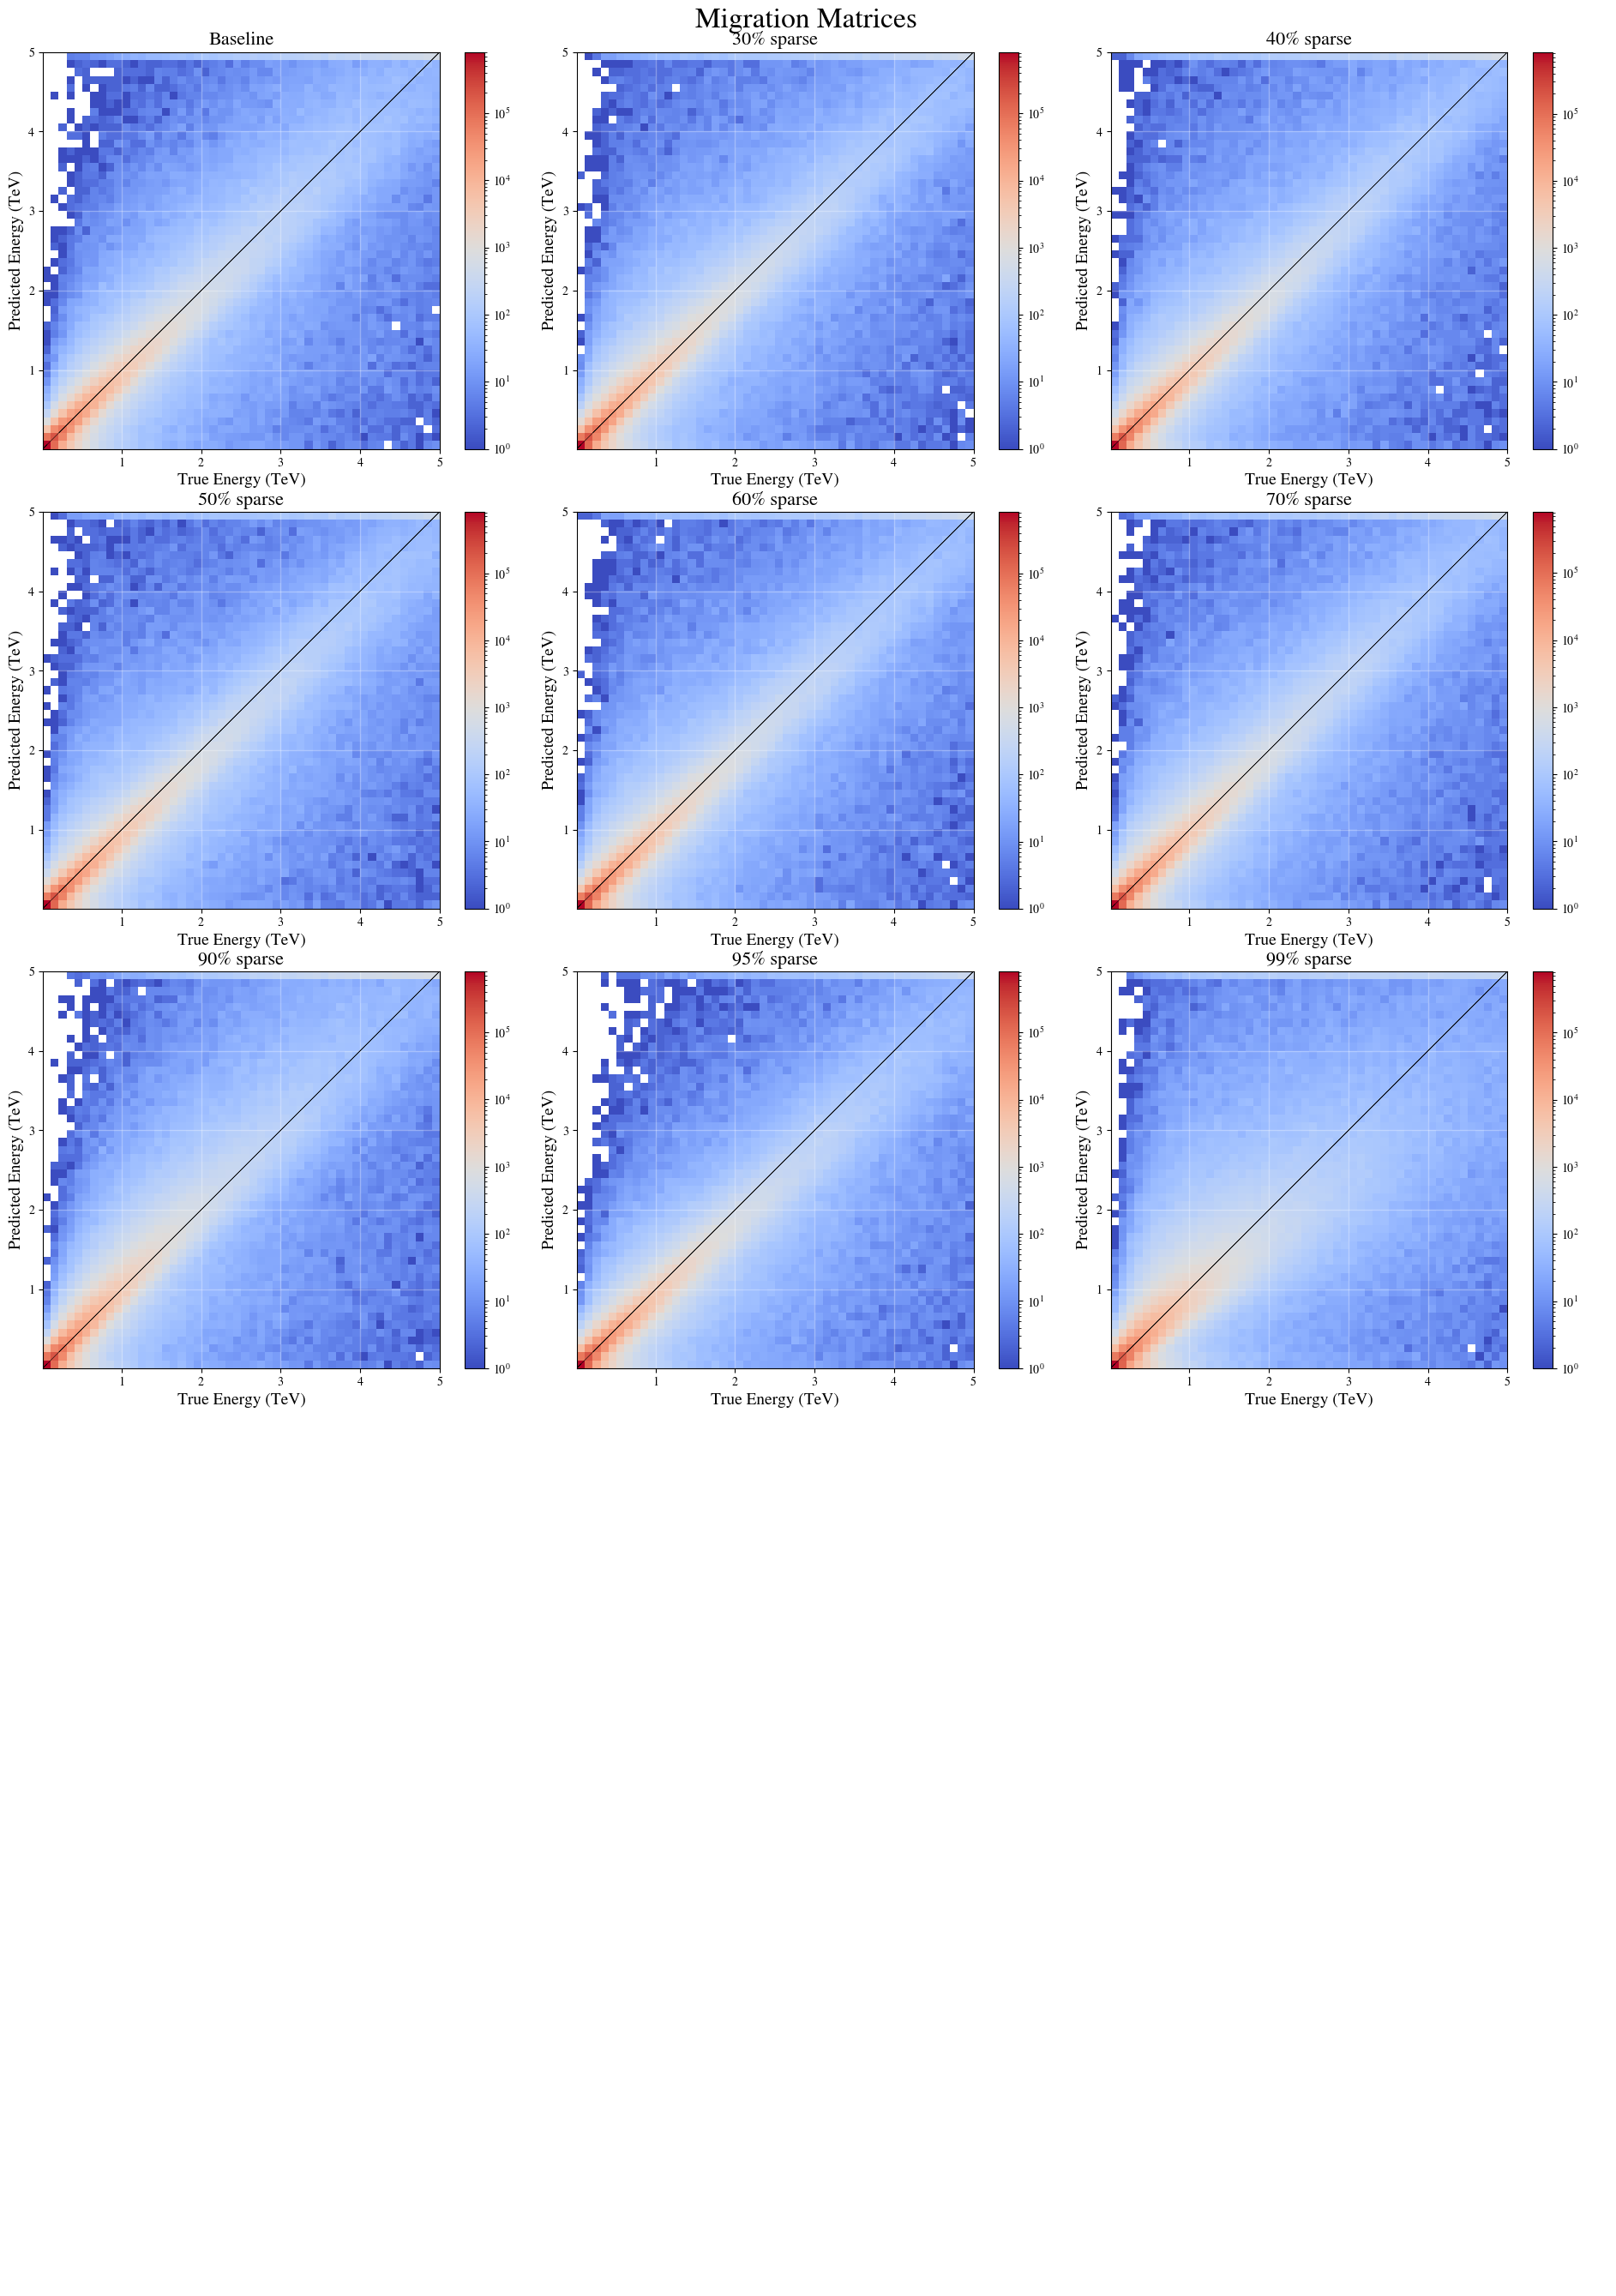

In [46]:
def plot_migration_matrices(gamma_shower_list, title_list):
    total_subplots = len(gamma_shower_list)
    bins = ctaplot.ana.ana.logspace_decades_nbin(0.01, 5, 5)
    
    fig, axes = plt.subplots(int(np.ceil(total_subplots / 2)), 3, figsize=(19 , 3*total_subplots))
    plt.suptitle("Migration Matrices", fontsize=24, y=0.99)

    axes = axes.flatten()

    for i, (gamma_shower, title) in enumerate(zip(gamma_shower_list, title_list)):
        
        true_energies = []
        predicted_energies = []
        predicted_energies_pre = gamma_shower['CTLearn_tel_energy']
        true_energies_pre = gamma_shower['true_energy']
        
        for j in range(len(true_energies_pre)):
            if true_energies_pre[j] > 0.01 and true_energies_pre[j] < 5:
                true_energies.append(true_energies_pre[j])
                predicted_energies.append(predicted_energies_pre[j])

        true_energies = np.array(true_energies)
        predicted_energies = np.array(predicted_energies)
        
        # Force both arrays to have the same range by clipping
        predicted_energies = np.clip(predicted_energies, 0.01, 5.0)
        
        ax = axes[i]
        
        # Create the migration matrix plot with explicit range
        ctaplot.plots.plots.plot_migration_matrix(
            true_energies, predicted_energies, ax=ax, xy_line=True,
            colorbar=True, 
            hist2d_args=dict(bins=(bins, bins), 
                            range=[[0.01, 5], [0.01, 5]],  # Force same range for both axes
                            norm=matplotlib.colors.LogNorm(), 
                            cmap=plt.cm.coolwarm),
            line_args=None
        )
        
        ax.set_xlabel("True Energy (TeV)", fontsize=14)
        ax.set_ylabel("Predicted Energy (TeV)", fontsize=14)
        ax.set_title(f"{title}", fontsize=16)

        # Force both axes to have exactly the same limits and ticks
        ax.set_xlim(0.01, 5)
        ax.set_ylim(0.01, 5)
        ax.set_aspect('equal', adjustable='box')
        ax.grid(True, alpha=0.3, color='white', linewidth=1)

    # Hide unused subplots if any
    for j in range(len(gamma_shower_list), len(axes)):
        axes[j].axis('off')
    
    fig.tight_layout()
    plt.show()

plot_migration_matrices(gamma_shower_list, all_titles)

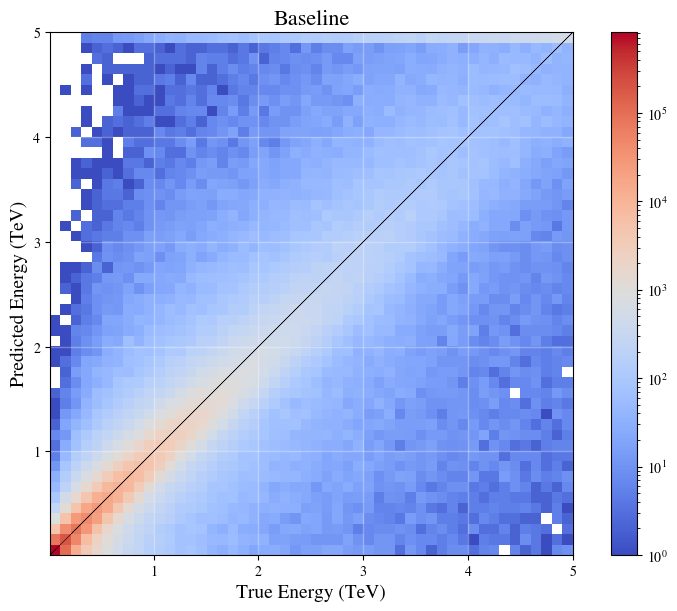

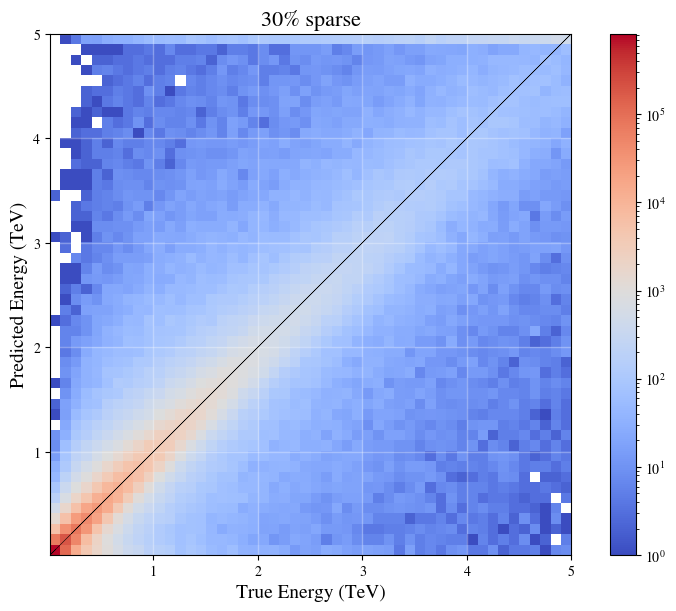

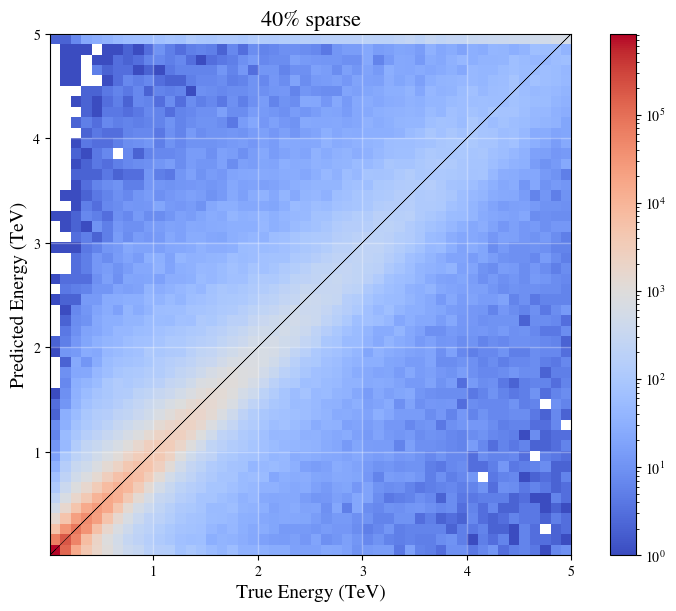

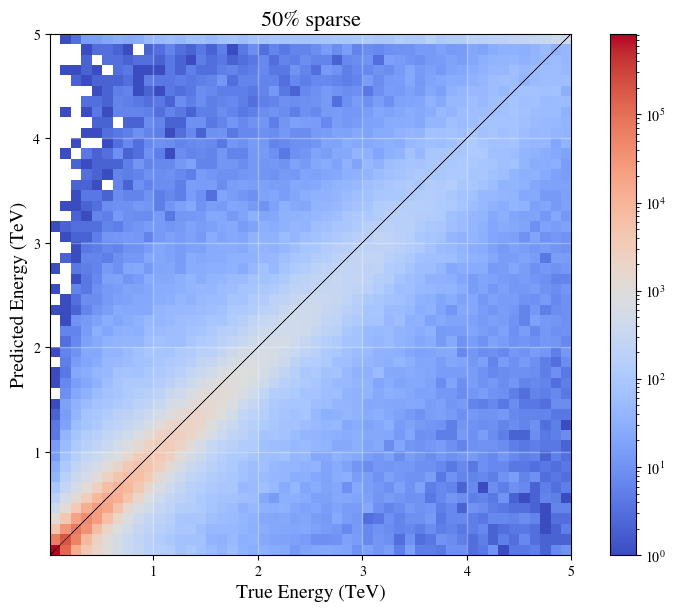

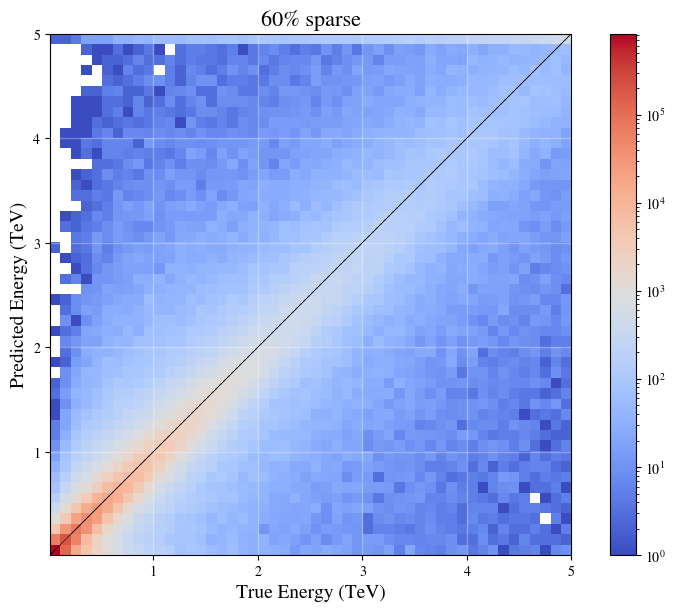

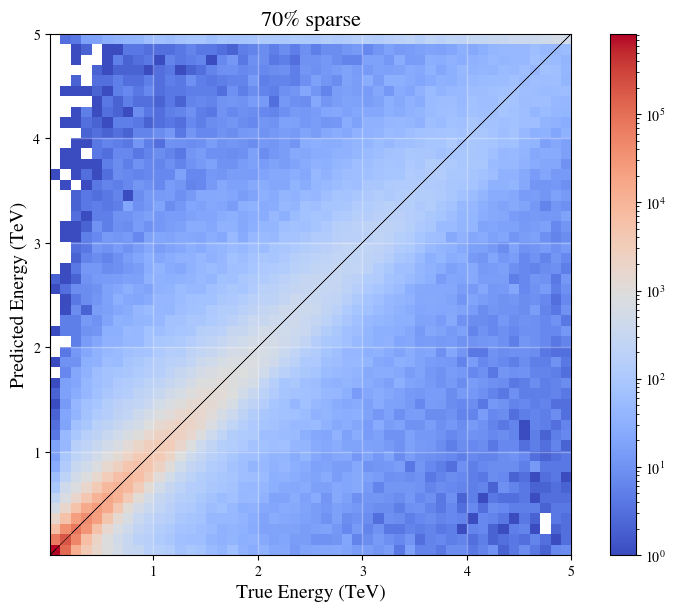

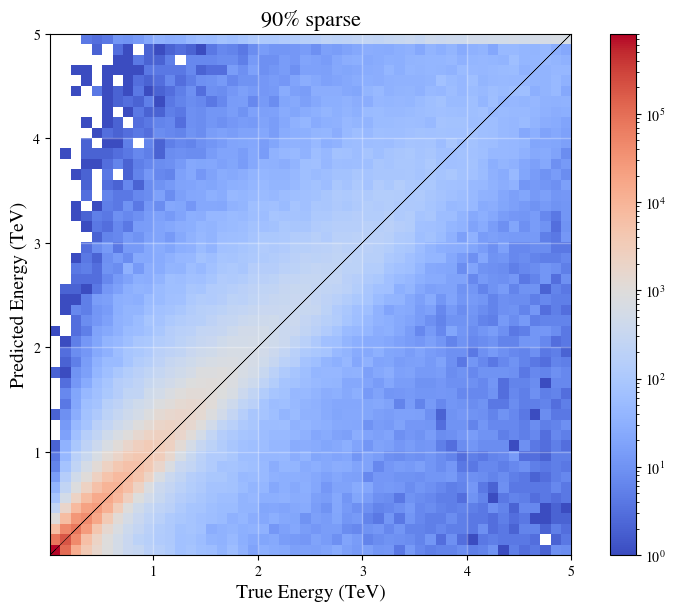

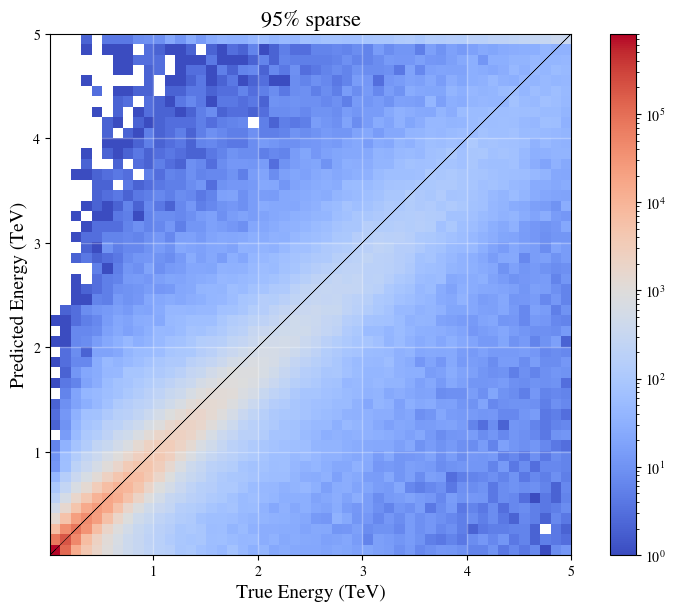

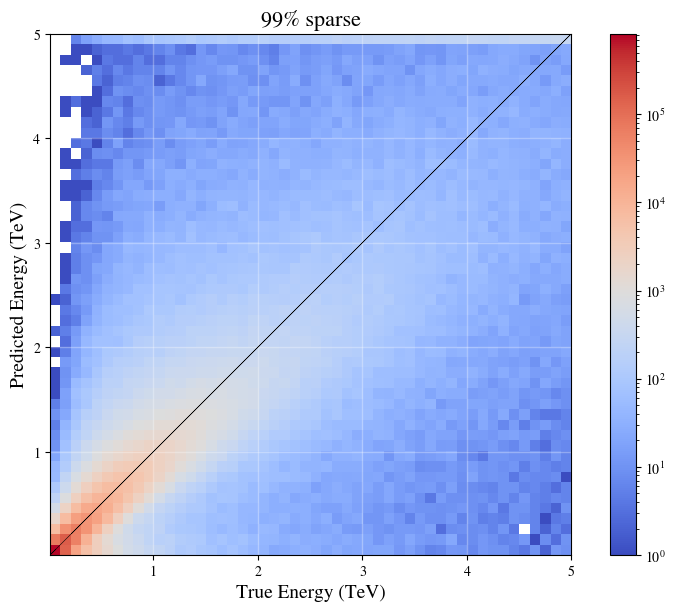

In [47]:
def plot_migration_matrices_perplot(gamma_shower_list, title_list):
    total_subplots = len(gamma_shower_list)
    bins = ctaplot.ana.ana.logspace_decades_nbin(0.01, 5, 5)
    
    
    #axes = axes.flatten()

    for i, (gamma_shower, title) in enumerate(zip(gamma_shower_list, title_list)):
        fig, axes = plt.subplots(1, 1, figsize=(8, 6), layout='constrained')
        #plt.suptitle("Migration Matrices", fontsize=24, y=0.99)
        if '80' in title:
            continue
        true_energies = []
        predicted_energies = []
        predicted_energies_pre = gamma_shower['CTLearn_tel_energy']
        true_energies_pre = gamma_shower['true_energy']
        
        for j in range(len(true_energies_pre)):
            if true_energies_pre[j] > 0.01 and true_energies_pre[j] < 5:
                true_energies.append(true_energies_pre[j])
                predicted_energies.append(predicted_energies_pre[j])

        true_energies = np.array(true_energies)
        predicted_energies = np.array(predicted_energies)
        
        # Force both arrays to have the same range by clipping
        predicted_energies = np.clip(predicted_energies, 0.01, 5.0)
        
        #ax = axes[i]
        
        # Create the migration matrix plot with explicit range
        ctaplot.plots.plots.plot_migration_matrix(
            true_energies, predicted_energies, ax=axes, xy_line=True,
            colorbar=True, 
            hist2d_args=dict(bins=(bins, bins), 
                            range=[[0.01, 5], [0.01, 5]],  # Force same range for both axes
                            norm=matplotlib.colors.LogNorm(), 
                            cmap=plt.cm.coolwarm),
            line_args=None
        )

        axes.set_xlabel("True Energy (TeV)", fontsize=14)
        axes.set_ylabel("Predicted Energy (TeV)", fontsize=14)
        axes.set_title(f"{title}", fontsize=16)

        # Force both axes to have exactly the same limits and ticks
        axes.set_xlim(0.01, 5)
        axes.set_ylim(0.01, 5)
        axes.set_aspect('equal', adjustable='box')
        axes.grid(True, alpha=0.3, color='white', linewidth=1)


        plt.savefig(f"./Results/migration_matrices/cm_{title}.png", dpi=300, bbox_inches='tight')
    
    #fig.tight_layout()
    plt.show()

plot_migration_matrices_perplot(gamma_shower_list, all_titles)

/lhome/ext/ucm147/ucm1478/miniconda3/envs/model_compression/lib/python3.11/site-packages/ctaplot/plots/plots.py:942: UserWarning: This axis already has a converter set and is updating to a potentially incompatible converter
  ax.errorbar(energy_center, e_res[:, 0],
/tmp/ucm1478/ipykernel_3335962/948909366.py:72: UserWarning: Glyph 8320 (\N{SUBSCRIPT ZERO}) missing from font(s) STIXGeneral.
  plt.tight_layout()
/lhome/ext/ucm147/ucm1478/miniconda3/envs/model_compression/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8320 (\N{SUBSCRIPT ZERO}) missing from font(s) STIXGeneral.
  fig.canvas.print_figure(bytes_io, **kw)


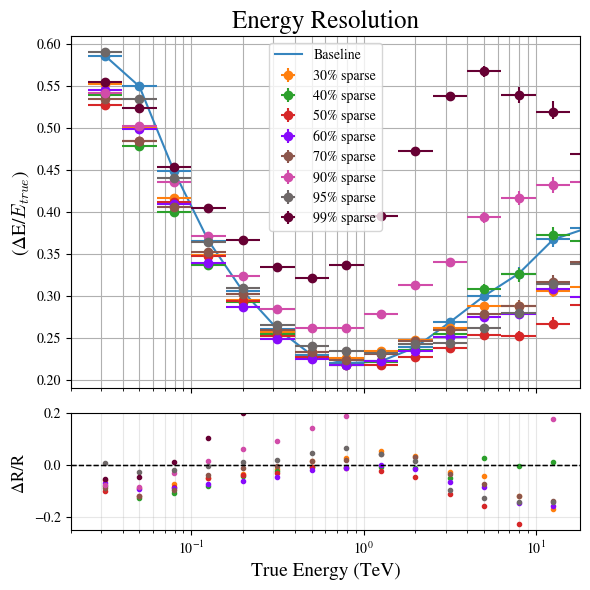

In [48]:
def plot_energy_resolution_curves(gamma_shower_list, title_list, colors=None):
    """
    Plot the energy resolution curves for different gamma showers.
    Includes a combined plot with a variation subplot relative to the baseline (first model).
    """
    true_energy = []
    reco_energy = []
    fig2, (ax2, ax_diff) = plt.subplots(
        2, 1, figsize=(6, 6), gridspec_kw={"height_ratios": [3, 1]}, sharex=True
    )
    
    E_min, E_max = 0.03, 11  # TeV

    true_energy = gamma_shower_list[0]["true_energy"]

    nbins=len(gamma_shower_list)
    reds = plt.cm.Reds
    colors = [reds(0.3 + 0.7 * j / max(nbins-1, 1)) for j in range(nbins)]
    
    baseline_true = gamma_shower_list[0]["true_energy"]
    baseline_reco = gamma_shower_list[0]["CTLearn_tel_energy"]
    ctaplot.plots.plots.plot_energy_resolution(
        baseline_true, baseline_reco, bias_correction=False, bins=None,
        ax=ax2, color=CUSTOM_COLORS[0]
    )
    x_base, y_base = ax2.lines[-1].get_data()

    

    for i, (gamma_shower, title) in enumerate(zip(gamma_shower_list, title_list)):
        # Apply energy cuts
        if '80' in title:
            continue
        true_energy = gamma_shower["true_energy"]
        reco_energy = gamma_shower["CTLearn_tel_energy"]
        if i == 0:
            ax2.plot(x_base, y_base, label=title, color=CUSTOM_COLORS[i])
            ax_diff.axhline(0, color="gray", lw=1, ls="--")

        # Plot relative difference (skip baseline itself)
        if i > 0:
            ctaplot.plots.plots.plot_energy_resolution(
            true_energy, reco_energy, bias_correction=False, 
            bins=None, ax=ax2, label=title, color=CUSTOM_COLORS[i]
            )
            x, y = ax2.lines[-1].get_data()
            ax_diff.plot(
                x, (y - y_base) / y_base,
                label=f"{title} vs {title_list[0]}", color=CUSTOM_COLORS[i],
                marker=".", linestyle=""
            )

    ax_diff.axhline(0, color="black", linestyle="--", linewidth=1)
    ax_diff.set_xlabel("True Energy (TeV)", fontsize=14)
    ax2.set_ylabel("(ΔE/$E_{true}$) ", fontsize=14)

    ax_diff.set_xlim(0.02, 18)
    ax2.set_xlim(0.02, 18)
    ax_diff.set_ylim(-0.25, 0.2)
    # Reset y-axis limits to fit the visible data after x-limits are set
    ax2.relim()
    ax2.autoscale_view(scalex=False, scaley=True)
    ax_diff.relim()
    ax_diff.autoscale_view(scalex=False, scaley=True)
    ax2.legend()
    ax2.set_xlabel("")
    ax_diff.set_xscale("log")
    ax_diff.grid(True, which="both", alpha=0.3)
    ax_diff.set_ylabel("ΔR/R₀", fontsize=12)

    ax2.set_title("Energy Resolution", fontsize=18)
    plt.tight_layout()
    plt.show()

plot_energy_resolution_curves(gamma_shower_list, all_titles)

In [49]:
def plot_angular_resolution_curves(gamma_shower_list, title_list):
    """
    Plot angular resolution vs energy for multiple datasets, and
    add a residuals subplot below the combined plot (relative to baseline).
    Energies outside [0.01, 11] TeV are excluded entirely.
    """
    fig, (ax, ax_resid) = plt.subplots(
        2, 1, figsize=(8, 8), gridspec_kw={"height_ratios": [3, 1]}, sharex=True
    )

    baseline_line = None
    baseline_E, baseline_R = None, None
    E_min, E_max = 0.01*u.TeV, 20*u.TeV  # TeV

    #valid = [(g, t) for g, t in zip(gamma_shower_list, title_list) if "95" not in t]
    #nbins = len(valid)
    nbins=len(gamma_shower_list)-1
    reds = plt.cm.Reds
    colors = [reds(0.4 + 0.7 * j / max(nbins-1, 1)) for j in range(nbins)]
    
    for i, (gamma_shower, title) in enumerate(zip(gamma_shower_list, title_list)):
        if "95" in title:
            continue
        true_alt = gamma_shower["true_alt"].to(u.rad)
        pred_alt = gamma_shower["CTLearn_tel_alt"].to(u.rad)
        true_az = gamma_shower["true_az"].to(u.rad)
        pred_az = gamma_shower["CTLearn_tel_az"].to(u.rad)
        true_energy = gamma_shower["true_energy"]

        ctaplot.plots.plots.plot_angular_resolution_per_energy(
            true_alt, pred_alt, true_az, pred_az, true_energy,
            ax=ax,  label=title, color=colors[i]
        )

        line = ax.lines[-1]
        E = line.get_xdata()
        R = line.get_ydata()

        mask = (E >= E_min) & (E <= E_max)
        E, R = E[mask], R[mask]

        # overwrite the curve with the masked version
        line.set_data(E, R)
        line.set_color(colors[i])

        if baseline_line is None:
            baseline_E, baseline_R = E, R
            baseline_line = line.set(linestyle="-", color=colors[i])

        else:
            # compute residuals vs baseline
            R_base_interp = np.interp(E, baseline_E, baseline_R)
            rel_var = (R - R_base_interp) / R_base_interp
            ax_resid.axhline(0, color="gray", lw=1, ls="--")
            ax_resid.plot(E, rel_var, marker=".", linestyle = "", color=colors[i])

    ax.set_title("All Angular Resolution Curves", fontsize=22, y=1.02)
    ax.legend(fontsize=14)
    ax.set_xlim(0.02, 18)
    ax_resid.set_xscale("log")
    ax_resid.set_ylim(-0.15, 0.1)
    ax.set_ylabel("Angular Resolution (deg)", fontsize=16)
    ax_resid.set_xlabel("True Energy (TeV)", fontsize=16)
    ax_resid.set_ylabel("ΔR/R₀", fontsize=16)
    ax_resid.grid(True, which="both", alpha=0.8)
    ax.set_xlabel("") 
    plt.tight_layout()
    plt.show()


/lhome/ext/ucm147/ucm1478/miniconda3/envs/model_compression/lib/python3.11/site-packages/ctaplot/plots/plots.py:376: UserWarning: This axis already has a converter set and is updating to a potentially incompatible converter
  ax.errorbar(x, res[:, 0], xerr=[x - bins[:-1], bins[1:] - x],


IndexError: list index out of range

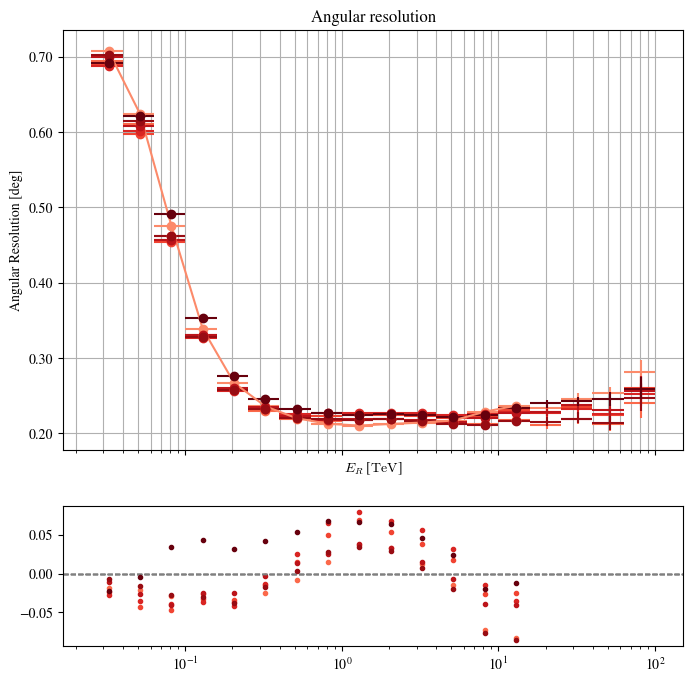

In [50]:
plot_angular_resolution_curves(gamma_shower_list, all_titles)

In [ ]:
def AUC_sparsity_for_energy_bins(percentages, true_energies_list, gammaness_list, true_type_list, bins):
    """
    Extract AUC values per energy bin for each sparsity level.
    
    Parameters:
    percentages (list): List of sparsity percentages (including 0 for baseline)
    bins (array): Energy bin edges
    
    Returns:
    dict: Dictionary with energy bin ranges as keys and AUC arrays as values
    """
    from sklearn.metrics import roc_auc_score
    import numpy as np
    import astropy.units as u
    
    auc_per_energy_bin = {}
    
    # For each energy bin
    for i in range(len(bins) - 1):
        bin_low = bins[i]
        bin_high = bins[i + 1]
        bin_key = f"{bin_low:.2f}-{bin_high:.2f}_TeV"
        
        auc_values = []
        
        # For each sparsity level (including baseline at index 0)
        for j, percentage in enumerate(all_percentages):
            true_energies = true_energies_list[j]
            gammaness = gammaness_list[j]
            true_type = true_type_list[j]
            
            # Filter events in this energy bin
            energy_mask = (true_energies >= bin_low*u.TeV) & (true_energies < bin_high*u.TeV)
            
            if np.sum(energy_mask) > 0:  # Only calculate if there are events in this bin
                bin_true_type = true_type[energy_mask]
                bin_gammaness = gammaness[energy_mask]
                
                # Calculate AUC for this energy bin and sparsity
                auc = roc_auc_score(bin_true_type, bin_gammaness)
                auc_values.append(auc)
            else:
                auc_values.append(np.nan)  
        
        # Store AUC 
        auc_per_energy_bin[bin_key] = np.array(auc_values)
    
    return auc_per_energy_bin


auc_results = AUC_sparsity_for_energy_bins(all_percentages, true_energies_list, gammaness_list, true_type_list, bins)


for energy_bin, auc_array in auc_results.items():
    print(f"Energy bin {energy_bin}:")
    print(f"  Sparsities: {all_percentages}")
    print(f"  AUC values: {auc_array}")
    print()

Energy bin 0.01-0.02_TeV:
  Sparsities: [0, 30, 40, 50, 60, 70, 90, 95]
  AUC values: [0.63655825 0.62905194 0.7608549  0.69348141 0.60525597 0.67236236
 0.64901287 0.55426573]

Energy bin 0.02-0.03_TeV:
  Sparsities: [0, 30, 40, 50, 60, 70, 90, 95]
  AUC values: [0.77033338 0.77462574 0.80266481 0.76780733 0.74649368 0.78844871
 0.7912121  0.69586541]

Energy bin 0.03-0.04_TeV:
  Sparsities: [0, 30, 40, 50, 60, 70, 90, 95]
  AUC values: [0.81508939 0.82448501 0.83056927 0.81603468 0.80416005 0.8367216
 0.83008709 0.75038697]

Energy bin 0.04-0.06_TeV:
  Sparsities: [0, 30, 40, 50, 60, 70, 90, 95]
  AUC values: [0.81744174 0.83098026 0.83722147 0.82404817 0.81631682 0.83161497
 0.8338468  0.78564368]

Energy bin 0.06-0.10_TeV:
  Sparsities: [0, 30, 40, 50, 60, 70, 90, 95]
  AUC values: [0.85878767 0.8664832  0.86424253 0.86822326 0.85939641 0.86747763
 0.86884706 0.82452491]

Energy bin 0.10-0.16_TeV:
  Sparsities: [0, 30, 40, 50, 60, 70, 90, 95]
  AUC values: [0.91737749 0.92401379 0.

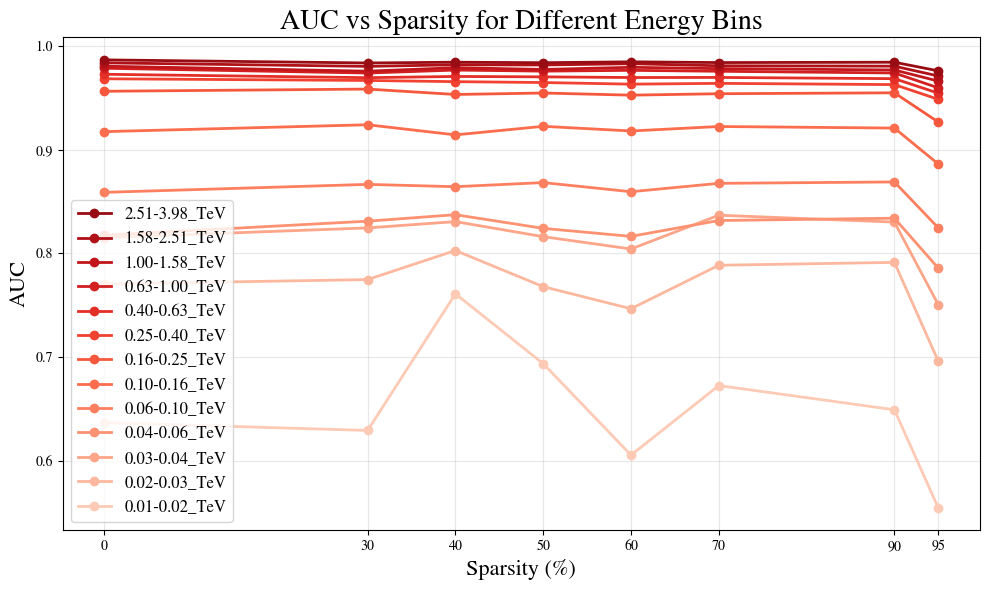

In [ ]:
def plot_auc_vs_sparsity_all_energy_bins(auc_results, all_percentages):
    """
    Plot AUC vs sparsity for all energy bins in one graph.
    
    Parameters:
    auc_results (dict): Dictionary with energy bin ranges as keys and AUC arrays as values
    all_percentages (list): List of sparsity percentages (including 0 for baseline)
    """
    plt.figure(figsize=(10, 6))
    nbins=len(auc_results)
    reds = plt.cm.Reds
    colors = [reds(0.2 + 0.7 * j / max(nbins-1, 1)) for j in range(nbins)]
    
    for i, (energy_bin, auc_array) in enumerate(auc_results.items()):
        # Skip NaN values
        valid_mask = ~np.isnan(auc_array)
        valid_sparsities = np.array(all_percentages)[valid_mask]
        valid_aucs = auc_array[valid_mask]
        
        if len(valid_aucs) > 0:
            plt.plot(valid_sparsities, valid_aucs, 
                    marker='o', linewidth=2, markersize=6,
                    label=f"{energy_bin}", 
                    color=colors[i])
    
    plt.xlabel("Sparsity (%)", fontsize=16)
    plt.ylabel("AUC", fontsize=16)
    handles, labels = plt.gca().get_legend_handles_labels()
    plt.gca().legend(handles[::-1], labels[::-1], fontsize=12, loc='best')
    plt.title("AUC vs Sparsity for Different Energy Bins", fontsize=20)
    #plt.legend(fontsize=12, loc='best')
    plt.grid(True, alpha=0.3)
    
    plt.xticks(all_percentages)
    
    plt.tight_layout()
    plt.show()

plot_auc_vs_sparsity_all_energy_bins(auc_results, all_percentages)

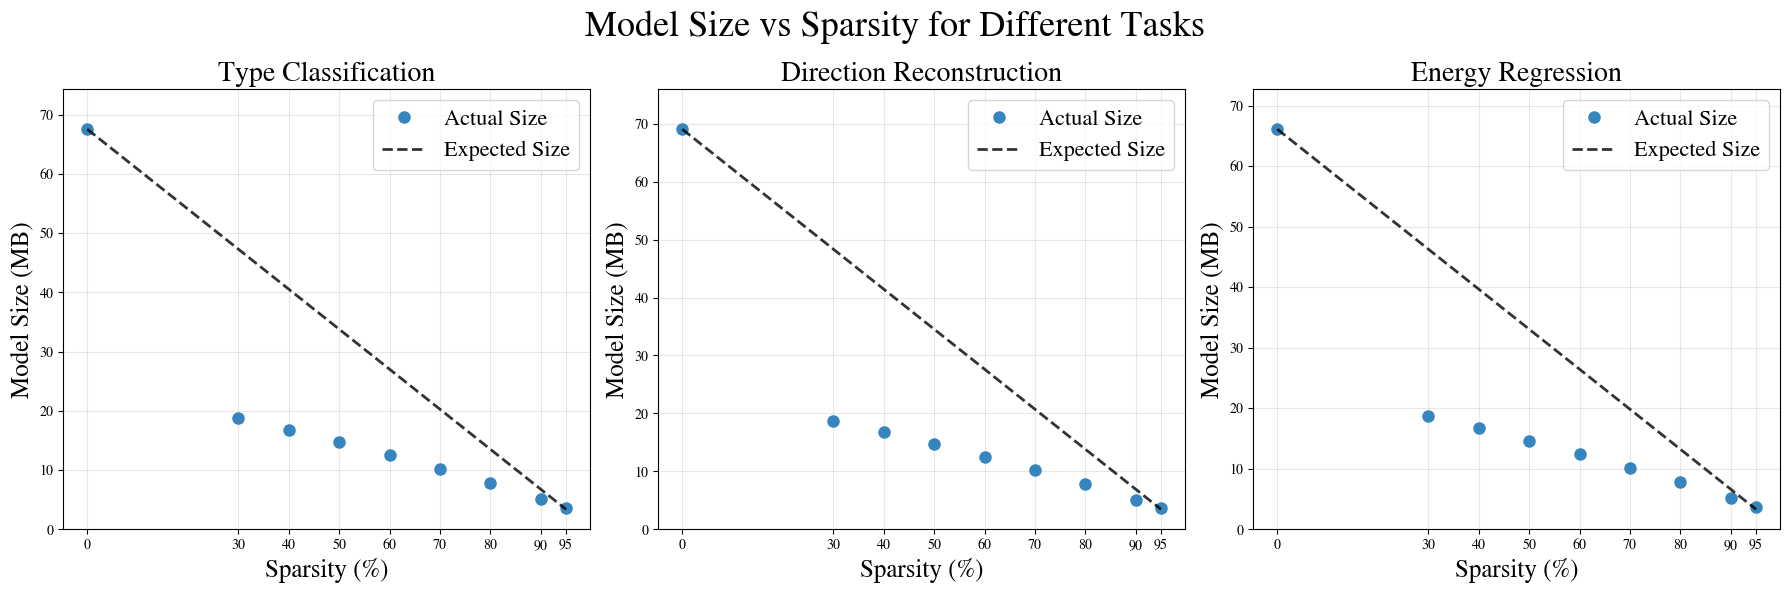

In [ ]:
### find ./99_sparsity/models/type/zip_fully_pruned_model.zip -type f -exec stat -c %s {} + | awk '{sum+=$1} END {printf "%.2f MB\n", sum/1024/1024}'


Type_size = [67.56, 18.77, 16.82, 14.67, 12.59, 10.19, 7.80, 5.15, 3.68]
Direction_size = [69.05, 18.74, 16.78, 14.72, 12.53, 10.23, 7.77, 5.14, 3.62] 
Energy_size = [66.10, 18.70, 16.74, 14.66, 12.49, 10.19, 7.81, 5.13, 3.68] 
percentages = [0, 30, 40, 50, 60, 70, 80, 90, 95]

def plot_size_vs_sparsity(all_percentages, Type_size, Direction_size, Energy_size):
    """
    Plot size vs sparsity for each reconstruction tasks.
    
    Parameters
    all_percentages (list): List of sparsity percentages (including 0 for baseline)
    Type_size (list): List of sizes for type classification task
    Direction_size (list): List of sizes for direction classification task
    Energy_size (list): List of sizes for energy regression task
    """

    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    # Data for subplots
    task_data = [
        (Type_size, "Type Classification", axes[0]),
        (Direction_size, "Direction Reconstruction", axes[1]),
        (Energy_size, "Energy Regression", axes[2])
    ]
    
    for sizes, task_name, ax in task_data:
        # Plot actual model sizes
        ax.plot(all_percentages, sizes, 
                marker='o', linewidth=0, markersize=8,
                color=CUSTOM_COLORS[0], label="Actual Size")
        
        # Calculate theoretical expected sizes based on sparsity
        baseline_size = sizes[0]  
        expected_sizes = []
        
        for sparsity in all_percentages:
            if sparsity == 0:
                expected_sizes.append(baseline_size)
            else:
                # For sparsity%, we expect (100-sparsity)% of original size
                expected_size = baseline_size * (100 - sparsity) / 100
                expected_sizes.append(expected_size)
        
        # Plot theoretical reference line
        ax.plot(all_percentages, expected_sizes,
                linestyle='--', linewidth=2, color='black',
                label="Expected Size", alpha=0.8)
        
        
        ax.set_xlabel("Sparsity (%)", fontsize=18)
        ax.set_ylabel("Model Size (MB)", fontsize=18)
        ax.set_title(f"{task_name}", fontsize=20)
        ax.legend(fontsize=16)
        ax.grid(True, alpha=0.3)
        ax.set_xticks(all_percentages)
        ax.set_ylim(0, max(sizes) * 1.1)
    
    plt.suptitle("Model Size vs Sparsity for Different Tasks", fontsize=26)
    plt.tight_layout()
    plt.show()


plot_size_vs_sparsity(percentages, Type_size, Direction_size, Energy_size)